# Prelimenary data analysis for the Pilot study

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pyxdf
import pandas as pd
import re

from jupyter_client import channels
import matplotlib
from matplotlib.pyplot import title
%matplotlib qt
matplotlib.use('Qt5Agg')

In [13]:
def convert_to_list(val):
    try:
        # Replace commas with colons inside the curly braces
        cleaned_string = val.strip('{}').rstrip(',')
        key, value = cleaned_string.split(", ")
        key = key.strip(' \"')
        value = value.strip('}')
        value = int(value)
        return [key, value]  # Convert the value to an integer
    except Exception as e:
        return None  # Handle invalid formats gracefully

In [3]:
xdf_file = 'data\\P101\\sub-P001_ses-Omnideck_S002_task-Default_run-001_eeg.xdf'
streams, fileheader = pyxdf.load_xdf(xdf_file, synchronize_clocks=False)



Stream 1: Calculated effective sampling rate 3855.1314 Hz is different from specified rate 100.0000 Hz.


In [60]:
a = streams[3]['info']
a

defaultdict(list,
            {'name': ['LiveAmpSN-102101-1031'],
             'type': ['EEG'],
             'channel_count': ['35'],
             'channel_format': ['float32'],
             'source_id': ['LiveAmpSN-102101-1031'],
             'nominal_srate': ['500.0000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['11928.13337070000'],
             'uid': ['bc2678cc-4919-4528-98ce-cc6b34bfd149'],
             'session_id': ['default'],
             'hostname': ['OMNIDECK'],
             'v4address': [None],
             'v4data_port': ['16573'],
             'v4service_port': ['16575'],
             'v6address': [None],
             'v6data_port': ['16573'],
             'v6service_port': ['16575'],
             'desc': [defaultdict(list,
                          {'channels': [defaultdict(list,
                                        {'channel': [defaultdict(list,
                                                      {'label': ['Fp1'],
      

In [17]:
# Creating a lookup table for changing marker ids to names
markers_df = pd.read_excel("Data Collection Format.xlsx", sheet_name=1)
markers_df.columns = markers_df.iloc[3]
markers_df = markers_df.iloc[4:]
markers_df.reset_index(drop=True, inplace=True)
markers_df = markers_df['Dictionary in Unity']
markers_df = markers_df.apply(convert_to_list)
markers_df = pd.DataFrame(markers_df[:].tolist())
markers_df.columns = ["marker_names", "marker_ids"]
id_to_name_map = markers_df.set_index('marker_ids')['marker_names'].to_dict()

In [19]:
# First find the correct streams in the list of streams:
eeg_stream  = next(s for s in streams if "EEG" in s['info']['type'][0])
#Hardcoded for the second run of omideck as it has a lot of marker streams that are nearly empty or empty
marker_stream = streams[1]

# Now I have to loop through the markers and translate them into the correct string

for i, marker in enumerate(streams[1]['time_series']):
    marker_stream['time_series'][i] = int(marker[0])

marker_stream['time_series']

TypeError: 'int' object is not subscriptable

In [26]:

for entry in marker_stream['time_series']:
    if entry == 'TrialStarts':
        print(entry)
    if entry == 'TrialEnds':
        print(entry)
    if entry == 'ServingTaskBegins':
        print(entry)
    if entry == 'ServingTaskEnds':
        print(entry)
    if entry == 'PointingTaskBegins':
        print(entry)
    if entry == 'PointingTaskEnds':
        print(entry)

TrialStarts
ServingTaskBegins
ServingTaskEnds
PointingTaskBegins
PointingTaskEnds
TrialStarts
ServingTaskBegins
ServingTaskEnds
PointingTaskBegins
PointingTaskEnds
TrialStarts
ServingTaskBegins
ServingTaskEnds
PointingTaskBegins
PointingTaskEnds
TrialEnds


In [41]:
# Extract EEG stream
eeg_data = np.array(eeg_stream['time_series']).T
eeg_timestamps = np.array(eeg_stream['time_stamps'])
sfreq = float(eeg_stream['info']['nominal_srate'][0])
ch_names = []
for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
    ch_names.append(ch['label'][0])
ch_names

['Fp1',
 'Fz',
 'F3',
 'F7',
 'F9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'P9',
 'O1',
 'Oz',
 'O2',
 'P10',
 'P8',
 'P4',
 'CP2',
 'CP6',
 'T8',
 'C4',
 'Cz',
 'FC2',
 'FC6',
 'F10',
 'F8',
 'F4',
 'Fp2',
 'ACC_X',
 'ACC_Y',
 'ACC_Z']

defaultdict(list,
            {'label': ['Fp1'], 'type': ['EEG'], 'unit': ['microvolts'], 0: []})

In [51]:
info = mne.create_info(
    ch_names=ch_names,
    sfreq=sfreq,
    ch_types='eeg'
)
raw = mne.io.RawArray(eeg_data, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=35, n_times=168545
    Range : 0 ... 168544 =      0.000 ...   337.088 secs
Ready.


ValueError: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['ACC_X', 'ACC_Y', 'ACC_Z'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

## Start of multiple file analysis

TODO:

    - Check rest of the markers if they are present, maybe check if the streams could just be combined based on the timestamp stream
    - Look at EEG data for certain events (Bottle Placed, Start of Trials (EEG headset was moved then), Figure out what else could be interesting)
    - Eoch around the events, look at MNE to see how this can be done

In [15]:
# Creating a lookup table for changing marker ids to names
markers_df = pd.read_excel("Data Collection Format.xlsx", sheet_name=1)
markers_df.columns = markers_df.iloc[3]
markers_df = markers_df.iloc[4:]
markers_df.reset_index(drop=True, inplace=True)
markers_df = markers_df['Dictionary in Unity']
markers_df = markers_df.apply(convert_to_list)
markers_df = pd.DataFrame(markers_df[:].tolist())
markers_df.columns = ["marker_names", "marker_ids"]
id_to_name_map = markers_df.set_index('marker_ids')['marker_names'].to_dict()

In [16]:
path = 'data\\P101\\'
for filename in sorted(os.listdir(path)):
    streams, fileheader = pyxdf.load_xdf(path+filename, synchronize_clocks=False)
    eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])
    print(f"File: {filename} \n")
    print("Number of Channels:", eeg_stream['info']['channel_count'])
    print("Sample Count:", len(eeg_stream['time_series']))

    print("\n Marker Info:")
    mStream_count = 0
    eegStream_count = 0
    longest_mStream = []
    for s in streams:
        if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0]:
            mStream_count += 1
            if len(s['time_series']) >= len(longest_mStream):
                longest_mStream = s
        elif "EEG" in s['info']['type'][0]:
            eegStream_count += 1
    print("Number of marker streams:", mStream_count)
    print("Number of EEG streams:", eegStream_count)
    #print("Longest marker stream:", longest_mStream)


    if mStream_count != 0:
        # changing the marker ids to the respective names
        for i, marker in enumerate(longest_mStream['time_series']):
            longest_mStream['time_series'][i] = id_to_name_map[int(marker[0])] #marker is ['int'] so we need to index and then convert to int
        print(f"It has {len(longest_mStream['time_series'])} markers")
        # Looking for more specific triggers and how often they exist
        print("# Start Trial", longest_mStream['time_series'].count('TrialStarts'))
        print("# End Trial", longest_mStream['time_series'].count('TrialEnds'))
        print("# Start Serving", longest_mStream['time_series'].count('ServingTaskBegins'))
        print("# End Serving", longest_mStream['time_series'].count('ServingTaskEnds'))
        print("# Start Pointing", longest_mStream['time_series'].count('PointingTaskBegins'))
        print("# End Pointing", longest_mStream['time_series'].count('PointingTaskEnds'))

        print("# Bottle Served", longest_mStream['time_series'].count('BottleServed'))
        print("# Hand Grabbed Bottle", longest_mStream['time_series'].count('HandGrabbedBottle'))
    else:
        print(f"It has no marker streams")



Stream 4: Calculated effective sampling rate 3838.2483 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Joystick_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 146504

 Marker Info:
Number of marker streams: 65
Number of EEG streams: 1
It has 488 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3869.2886 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Joystick_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 146988

 Marker Info:
Number of marker streams: 61
Number of EEG streams: 1
It has 491 markers
# Start Trial 4
# End Trial 0
# Start Serving 4
# End Serving 3
# Start Pointing 3
# End Pointing 2
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3867.5898 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Joystick_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 132480

 Marker Info:
Number of marker streams: 59
Number of EEG streams: 1
It has 516 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3868.6817 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Leaning_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 190017

 Marker Info:
Number of marker streams: 62
Number of EEG streams: 1
It has 524 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3877.7861 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Leaning_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 172516

 Marker Info:
Number of marker streams: 61
Number of EEG streams: 1
It has 516 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3880.4282 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Leaning_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 185554

 Marker Info:
Number of marker streams: 61
Number of EEG streams: 1
It has 524 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 1: Calculated effective sampling rate 3873.4319 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Omnideck_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 242768

 Marker Info:
Number of marker streams: 0
Number of EEG streams: 1
It has no marker streams


Stream 1: Calculated effective sampling rate 3855.1314 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Omnideck_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 168545

 Marker Info:
Number of marker streams: 64
Number of EEG streams: 1
It has 494 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3860.9512 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Omnideck_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 170747

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 462 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 4: Calculated effective sampling rate 3880.4616 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Walking_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 105163

 Marker Info:
Number of marker streams: 62
Number of EEG streams: 1
It has 484 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


Stream 3: Calculated effective sampling rate 3883.5396 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Walking_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 133241

 Marker Info:
Number of marker streams: 64
Number of EEG streams: 1
It has 491 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


found likely XDF file corruption (no element found: line 1, column 667), ignoring corrupted XML element in footer.
Stream 3: Calculated effective sampling rate 3890.0385 Hz is different from specified rate 100.0000 Hz.


File: sub-P001_ses-Walking_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 105133

 Marker Info:
Number of marker streams: 61
Number of EEG streams: 1
It has 481 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38
# Bottle Served 0


In [9]:
path = 'data\\P104\\'
for filename in sorted(os.listdir(path)):
    streams, fileheader = pyxdf.load_xdf(path+filename, synchronize_clocks=False)
    eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])
    print(f"File: {filename} \n")
    print("Number of Channels:", eeg_stream['info']['channel_count'])
    print("Sample Count:", len(eeg_stream['time_series']))

    print("\n Marker Info:")
    mStream_count = 0
    eegStream_count = 0
    longest_mStream = []
    for s in streams:
        if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0]:
            mStream_count += 1
            if len(s['time_series']) >= len(longest_mStream):
                longest_mStream = s
        elif "EEG" in s['info']['type'][0]:
            eegStream_count += 1
    print("Number of marker streams:", mStream_count)
    print("Number of EEG streams:", eegStream_count)
    #print("Longest marker stream:", longest_mStream)


    if mStream_count != 0:
        # changing the marker ids to the respective names
        for i, marker in enumerate(longest_mStream['time_series']):
            longest_mStream['time_series'][i] = id_to_name_map[int(marker[0])] #marker is ['int'] so we need to index and then convert to int
        print(f"It has {len(longest_mStream['time_series'])} markers")
        # Looking for more specific triggers and how often they exist
        print("# Start Trial", longest_mStream['time_series'].count('TrialStarts'))
        print("# End Trial", longest_mStream['time_series'].count('TrialEnds'))
        print("# Start Serving", longest_mStream['time_series'].count('ServingTaskBegins'))
        print("# End Serving", longest_mStream['time_series'].count('ServingTaskEnds'))
        print("# Start Pointing", longest_mStream['time_series'].count('PointingTaskBegins'))
        print("# End Pointing", longest_mStream['time_series'].count('PointingTaskEnds'))

        print("# Bottle Served", longest_mStream['time_series'].count('BottleServed'))
    else:
        print(f"It has no marker streams")



Stream 2: Calculated effective sampling rate 3844.7718 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Joystick_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 246785

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 498 markers
# Start Trial 4
# End Trial 1
# Start Serving 4
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 1: Calculated effective sampling rate 3859.9709 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Joystick_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 191296

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 499 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 2: Calculated effective sampling rate 3872.0841 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Joystick_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 211022

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 466 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 3: Calculated effective sampling rate 3887.8764 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Leaning_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 281528

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 745 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 4: Calculated effective sampling rate 3879.0192 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Leaning_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 230811

 Marker Info:
Number of marker streams: 64
Number of EEG streams: 1
It has 679 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 4: Calculated effective sampling rate 3881.6451 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Leaning_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 216274

 Marker Info:
Number of marker streams: 61
Number of EEG streams: 1
It has 491 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


found likely XDF file corruption (unclosed token: line 1, column 1527), ignoring corrupted XML element in footer.
Stream 2: Calculated effective sampling rate 3884.8861 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Omnideck_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 277018

 Marker Info:
Number of marker streams: 62
Number of EEG streams: 1
It has 507 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


found likely XDF file corruption (unclosed token: line 1, column 3047), ignoring corrupted XML element in footer.
Stream 3: Calculated effective sampling rate 3870.9120 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Omnideck_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 253538

 Marker Info:
Number of marker streams: 60
Number of EEG streams: 1
It has 487 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 4: Calculated effective sampling rate 3871.6332 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Omnideck_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 237523

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 493 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 2: Calculated effective sampling rate 3892.4885 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Walking_S001_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 235007

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 464 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 2: Calculated effective sampling rate 3884.9657 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Walking_S002_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 218270

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 448 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


Stream 3: Calculated effective sampling rate 3889.1854 Hz is different from specified rate 100.0000 Hz.


File: sub-P104_ses-Walking_S003_task-Default_run-001_eeg.xdf 

Number of Channels: ['35']
Sample Count: 220036

 Marker Info:
Number of marker streams: 1
Number of EEG streams: 1
It has 468 markers
# Start Trial 3
# End Trial 1
# Start Serving 3
# End Serving 3
# Start Pointing 3
# End Pointing 3
# Bottle Served 38


# Looking into the frontal channels at the beginning of the Trial

In [3]:
streams, fileheader = pyxdf.load_xdf('data\\P105\\sub-Pilot105_ses-Joystick_1_task-Default_run-001_eeg.xdf', synchronize_clocks=False)
eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])

eeg_data = np.array(eeg_stream['time_series']).T
eeg_timestamps = np.array(eeg_stream['time_stamps'])
sfreq = float(eeg_stream['info']['nominal_srate'][0])
frontal_channels = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8']
ch_names = []
for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
    ch_names.append(ch['label'][0])
#frontal_indices = [i for i, ch in enumerate(ch_names) if ch in frontal_channels]
#frontal_data = eeg_data[frontal_indices, :]

Stream 4: Calculated effective sampling rate 3690.3631 Hz is different from specified rate 100.0000 Hz.


In [4]:
info = mne.create_info(
    ch_names=ch_names[:-3],
    sfreq=sfreq,
    ch_types='eeg'
)
#removing the ACC channels and scaling the signal down
raw = mne.io.RawArray(eeg_data[:-3]/10e5, info)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
marker_stream = []
for s in streams:
    if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0]:
        if len(s['time_series']) >= len(marker_stream):
            marker_stream = s
event_labels = [int(marker[0]) for marker in marker_stream['time_series']]
event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
event_samples = event_samples.astype(int)


Creating RawArray with float64 data, n_channels=32, n_times=182495
    Range : 0 ... 182494 =      0.000 ...   364.988 secs
Ready.


Using matplotlib as 2D backend.


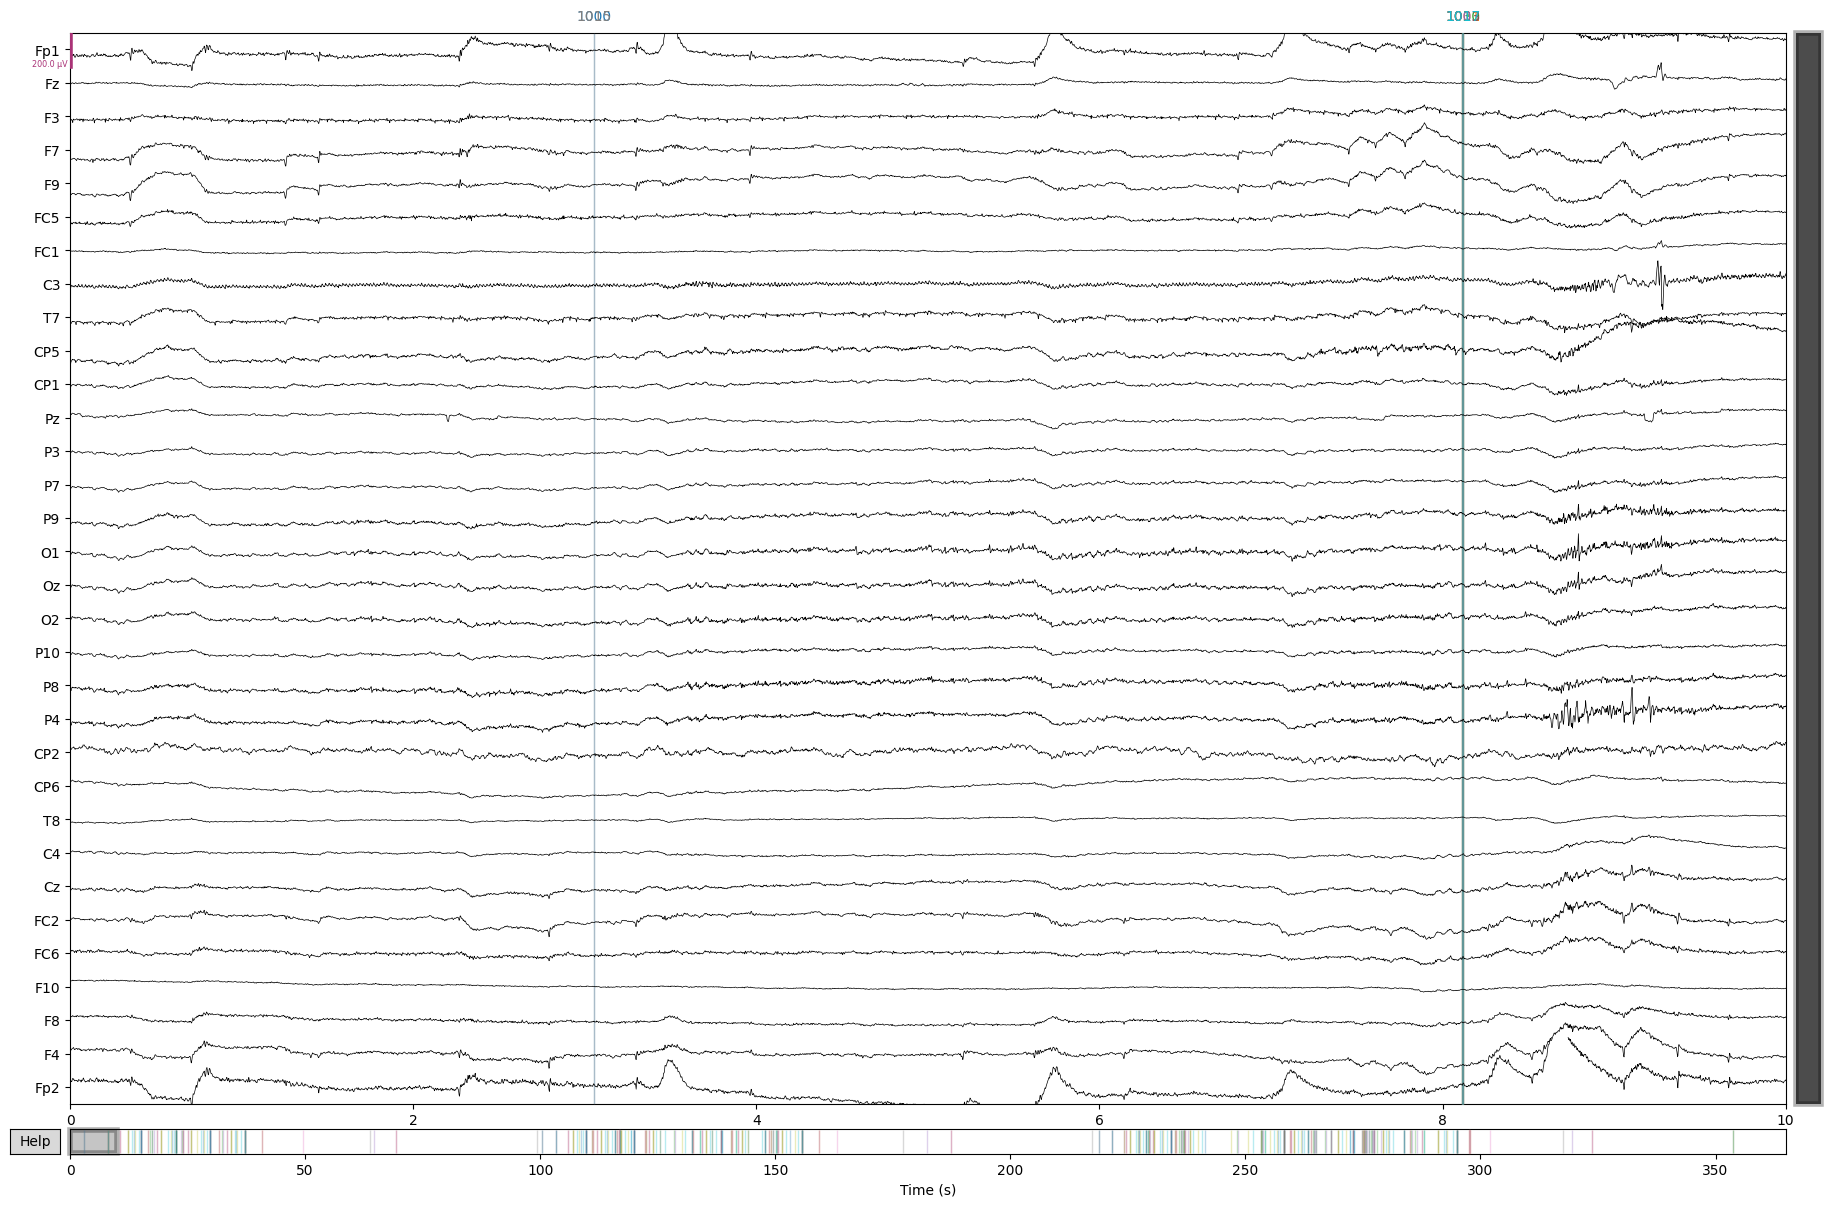

In [5]:
#event_id_map = {label: idx + 1 for idx, label in enumerate(set(event_labels))}
events = np.array([[sample, 0, label] for sample, label in zip(event_samples, event_labels)])
annotations = mne.Annotations(onset=event_samples / sfreq,
                              duration=[0] * len(event_samples),  # Instantaneous events
                              description=list(event_labels))
raw.set_annotations(annotations)
# Verify the resulting Raw object
raw.plot(scalings=0.0001, n_channels=32)

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1030'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
[[176838      0   1002]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 10001 original time points ...
1 bad epochs dropped


C:\Users\stadl\AppData\Local\Temp\ipykernel_19384\3031946724.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs.get_data()


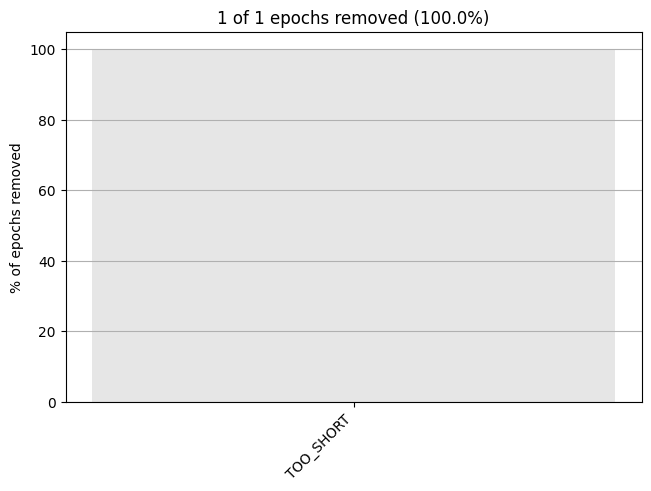

In [8]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
event_id = 1002 # beginning of trial
selected_events = events[events[:, 2] == event_id]
print(selected_events)
epochs = mne.Epochs(raw, np.array(selected_events), event_id=int(event_id), tmin=0, tmax=20, baseline=None, reject_by_annotation=False)

#epochs.plot(scalings=0.0001,n_channels = 32)
epochs.get_data()
epochs.plot_drop_log()

In [24]:
index = -1
for i, entry in enumerate(marker_stream['time_series']):
    if entry == ['1001']:
        index = i
print(index)
marker_stream['time_stamps'][index]

2


np.float64(260401.5676694)

In [23]:
len(marker_stream['time_stamps'])

456

In [34]:
evoked = epochs.average()
epochs.get_data()

array([[[ 0.00956303,  0.0095603 ,  0.00956079, ...,  0.00956539,
          0.00957251,  0.00960205],
        [ 0.00356401,  0.00356344,  0.00356185, ...,  0.00353788,
          0.00353727,  0.00353646],
        [ 0.00152441,  0.00152376,  0.00152279, ...,  0.00152763,
          0.00152677,  0.00152364],
        ...,
        [-0.00357695, -0.00357577, -0.00357605, ..., -0.00360038,
         -0.00360136, -0.00359985],
        [ 0.00769214,  0.00768892,  0.0076829 , ...,  0.00769812,
          0.00769727,  0.00770166],
        [ 0.01203503,  0.01202486,  0.01201794, ...,  0.01209884,
          0.01210079,  0.01210087]]])

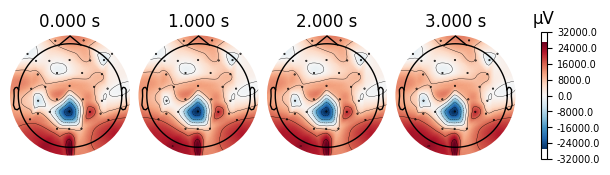

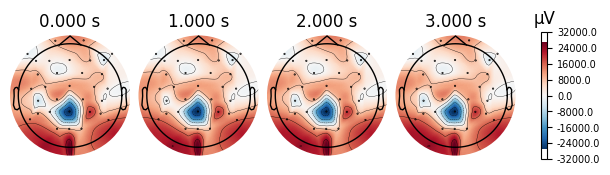

In [49]:

# Select a time point or time range to plot the topomap
time_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]  # Time in seconds (e.g., 100 ms)
# Create and display the topoplot



evoked.plot_topomap()



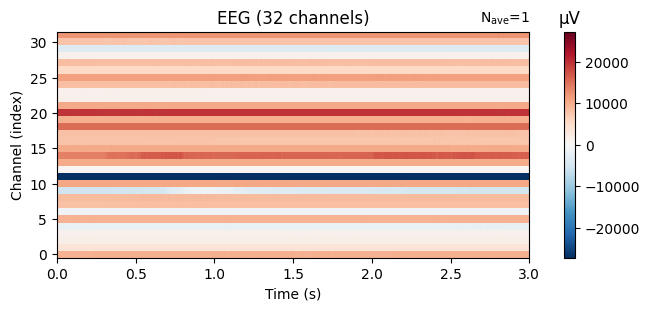

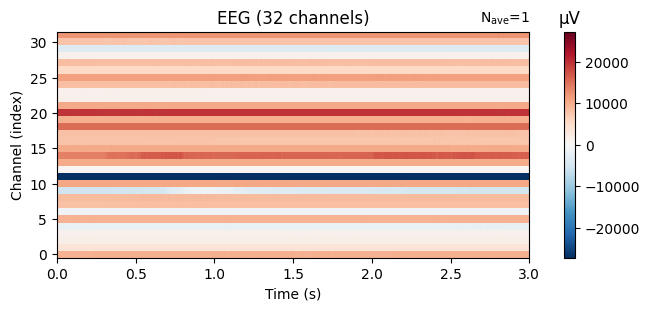

In [50]:
evoked.plot_image()

NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\stadl\AppData\Local\Temp\ipykernel_23060\792743003.py:3: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Qt5Agg')


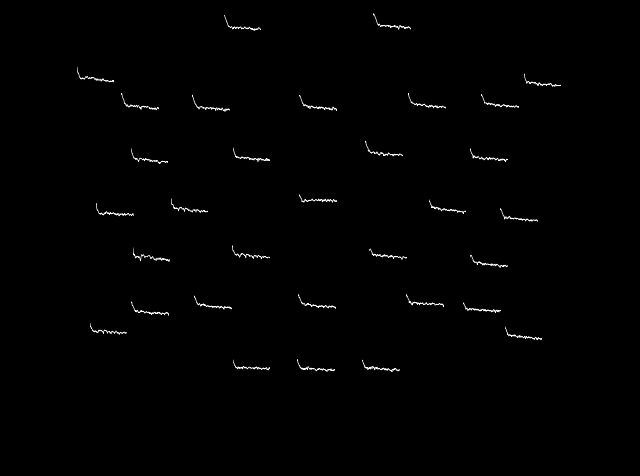

In [13]:
import matplotlib
%matplotlib qt
matplotlib.use('Qt5Agg')
epochs.plot_psd_topo()

In [27]:
# Doing Beginning few seconds for all the files and saving the plots
subjects = ['P105'] # 'P101', 'P104',
path = 'data\\'
frontal_channels = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8']
for id_ in subjects:
    for filename in sorted(os.listdir(path+id_)):
        print(filename)
        if filename == 'sub-P001_ses-Omnideck_S001_task-Default_run-001_eeg.xdf':
            continue
        streams, fileheader = pyxdf.load_xdf(path+id_+'\\'+filename, synchronize_clocks=False)
        eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])

        eeg_data = np.array(eeg_stream['time_series']).T
        #eeg_timestamps = np.array(eeg_stream['time_stamps'])
        sfreq = float(eeg_stream['info']['nominal_srate'][0])
        ch_names = []
        for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
            ch_names.append(ch['label'][0])

        info = mne.create_info(
            ch_names=ch_names[:-3],
            sfreq=sfreq,
            ch_types='eeg'
        )
        raw = mne.io.RawArray(eeg_data[:-3]/10e5, info)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # extracting the longest stream for now, maybe combining streams based on time_stamp would be a valid option
        marker_stream = []
        for s in streams:
            if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0]:
                if len(s['time_series']) >= len(marker_stream):
                    marker_stream = s
        event_labels = [int(marker[0]) for marker in marker_stream['time_series']]
        event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
        event_samples = event_samples.astype(int)
        events = np.array([[sample, 0, label] for sample, label in zip(event_samples, event_labels)])
        annotations = mne.Annotations(onset=event_samples / sfreq,
                                      duration=[0] * len(event_samples),  # Instantaneous events
                                      description=list(event_labels))
        raw.set_annotations(annotations)

        events_from_annot, event_dict = mne.events_from_annotations(raw)
        event_id = 1001 # beginning of trial
        t_max = 10
        selected_events = events[events[:, 2] == event_id]
        print('Selected events:', selected_events)
        epochs = mne.Epochs(raw, np.array(selected_events), event_id=int(event_id),baseline=None, tmin=0, tmax=t_max,preload=True, reject_by_annotation=True)  # For p001, P104 np.array([selected_events[0]])
        print(epochs)
        match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
        #for channel in ch_names[:-3]:
        #    fig = epochs.plot(scalings=0.0001, picks=channel)    #scalings=0.0001,
        #    fig.savefig(f'figures\\{match}_individual _channels\\{match+'_'+channel}_trial_start.png')
        #    plt.close(fig)

        fig = epochs.plot(scalings=0.0001, n_channels=32)    #scalings=0.0001,
        fig.savefig(f'figures\\{filename}_all_channels_{t_max}_trial_start.png')
        plt.close(fig)

        #evoked = epochs.average()
        # Select a time point or time range to plot the topomap
        #time_to_plot = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]  # Time in seconds (e.g., 100 ms)
        # Create and display the topoplot
        #fig = evoked.plot_topomap(times=time_to_plot, ch_type='eeg', show=True)
        #fig.savefig(f'figures\\{match}_trial_start_topomap.png')
        #plt.close(fig)

        #fig = mne.viz.plot_evoked_topo(evoked, title = filename)
        #fig.savefig(f'figures\\{match}_trial_start_all_ch.png')
        #plt.close(fig)



sub-Pilot105_ses-Joystick_1_task-Default_run-001_eeg.xdf


Stream 4: Calculated effective sampling rate 3690.3631 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=182495
    Range : 0 ... 182494 =      0.000 ...   364.988 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1030'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[4058    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 4: Calculated effective sampling rate 3686.1378 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=113261
    Range : 0 ... 113260 =      0.000 ...   226.520 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1030'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5886    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped


C:\Users\stadl\AppData\Local\Temp\ipykernel_19384\2354670829.py:42: RuntimeWarning: Omitted 202 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<Epochs | 1 events (all good), 0 – 10 s (baseline off), ~1.3 MB, data loaded,
 '1001': 1>
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
sub-Pilot105_ses-Leaning_1_task-Default_run-001_eeg.xdf


Stream 4: Calculated effective sampling rate 3890.7913 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=242269
    Range : 0 ... 242268 =      0.000 ...   484.536 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[8875    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 4: Calculated effective sampling rate 3691.1180 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=227037
    Range : 0 ... 227036 =      0.000 ...   454.072 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[6604    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 4: Calculated effective sampling rate 3687.5296 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=249802
    Range : 0 ... 249801 =      0.000 ...   499.602 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5798    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 3: Calculated effective sampling rate 3870.0543 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=249779
    Range : 0 ... 249778 =      0.000 ...   499.556 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[3300    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 3: Calculated effective sampling rate 3876.2868 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=257481
    Range : 0 ... 257480 =      0.000 ...   514.960 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[11963     0  1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 event

Stream 3: Calculated effective sampling rate 3880.5076 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=234525
    Range : 0 ... 234524 =      0.000 ...   469.048 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5900    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 2: Calculated effective sampling rate 3835.9847 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=219283
    Range : 0 ... 219282 =      0.000 ...   438.564 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[4367    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 1: Calculated effective sampling rate 3880.3093 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=230534
    Range : 0 ... 230533 =      0.000 ...   461.066 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[7155    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

Stream 1: Calculated effective sampling rate 3884.1293 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=189018
    Range : 0 ... 189017 =      0.000 ...   378.034 secs
Ready.
Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5354    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 5001 original time points ...
0 bad epochs dropped
<Epochs | 1 events (

In [29]:
# Doing Beginning three seconds for all the files and saving the plots
subjects = ['P105'] # 'P101', 'P104',
path = 'data\\'
frontal_channels = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8']
for id_ in subjects:
    for filename in sorted(os.listdir(path+id_)):
        print(filename)
        if filename == 'sub-P001_ses-Omnideck_S001_task-Default_run-001_eeg.xdf':
            continue
        streams, fileheader = pyxdf.load_xdf(path+id_+'\\'+filename, synchronize_clocks=False)
        eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])

        eeg_data = np.array(eeg_stream['time_series']).T
        #eeg_timestamps = np.array(eeg_stream['time_stamps'])
        sfreq = float(eeg_stream['info']['nominal_srate'][0])
        ch_names = []
        for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
            ch_names.append(ch['label'][0])

        info = mne.create_info(
            ch_names=ch_names[:-3],
            sfreq=sfreq,
            ch_types='eeg'
        )
        raw = mne.io.RawArray(eeg_data[:-3]/10e5, info)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)
        raw = raw.notch_filter(50, method='fir', phase='zero')
        iir_params = dict(order=2, ftype='butter')
        raw = raw.filter(l_freq=0.01, h_freq=30, method='iir', iir_params=iir_params, phase='zero')
        # extracting the longest stream for now, maybe combining streams based on time_stamp would be a valid option
        marker_stream = []
        for s in streams:
            if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0]:
                if len(s['time_series']) >= len(marker_stream):
                    marker_stream = s
        event_labels = [int(marker[0]) for marker in marker_stream['time_series']]
        event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
        event_samples = event_samples.astype(int)
        events = np.array([[sample, 0, label] for sample, label in zip(event_samples, event_labels)])
        annotations = mne.Annotations(onset=event_samples / sfreq,
                                      duration=[0] * len(event_samples),  # Instantaneous events
                                      description=list(event_labels))
        raw.set_annotations(annotations)

        #fig = raw.plot(scalings='0.0001', n_channels=32, duration=60)
        #fig.savefig(f'figures\\{filename}_start_filtered.png')
        #plt.close(fig)

        events_from_annot, event_dict = mne.events_from_annotations(raw)
        event_id = 1001 # beginning of trial
        selected_events = events[events[:, 2] == event_id]
        print('Selected events:', selected_events)
        epochs = mne.Epochs(raw, np.array(selected_events), event_id=int(event_id),baseline=None, tmin=0, tmax=30, reject_by_annotation=False)  # For p001, P104 np.array([selected_events[0]])
        match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
        #for channel in ch_names[:-3]:
        #    fig = epochs.plot(scalings=0.0001, picks=channel)    #scalings=0.0001,
        #    fig.savefig(f'figures\\{match}_individual _channels\\{match+'_'+channel}_trial_start.png')
        #    plt.close(fig)

        fig = epochs.plot(scalings=0.00005, n_channels=32)    #scalings=0.0001,
        fig.savefig(f'figures\\filtered_{filename+'_'+'all_channels_30s'}_trial_start.png')
        plt.close(fig)



sub-Pilot105_ses-Joystick_1_task-Default_run-001_eeg.xdf


Stream 4: Calculated effective sampling rate 3690.3631 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=182495
    Range : 0 ... 182494 =      0.000 ...   364.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1030'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[4058    0 1001]]
Not setting metadata
1 matching events 

Stream 4: Calculated effective sampling rate 3686.1378 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=113261
    Range : 0 ... 113260 =      0.000 ...   226.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1030'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5886    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


C:\Users\stadl\AppData\Local\Temp\ipykernel_19384\4253608825.py:44: RuntimeWarning: Omitted 202 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


Using data from preloaded Raw for 1 events and 15001 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
sub-Pilot105_ses-Leaning_1_task-Default_run-001_eeg.xdf


Stream 4: Calculated effective sampling rate 3890.7913 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=242269
    Range : 0 ... 242268 =      0.000 ...   484.536 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[8875    0 1001]]
Not setting metadata
1 matching events 

Stream 4: Calculated effective sampling rate 3691.1180 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=227037
    Range : 0 ... 227036 =      0.000 ...   454.072 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[6604    0 1001]]
Not setting metadata
1 matching events 

Stream 4: Calculated effective sampling rate 3687.5296 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=249802
    Range : 0 ... 249801 =      0.000 ...   499.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5798    0 1001]]
Not setting metadata
1 matching events 

Stream 3: Calculated effective sampling rate 3870.0543 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=249779
    Range : 0 ... 249778 =      0.000 ...   499.556 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[3300    0 1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 15001 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
sub-Pilot105_ses-Omnideck_2_task-Default_run-001_eeg.xdf


Stream 3: Calculated effective sampling rate 3876.2868 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=257481
    Range : 0 ... 257480 =      0.000 ...   514.960 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[11963     0  1001]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 15001 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
sub-Pilot105_ses-Omnideck_3_task-Default_run-001_eeg.xdf


Stream 3: Calculated effective sampling rate 3880.5076 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=234525
    Range : 0 ... 234524 =      0.000 ...   469.048 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1032'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5900    0 1001]]
Not setting metadata
1 matching events 

Stream 2: Calculated effective sampling rate 3835.9847 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=219283
    Range : 0 ... 219282 =      0.000 ...   438.564 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[4367    0 1001]]
Not setting metadata
1 matching events 

Stream 1: Calculated effective sampling rate 3880.3093 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=230534
    Range : 0 ... 230533 =      0.000 ...   461.066 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[7155    0 1001]]
Not setting metadata
1 matching events 

Stream 1: Calculated effective sampling rate 3884.1293 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=189018
    Range : 0 ... 189017 =      0.000 ...   378.034 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1000'), np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1031'), np.str_('1033'), np.str_('1034'), np.str_('1035'), np.str_('1036')]
Selected events: [[5354    0 1001]]
Not setting metadata
1 matching events 

In [21]:
import re
filename = "sub-P001_ses-Walking_S001_task-Default_run-001_eeg.xdf"
match = re.match(r"^(.*)_task-Default_run", filename)
match.group(1)

'sub-P001_ses-Walking_S001'

In [29]:
filename = "sub-P001_ses-Walking_S001_task-Default_run-001_eeg.xdf"

# Removing only the _ses part
result = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
print(result)

sub-P001-Walking_S001


# Looking at Movement onset and some preliminary ERDS, MRCP

In [86]:
streams, fileheader = pyxdf.load_xdf('data\\P101\\sub-P001_ses-Joystick_S001_task-Default_run-001_eeg.xdf', synchronize_clocks=False)
eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])

eeg_data = np.array(eeg_stream['time_series']).T
eeg_timestamps = np.array(eeg_stream['time_stamps'])
sfreq = float(eeg_stream['info']['nominal_srate'][0])
#frontal_channels = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8']
ch_names = []
for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
    ch_names.append(ch['label'][0])

info = mne.create_info(
    ch_names=ch_names[:-3],
    sfreq=sfreq,
    ch_types='eeg'
)

raw = mne.io.RawArray(eeg_data[:-3]/10e5, info)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
marker_streams = [stream for stream in streams if stream['info']['type'][0] == 'Markers']

# Initialize combined lists for time_series and time_stamps
combined_time_series = []
combined_time_stamps = []

# Combine time_series and time_stamps from all marker streams
for stream in marker_streams:
    combined_time_series.extend(stream['time_series'])
    combined_time_stamps.extend(stream['time_stamps'])

# Convert to numpy arrays for sorting
combined_time_series = np.array(combined_time_series)
combined_time_stamps = np.array(combined_time_stamps)

# Sort by time_stamps
sorted_indices = np.argsort(combined_time_stamps)
sorted_time_series = combined_time_series[sorted_indices]
sorted_time_stamps = combined_time_stamps[sorted_indices]

time_series = []
time_stamps = []
for series, stamp in zip(sorted_time_series, sorted_time_stamps):
    if len(series) == 0:
        continue
    elif series == ['']:
        continue
    else:
        time_series.append(int(series[0]))
        time_stamps.append(stamp)
print('type', type(time_series[0]))
marker_stream = {
    'info': marker_streams[0]['info'],
    'time_series': np.array(time_series),
    'time_stamps': np.array(time_stamps),
}

event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
event_samples = event_samples.astype(int)


events = np.array([[sample, 0, label] for sample, label in zip(event_samples, marker_stream['time_series'])])
annotations = mne.Annotations(onset=event_samples / sfreq,
                              duration=[0] * len(event_samples),  # Instantaneous events
                              description=list(marker_stream['time_series']))
raw.set_annotations(annotations)

Stream 4: Calculated effective sampling rate 3838.2483 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=146504
    Range : 0 ... 146503 =      0.000 ...   293.006 secs
Ready.
type <class 'int'>


<RawArray | 32 x 146504 (293.0 s), ~35.8 MB, data loaded>

In [87]:
# Filtering for MRCP and in general. Power Line noise (50Hz) and filter between 0.1 and 30Hz in general. MRCP is slow changes around 0.1 and 1Hz.
raw = raw.notch_filter(50, method='fir', phase='zero')
iir_params = dict(order=2, ftype='butter')
raw = raw.filter(l_freq=0.01, h_freq=30, method='iir', iir_params=iir_params, phase='zero')
raw.plot_psd()
plt.close()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [88]:
import matplotlib
#%matplotlib qt
#matplotlib.use('Qt5Agg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloa

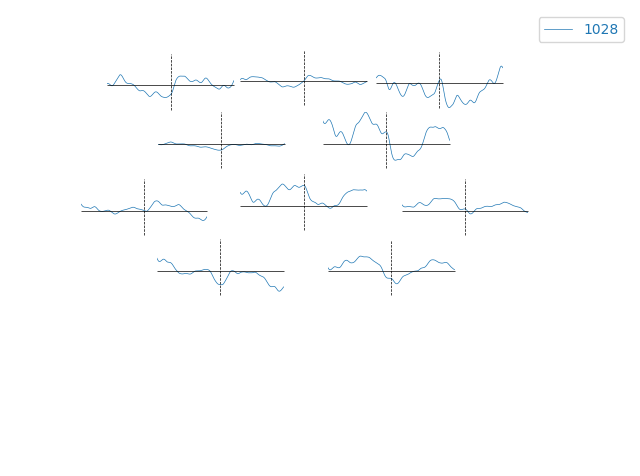

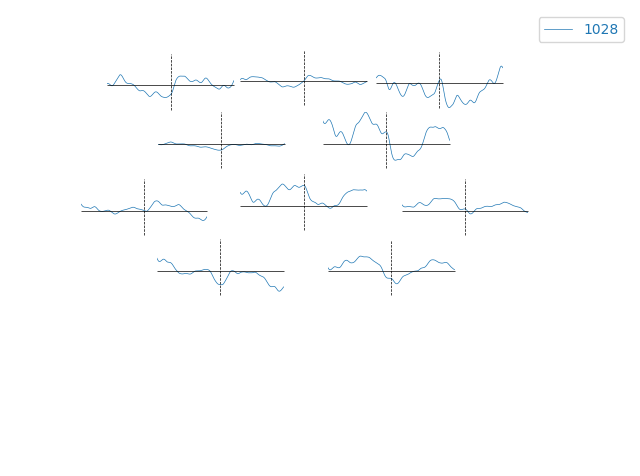

In [89]:
iir_params = dict(order=2, ftype='butter')
mrcp_data = raw.filter(l_freq=0.01, h_freq=1, method='iir', iir_params=iir_params, phase='zero')
events_from_annot, event_dict = mne.events_from_annotations(raw)
event_id = 1028 # beginning of trial
selected_events = events[events[:, 2] == event_id]
# when commbining all the marker stream each marker is present two times, so i only index every other one.
epochs = mne.Epochs(raw, np.array(selected_events[::2]), event_id=int(event_id), tmin=-6, tmax=6, baseline=None, preload=True)
# a
evoked = epochs.average()
evoked = evoked.pick(picks=['F3', 'Fz', 'F4','FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1' ,'CP2'])
#evoked.plot_joint(picks=['F3', 'Fz', 'F4','FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1' ,'CP2'])
evoked.plot_topo()

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
F3
Need more than one channel to make topography for eeg. Disabling interactivity.


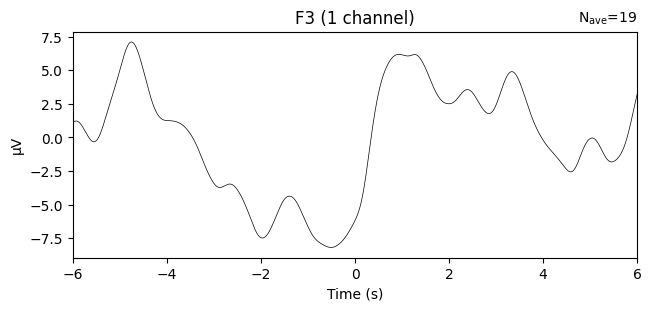

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
Fz
Need more than one channel to make topography for eeg. Disabling interactivity.


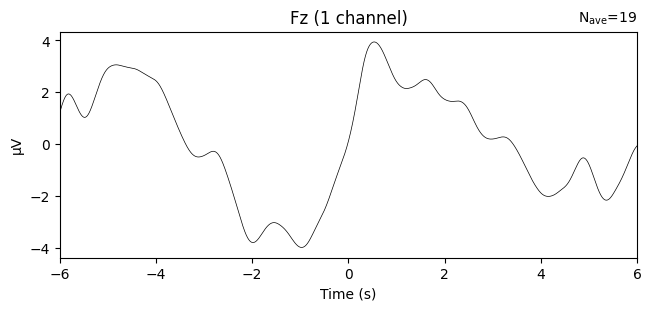

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
F4
Need more than one channel to make topography for eeg. Disabling interactivity.


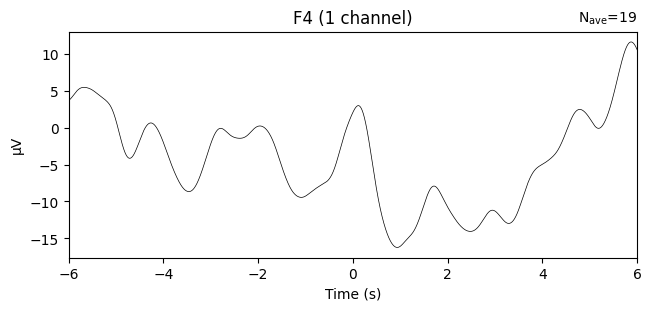

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
FC1
Need more than one channel to make topography for eeg. Disabling interactivity.


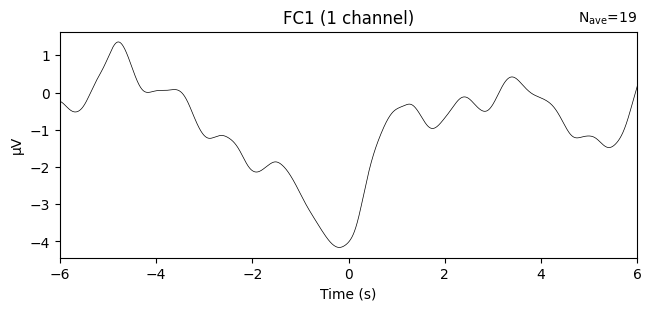

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
FC2
Need more than one channel to make topography for eeg. Disabling interactivity.


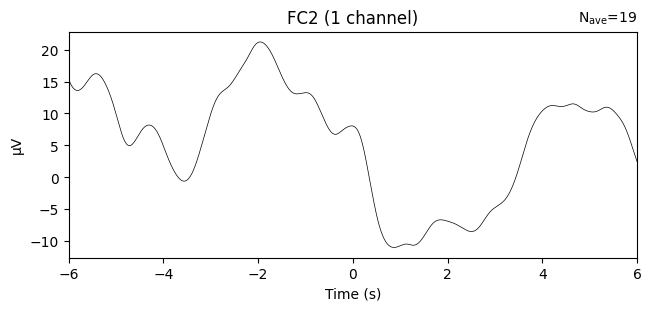

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
C3
Need more than one channel to make topography for eeg. Disabling interactivity.


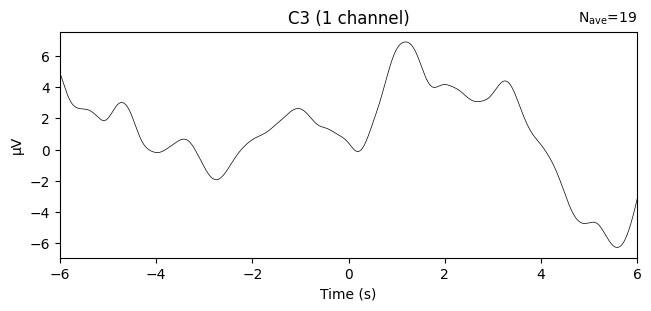

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
Cz
Need more than one channel to make topography for eeg. Disabling interactivity.


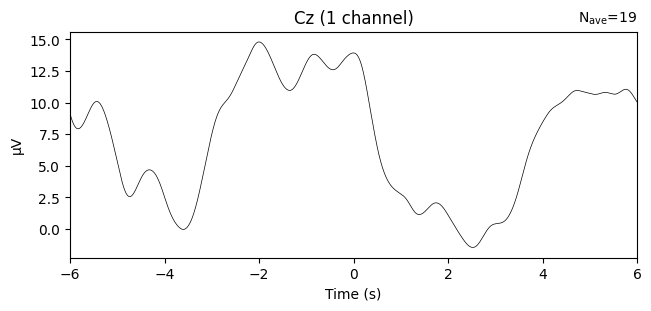

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
C4
Need more than one channel to make topography for eeg. Disabling interactivity.


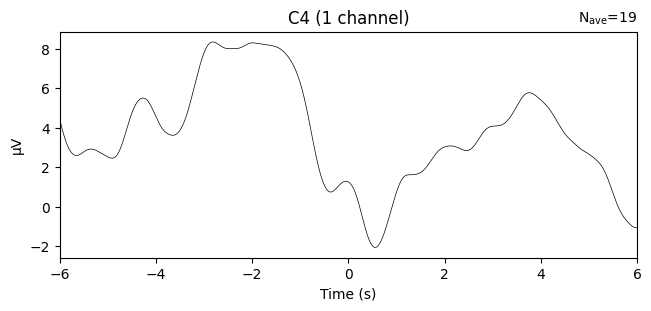

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
CP1
Need more than one channel to make topography for eeg. Disabling interactivity.


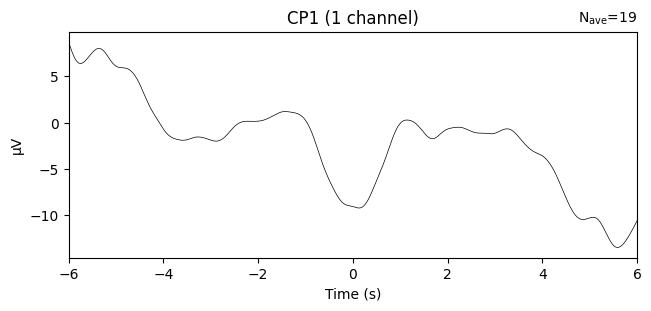

['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
CP2
Need more than one channel to make topography for eeg. Disabling interactivity.


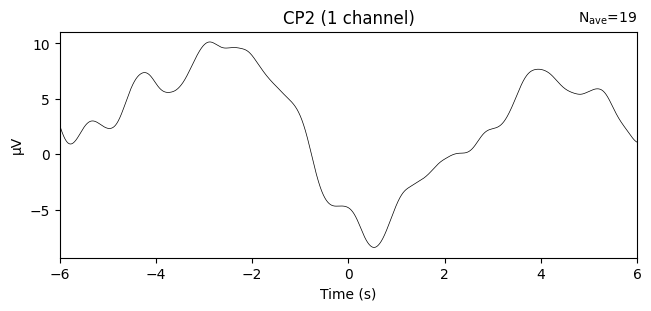

In [90]:

for ch in evoked.ch_names:
    print(evoked.ch_names)
    print(ch)
    temp_evoked = evoked.copy().pick(picks=ch)
    temp_evoked.plot(titles=ch)

In [91]:
i = 0
my_bool = True
overall_count = 0
while my_bool:
    print(f'{1000+i} is present {np.sum(marker_stream['time_series']==1000+i)} times')
    overall_count += np.sum(marker_stream['time_series'][::2]==1000+i)
    i += 1
    if i ==38:
        my_bool = False
overall_count

1000 is present 0 times
1001 is present 6 times
1002 is present 6 times
1003 is present 2 times
1004 is present 6 times
1005 is present 6 times
1006 is present 6 times
1007 is present 6 times
1008 is present 7 times
1009 is present 19 times
1010 is present 76 times
1011 is present 38 times
1012 is present 212 times
1013 is present 42 times
1014 is present 18 times
1015 is present 4 times
1016 is present 24 times
1017 is present 6 times
1018 is present 24 times
1019 is present 42 times
1020 is present 18 times
1021 is present 18 times
1022 is present 38 times
1023 is present 38 times
1024 is present 38 times
1025 is present 38 times
1026 is present 88 times
1027 is present 88 times
1028 is present 38 times
1029 is present 38 times
1030 is present 0 times
1031 is present 0 times
1032 is present 0 times
1033 is present 0 times
1034 is present 6 times
1035 is present 6 times
1036 is present 0 times
1037 is present 0 times


np.int64(501)

OrderedDict([('onset', np.float64(5.79)),
             ('duration', np.float64(0.0)),
             ('description', np.str_('1001')),
             ('orig_time', None)])

In [76]:
print(marker_stream['time_series'][::2])

[1001 1002 1004 1018 1023 1024 1025 1026 1012 1012 1009 1010 1027 1026
 1012 1012 1009 1010 1011 1019 1016 1014 1027 1028 1029 1022 1023 1024
 1025 1026 1012 1012 1010 1027 1026 1012 1009 1010 1011 1019 1016 1014
 1027 1028 1029 1022 1023 1024 1025 1026 1012 1012 1010 1027 1026 1012
 1012 1010 1011 1019 1016 1014 1027 1028 1029 1022 1012 1013 1023 1024
 1025 1026 1012 1012 1012 1027 1026 1012 1009 1027 1026 1012 1012 1012
 1009 1013 1027 1026 1012 1012 1010 1027 1026 1012 1012 1012 1010 1005
 1011 1019 1016 1017 1027 1028 1029 1022 1006 1007 1034 1035 1001 1015
 1002 1004 1018 1023 1024 1025 1026 1012 1012 1010 1027 1026 1012 1009
 1010 1011 1019 1016 1014 1027 1028 1019 1020 1029 1022 1023 1024 1025
 1026 1012 1010 1008 1027 1026 1012 1012 1010 1011 1027 1028 1029 1022
 1023 1024 1021 1018 1025 1026 1012 1012 1009 1010 1027 1026 1012 1009
 1012 1010 1011 1019 1016 1014 1027 1028 1029 1022 1019 1020 1023 1024
 1025 1026 1012 1010 1027 1026 1012 1012 1010 1011 1027 1028 1029 1022
 1021 

Stream 4: Calculated effective sampling rate 3838.2483 Hz is different from specified rate 100.0000 Hz.


sub-P001-Joystick_S001
Creating RawArray with float64 data, n_channels=32, n_times=146504
    Range : 0 ... 146503 =      0.000 ...   293.006 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


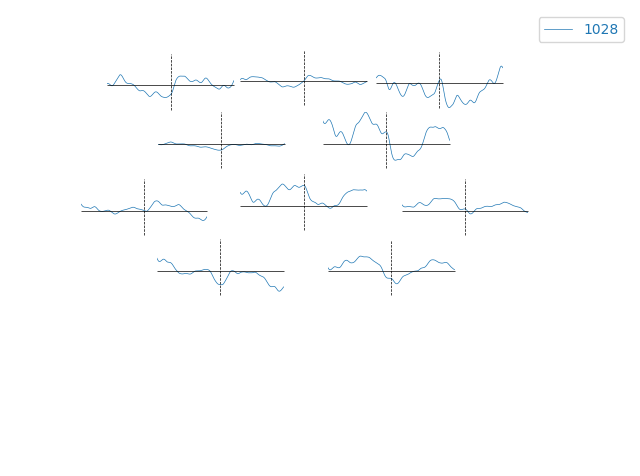

Need more than one channel to make topography for eeg. Disabling interactivity.


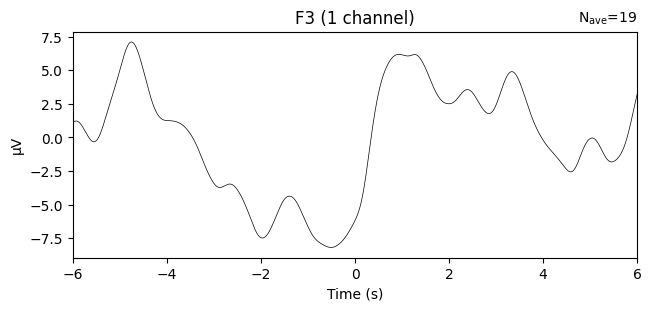

Need more than one channel to make topography for eeg. Disabling interactivity.


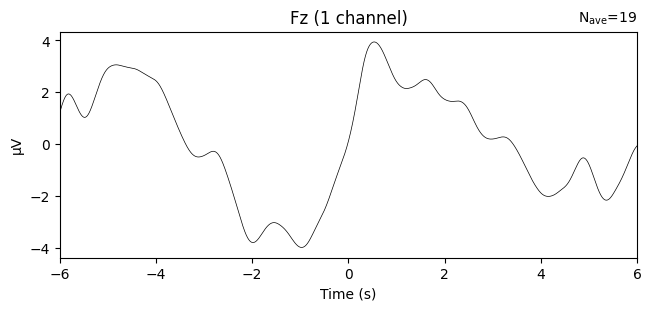

Need more than one channel to make topography for eeg. Disabling interactivity.


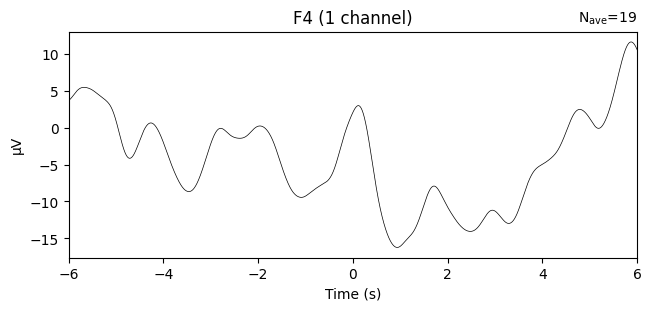

Need more than one channel to make topography for eeg. Disabling interactivity.


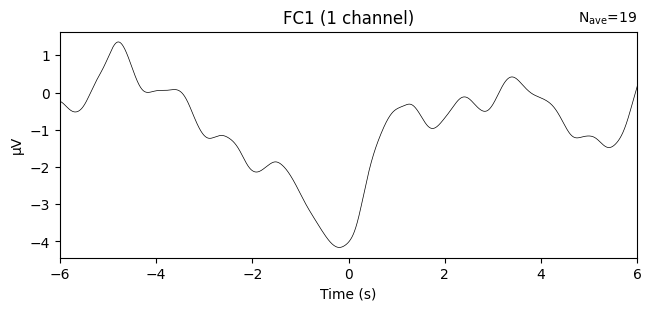

Need more than one channel to make topography for eeg. Disabling interactivity.


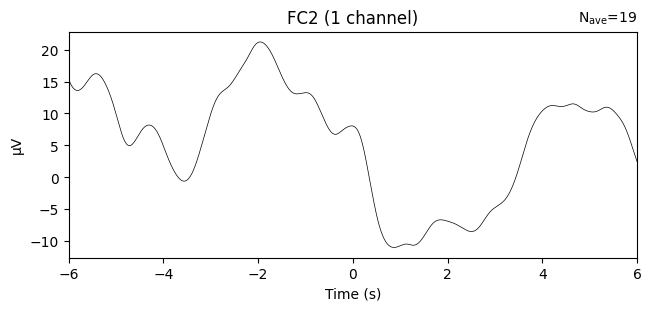

Need more than one channel to make topography for eeg. Disabling interactivity.


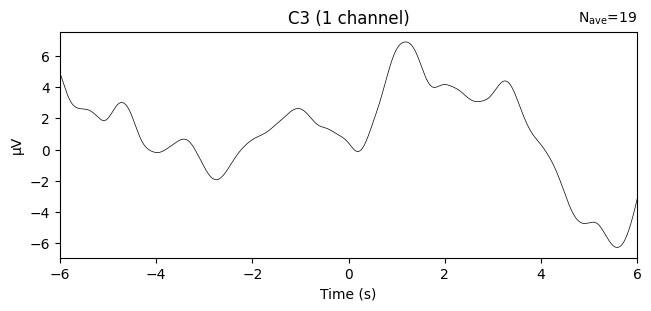

Need more than one channel to make topography for eeg. Disabling interactivity.


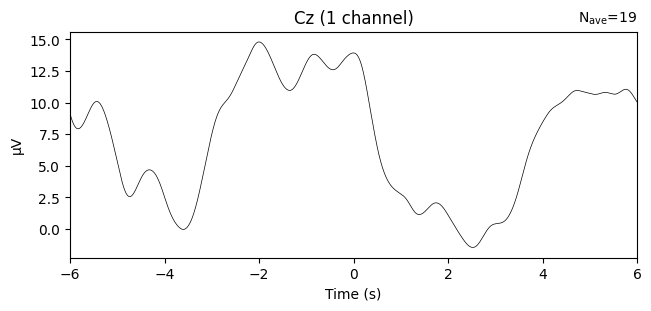

Need more than one channel to make topography for eeg. Disabling interactivity.


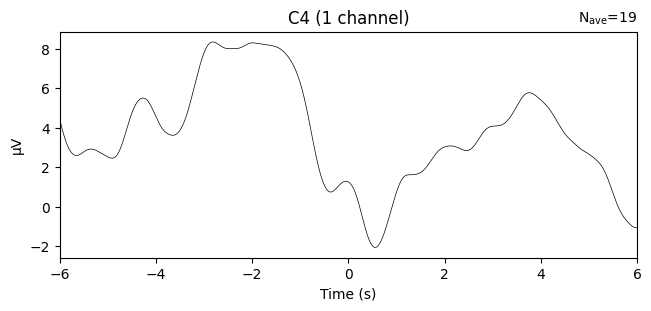

Need more than one channel to make topography for eeg. Disabling interactivity.


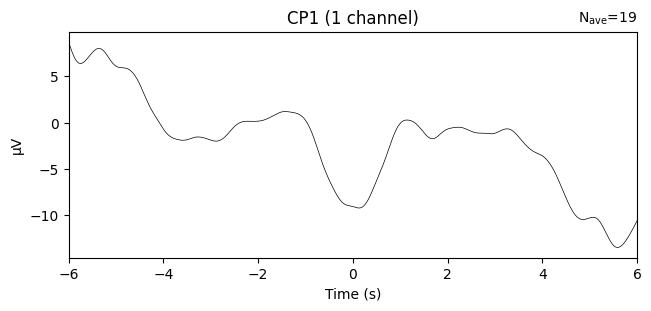

Need more than one channel to make topography for eeg. Disabling interactivity.


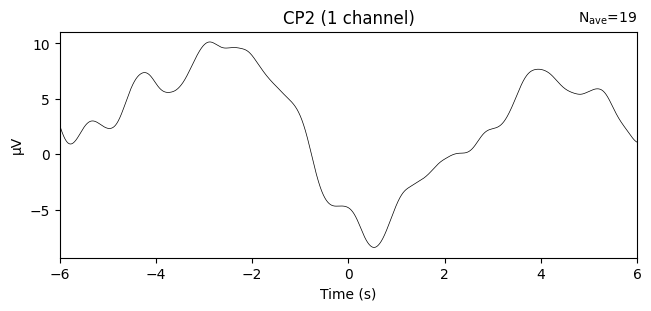

Stream 4: Calculated effective sampling rate 3869.2886 Hz is different from specified rate 100.0000 Hz.


sub-P001-Joystick_S002
Creating RawArray with float64 data, n_channels=32, n_times=146988
    Range : 0 ... 146987 =      0.000 ...   293.974 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


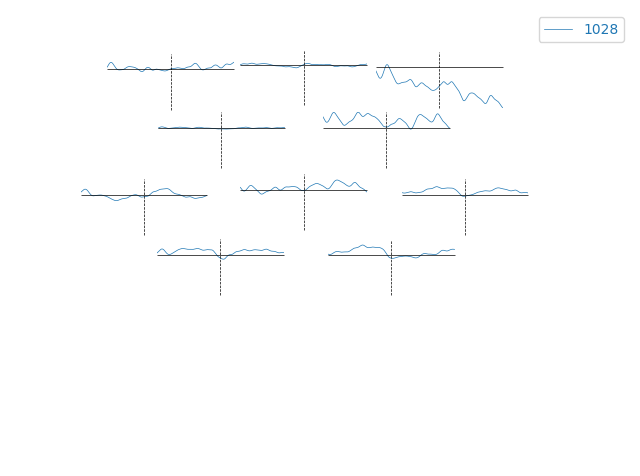

Need more than one channel to make topography for eeg. Disabling interactivity.


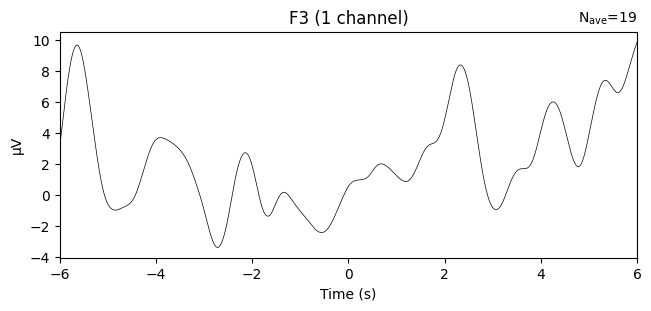

Need more than one channel to make topography for eeg. Disabling interactivity.


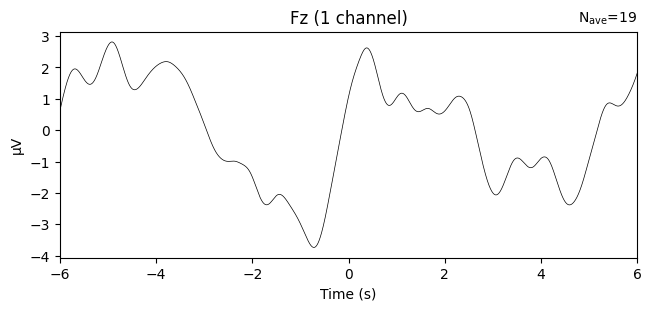

Need more than one channel to make topography for eeg. Disabling interactivity.


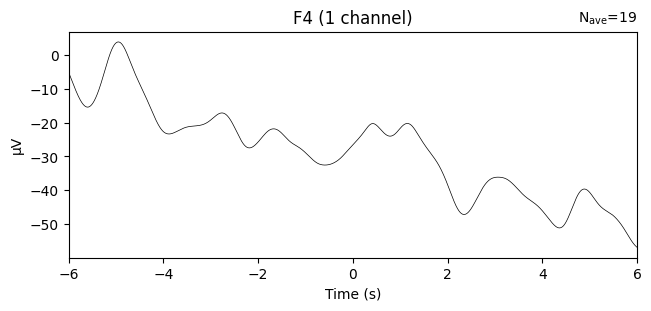

Need more than one channel to make topography for eeg. Disabling interactivity.


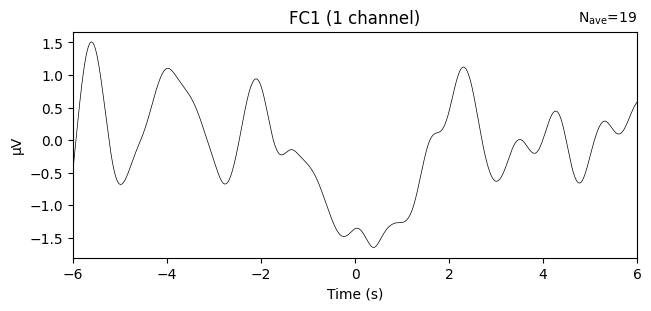

Need more than one channel to make topography for eeg. Disabling interactivity.


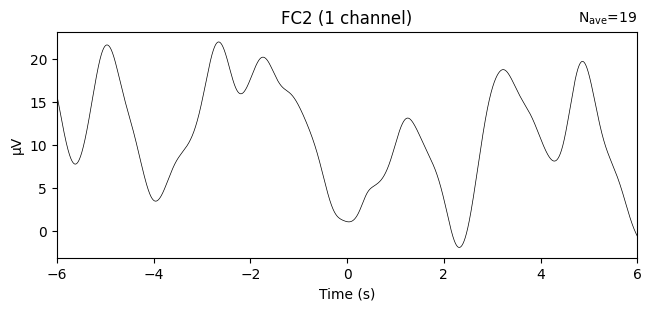

Need more than one channel to make topography for eeg. Disabling interactivity.


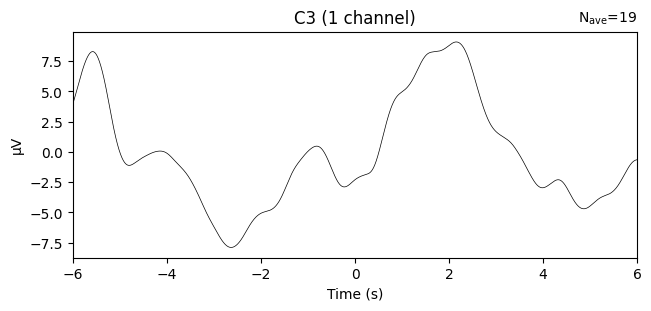

Need more than one channel to make topography for eeg. Disabling interactivity.


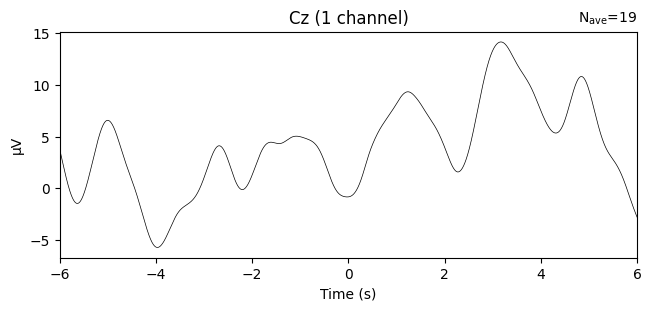

Need more than one channel to make topography for eeg. Disabling interactivity.


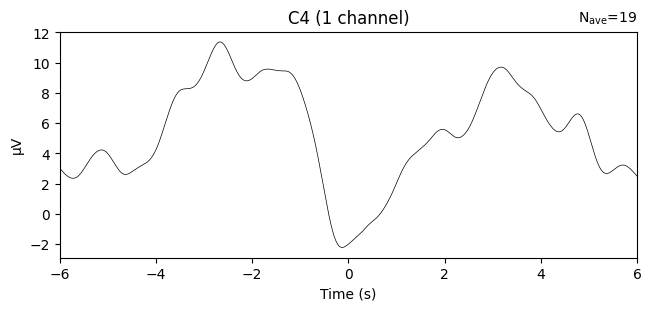

Need more than one channel to make topography for eeg. Disabling interactivity.


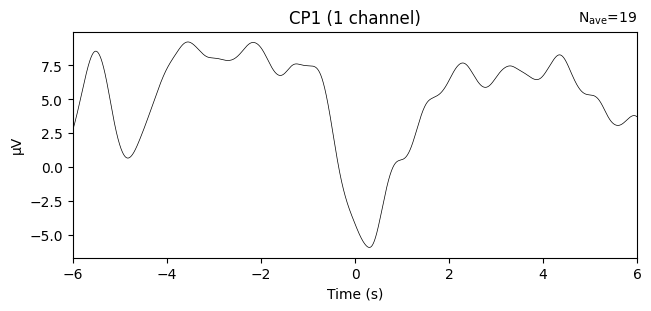

Need more than one channel to make topography for eeg. Disabling interactivity.


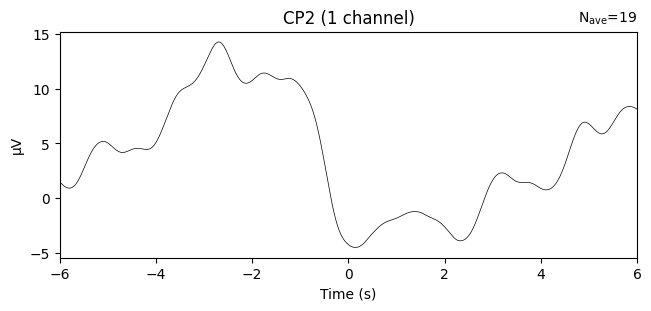

Stream 4: Calculated effective sampling rate 3867.5898 Hz is different from specified rate 100.0000 Hz.


sub-P001-Joystick_S003
Creating RawArray with float64 data, n_channels=32, n_times=132480
    Range : 0 ... 132479 =      0.000 ...   264.958 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


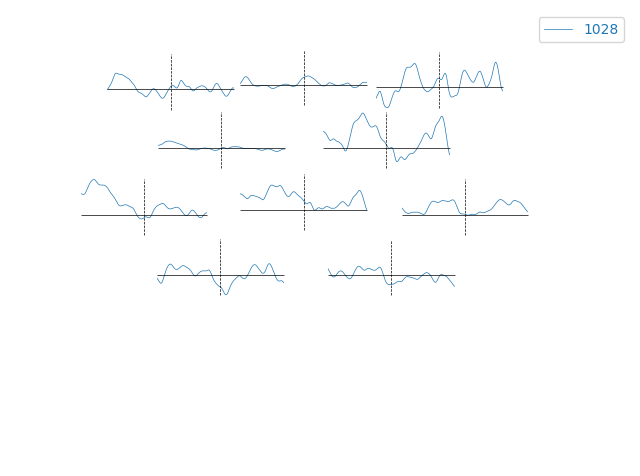

Need more than one channel to make topography for eeg. Disabling interactivity.


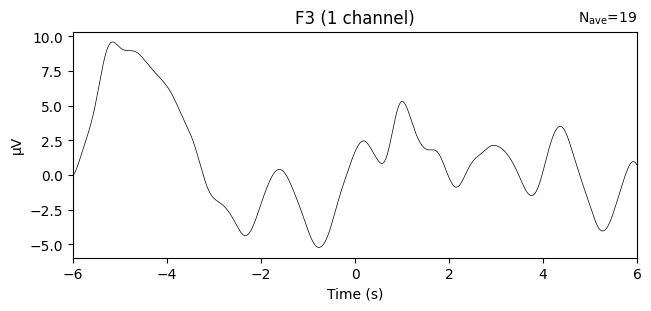

Need more than one channel to make topography for eeg. Disabling interactivity.


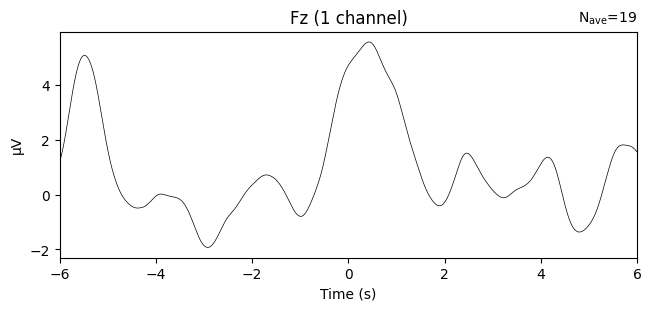

Need more than one channel to make topography for eeg. Disabling interactivity.


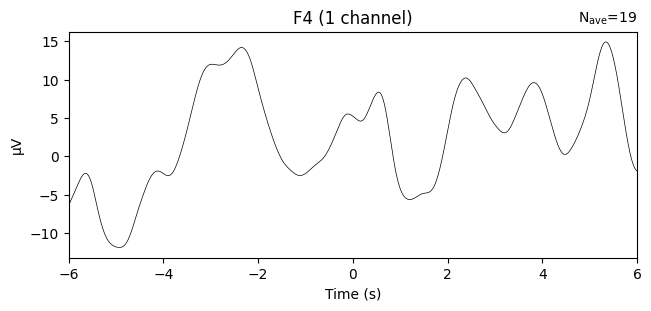

Need more than one channel to make topography for eeg. Disabling interactivity.


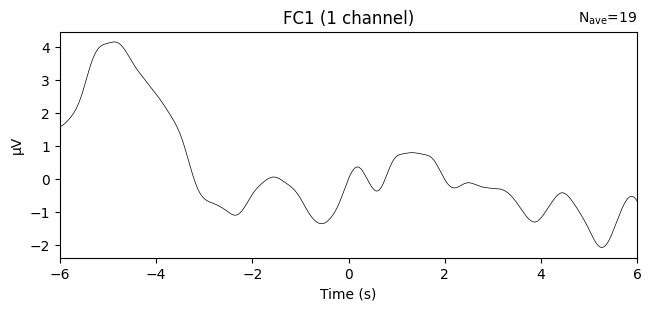

Need more than one channel to make topography for eeg. Disabling interactivity.


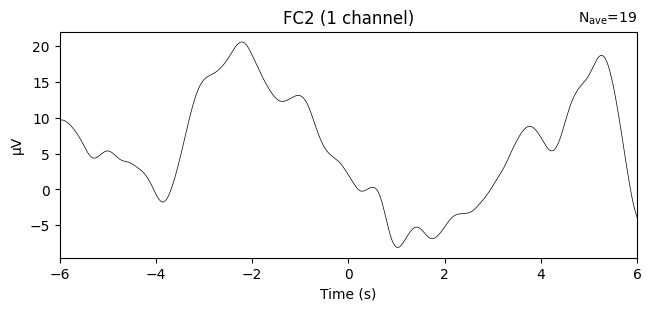

Need more than one channel to make topography for eeg. Disabling interactivity.


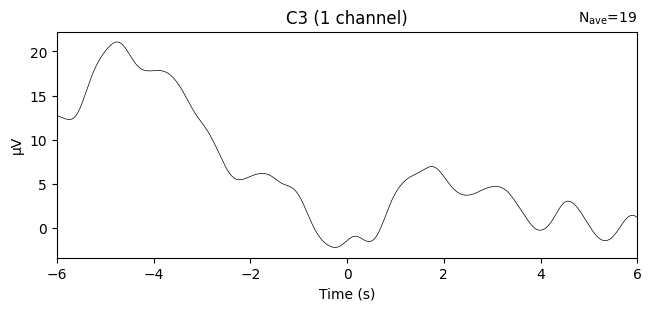

Need more than one channel to make topography for eeg. Disabling interactivity.


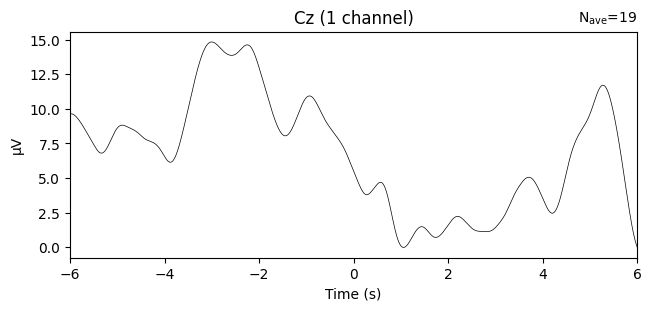

Need more than one channel to make topography for eeg. Disabling interactivity.


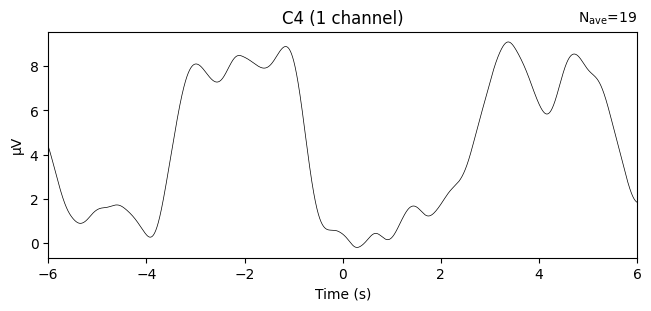

Need more than one channel to make topography for eeg. Disabling interactivity.


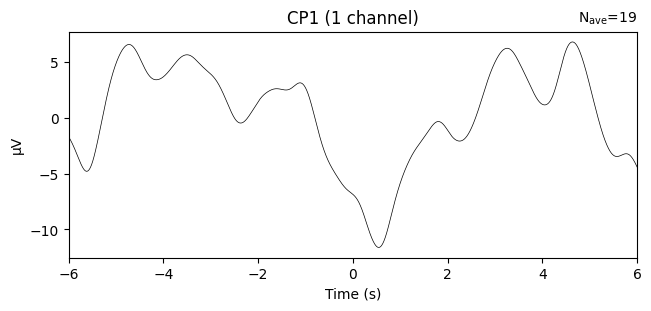

Need more than one channel to make topography for eeg. Disabling interactivity.


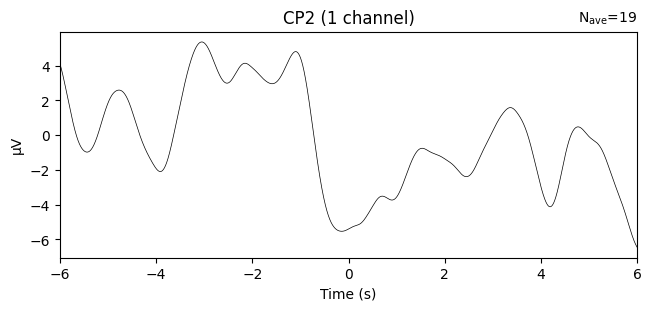

Stream 4: Calculated effective sampling rate 3868.6817 Hz is different from specified rate 100.0000 Hz.


sub-P001-Leaning_S001
Creating RawArray with float64 data, n_channels=32, n_times=190017
    Range : 0 ... 190016 =      0.000 ...   380.032 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


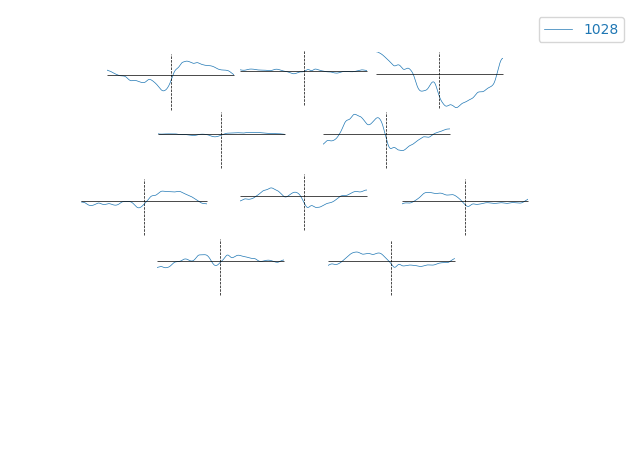

Need more than one channel to make topography for eeg. Disabling interactivity.


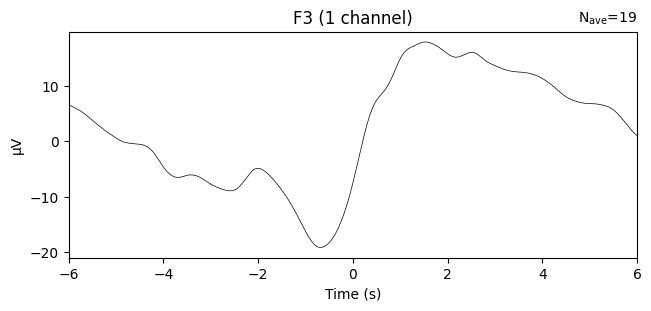

Need more than one channel to make topography for eeg. Disabling interactivity.


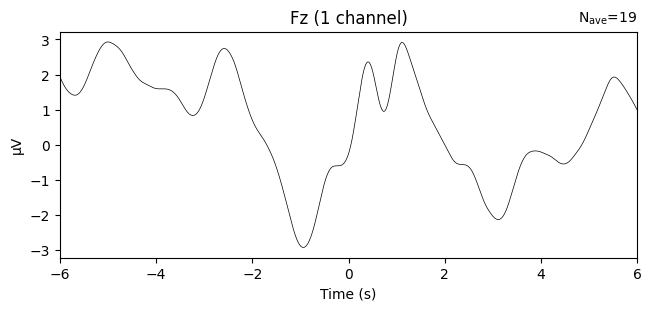

Need more than one channel to make topography for eeg. Disabling interactivity.


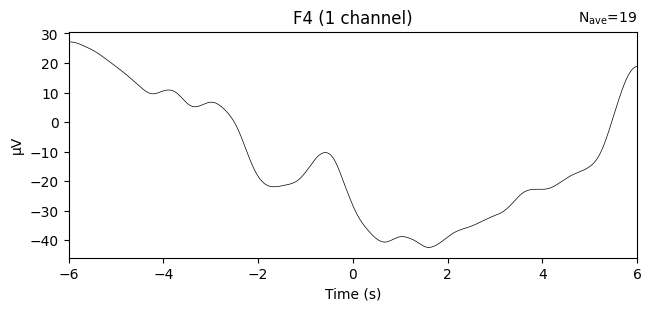

Need more than one channel to make topography for eeg. Disabling interactivity.


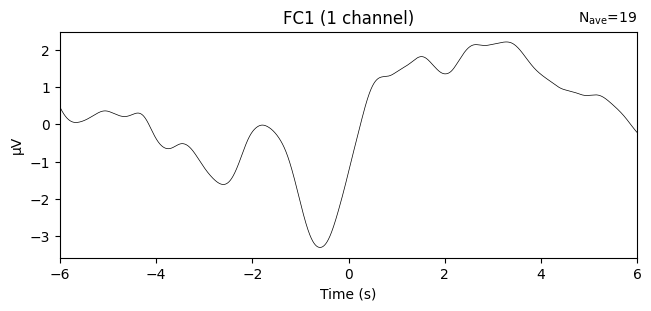

Need more than one channel to make topography for eeg. Disabling interactivity.


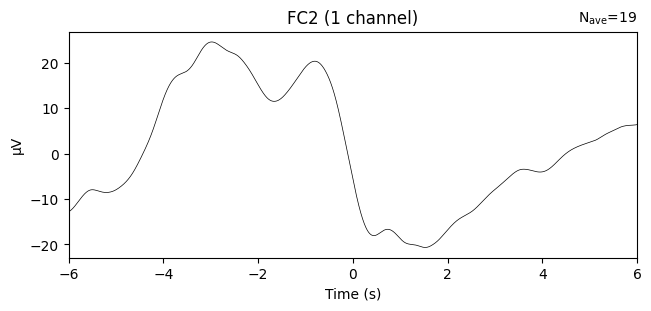

Need more than one channel to make topography for eeg. Disabling interactivity.


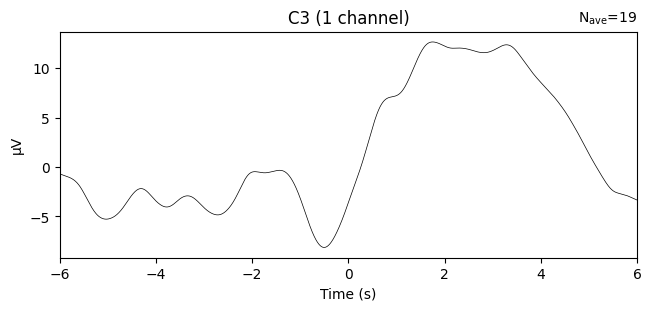

Need more than one channel to make topography for eeg. Disabling interactivity.


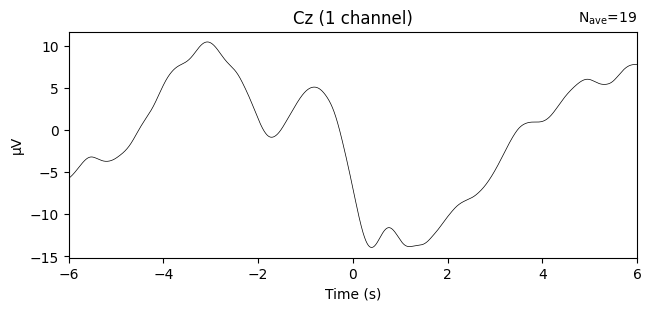

Need more than one channel to make topography for eeg. Disabling interactivity.


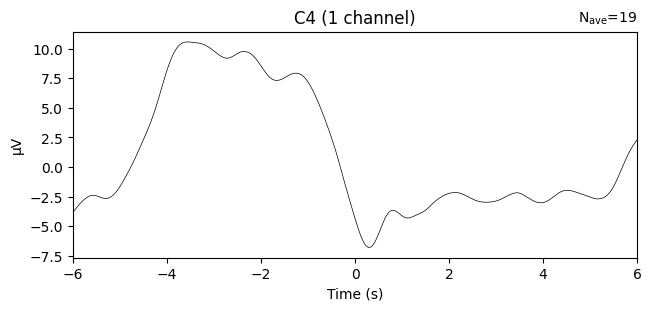

Need more than one channel to make topography for eeg. Disabling interactivity.


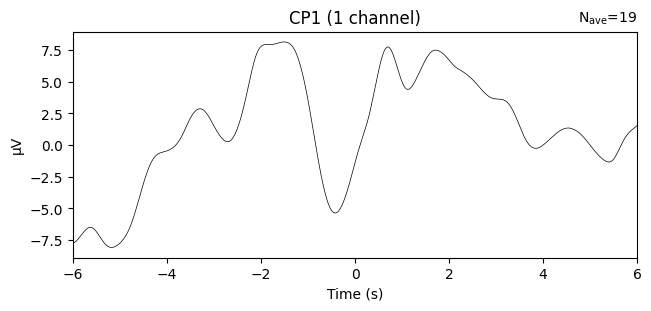

Need more than one channel to make topography for eeg. Disabling interactivity.


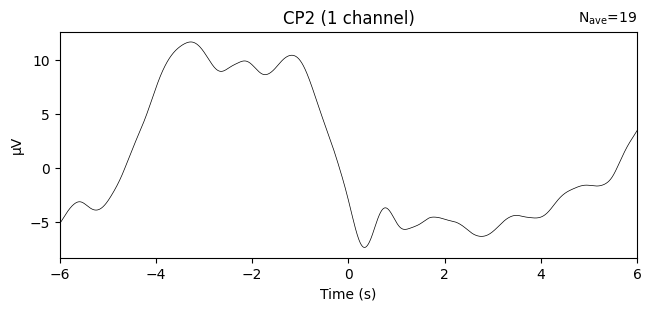

Stream 4: Calculated effective sampling rate 3877.7861 Hz is different from specified rate 100.0000 Hz.


sub-P001-Leaning_S002
Creating RawArray with float64 data, n_channels=32, n_times=172516
    Range : 0 ... 172515 =      0.000 ...   345.030 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


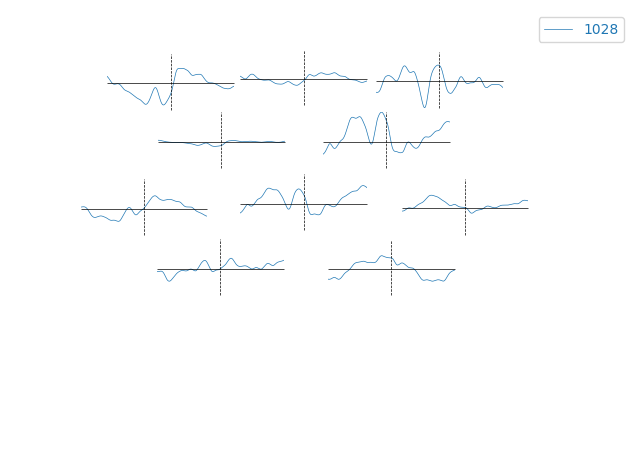

Need more than one channel to make topography for eeg. Disabling interactivity.


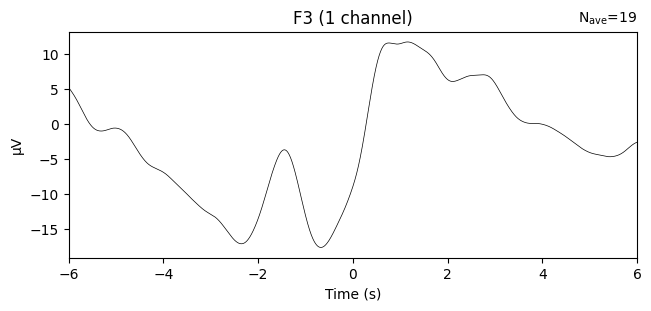

Need more than one channel to make topography for eeg. Disabling interactivity.


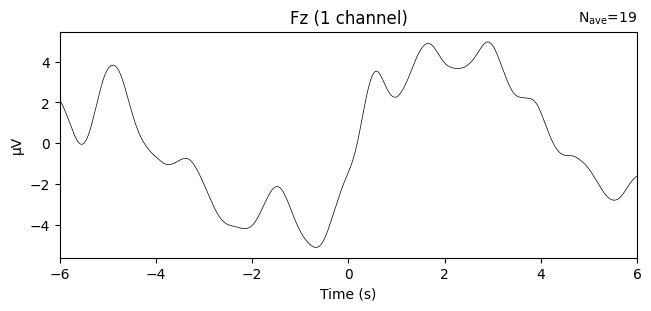

Need more than one channel to make topography for eeg. Disabling interactivity.


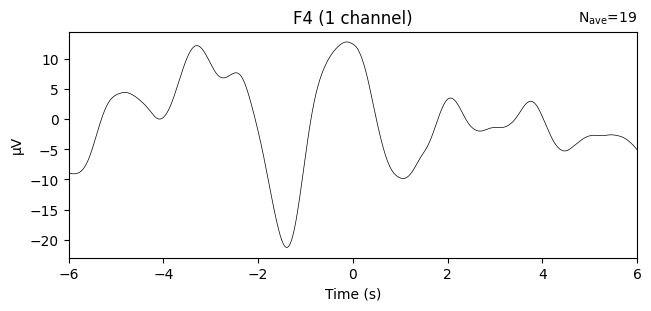

Need more than one channel to make topography for eeg. Disabling interactivity.


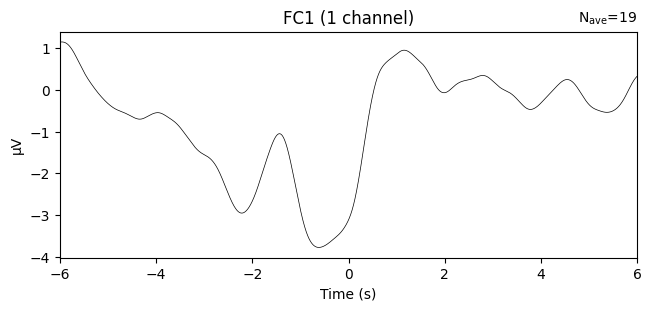

Need more than one channel to make topography for eeg. Disabling interactivity.


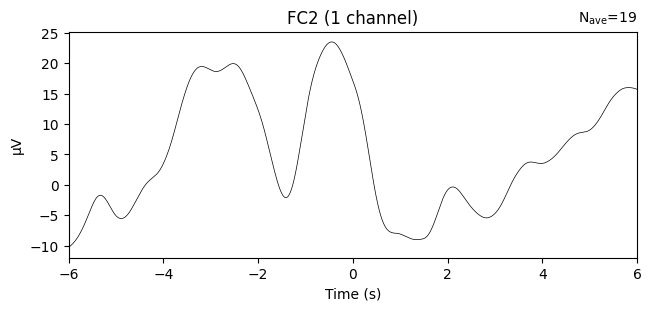

Need more than one channel to make topography for eeg. Disabling interactivity.


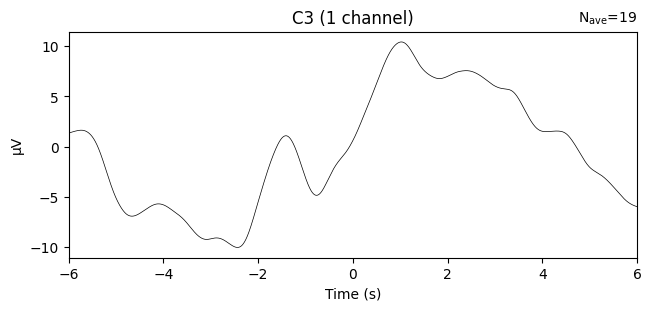

Need more than one channel to make topography for eeg. Disabling interactivity.


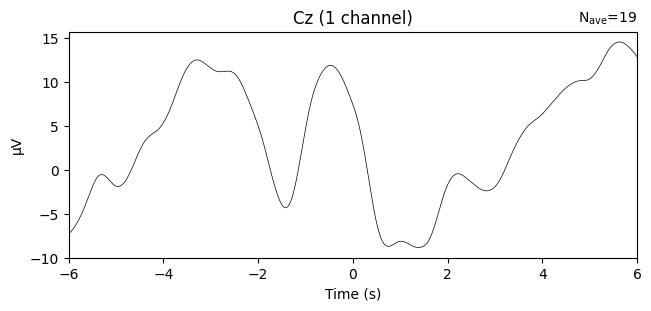

Need more than one channel to make topography for eeg. Disabling interactivity.


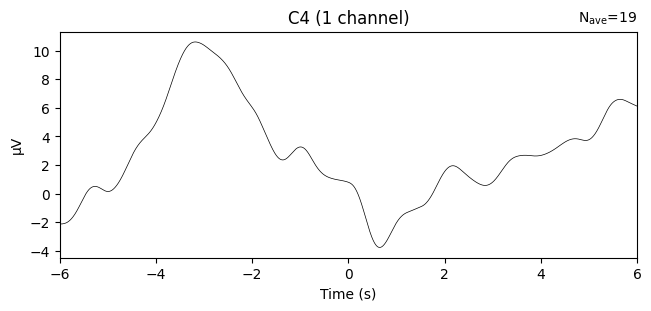

Need more than one channel to make topography for eeg. Disabling interactivity.


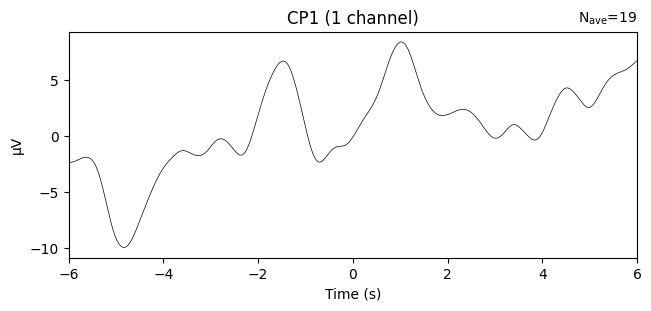

Need more than one channel to make topography for eeg. Disabling interactivity.


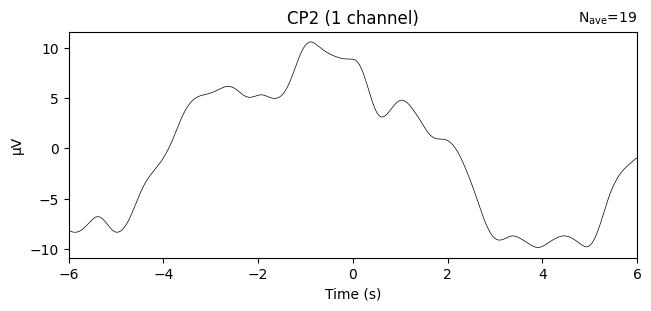

Stream 4: Calculated effective sampling rate 3880.4282 Hz is different from specified rate 100.0000 Hz.


sub-P001-Leaning_S003
Creating RawArray with float64 data, n_channels=32, n_times=185554
    Range : 0 ... 185553 =      0.000 ...   371.106 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


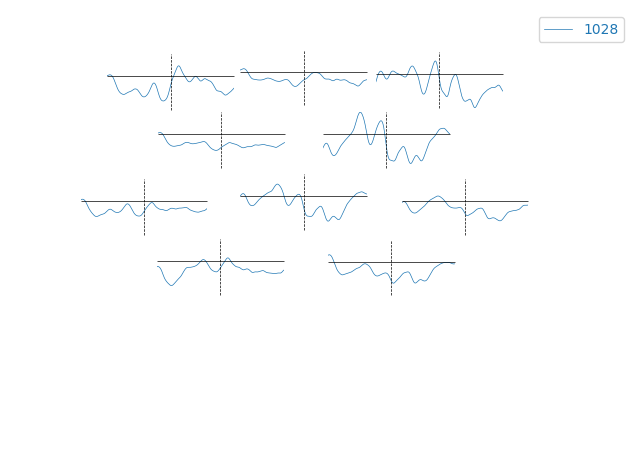

Need more than one channel to make topography for eeg. Disabling interactivity.


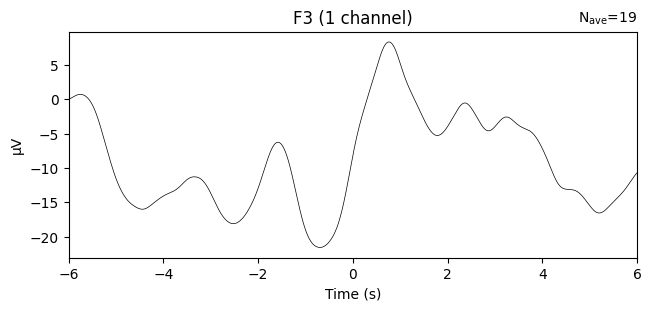

Need more than one channel to make topography for eeg. Disabling interactivity.


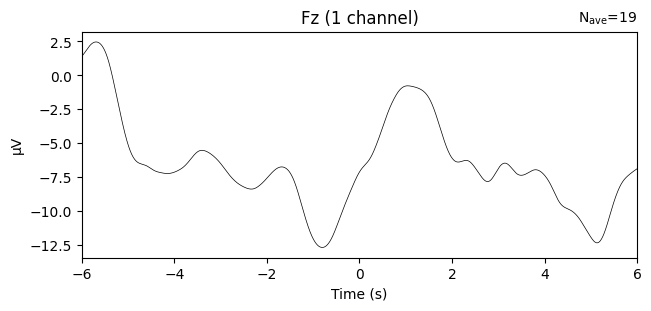

Need more than one channel to make topography for eeg. Disabling interactivity.


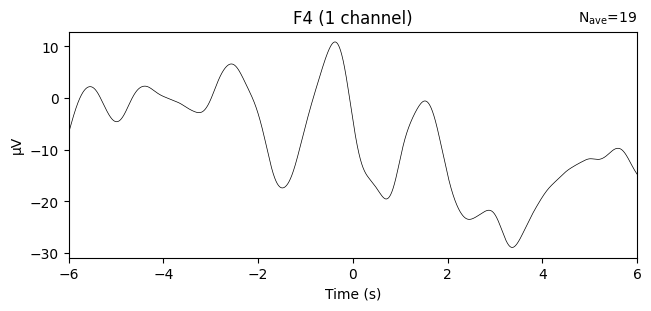

Need more than one channel to make topography for eeg. Disabling interactivity.


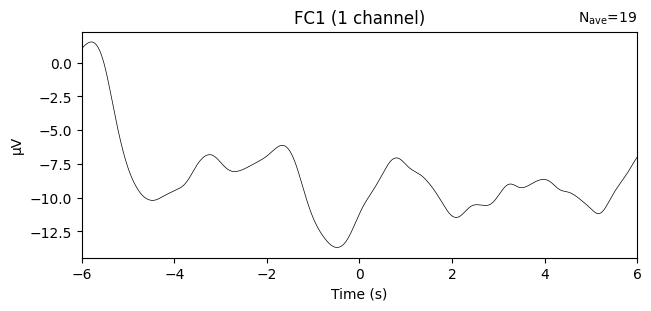

Need more than one channel to make topography for eeg. Disabling interactivity.


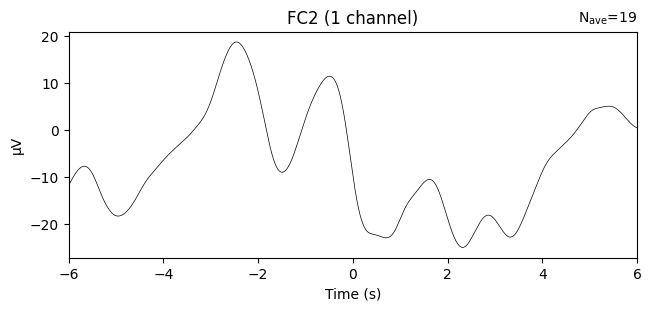

Need more than one channel to make topography for eeg. Disabling interactivity.


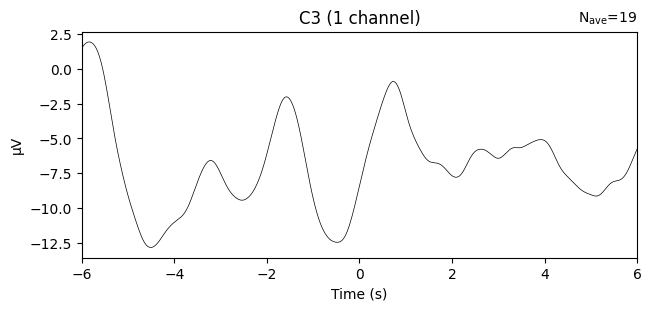

Need more than one channel to make topography for eeg. Disabling interactivity.


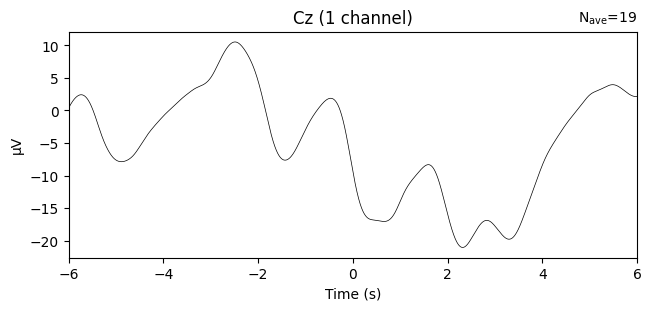

Need more than one channel to make topography for eeg. Disabling interactivity.


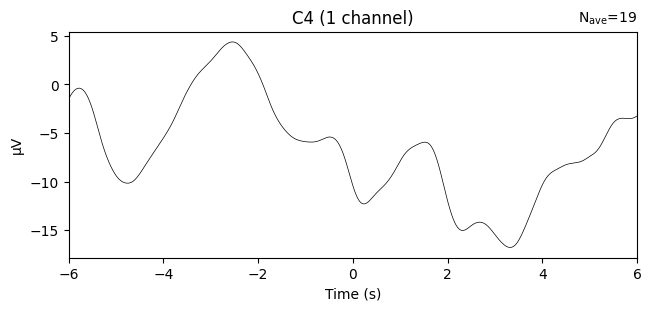

Need more than one channel to make topography for eeg. Disabling interactivity.


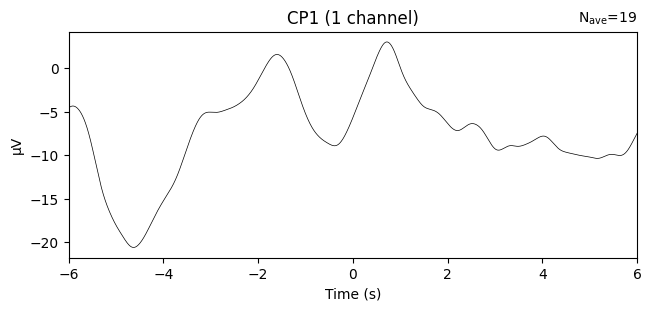

Need more than one channel to make topography for eeg. Disabling interactivity.


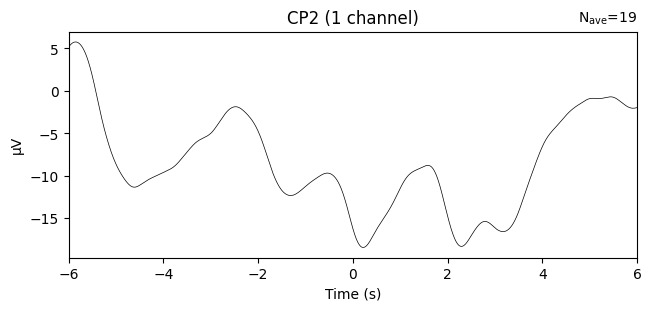

Stream 1: Calculated effective sampling rate 3855.1314 Hz is different from specified rate 100.0000 Hz.


sub-P001-Omnideck_S002
Creating RawArray with float64 data, n_channels=32, n_times=168545
    Range : 0 ... 168544 =      0.000 ...   337.088 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped


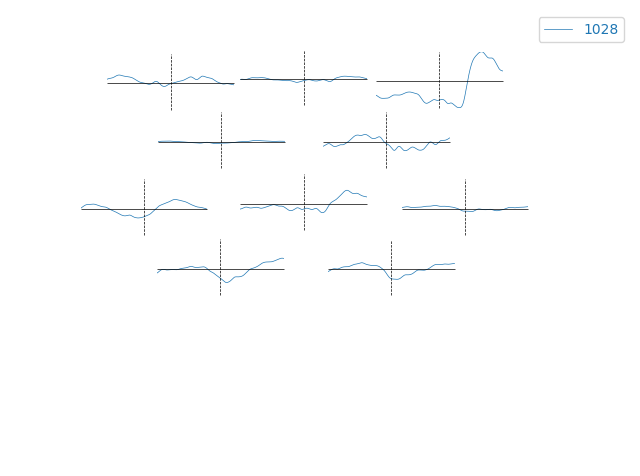

Need more than one channel to make topography for eeg. Disabling interactivity.


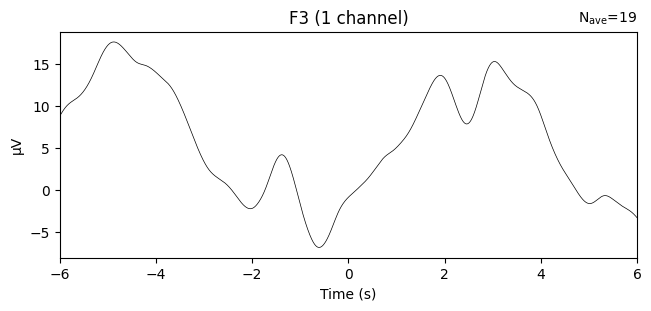

Need more than one channel to make topography for eeg. Disabling interactivity.


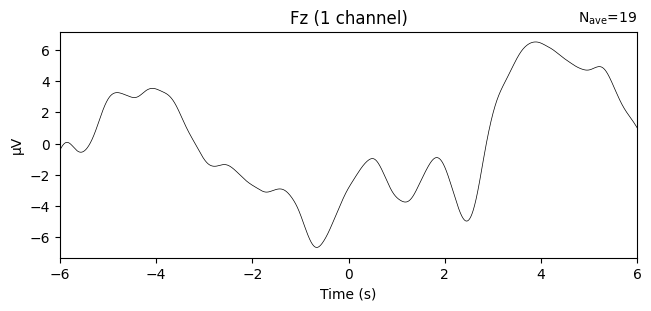

Need more than one channel to make topography for eeg. Disabling interactivity.


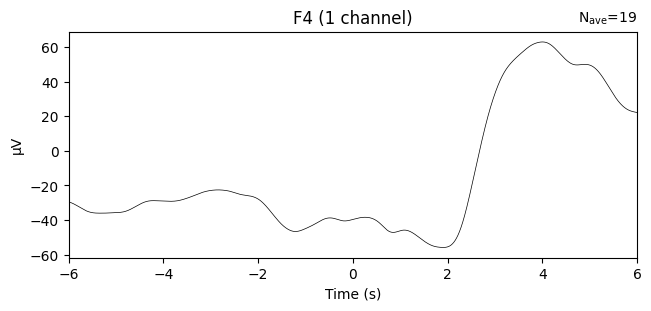

Need more than one channel to make topography for eeg. Disabling interactivity.


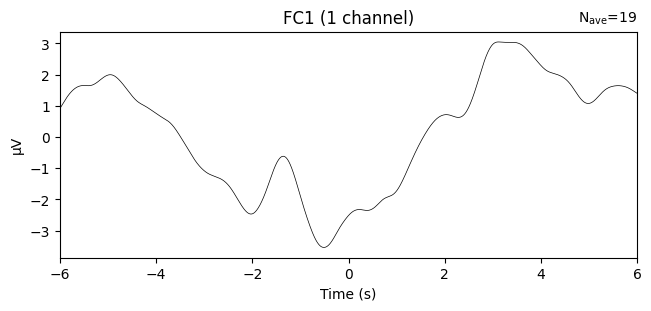

Need more than one channel to make topography for eeg. Disabling interactivity.


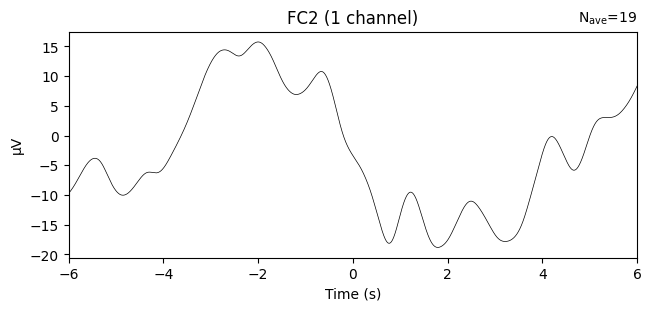

Need more than one channel to make topography for eeg. Disabling interactivity.


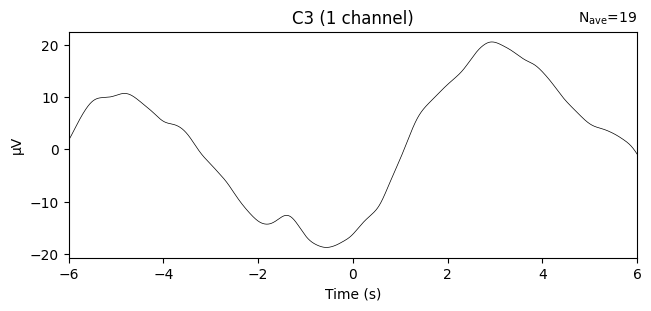

Need more than one channel to make topography for eeg. Disabling interactivity.


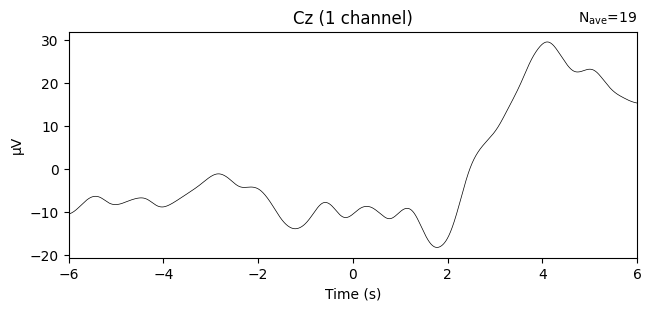

Need more than one channel to make topography for eeg. Disabling interactivity.


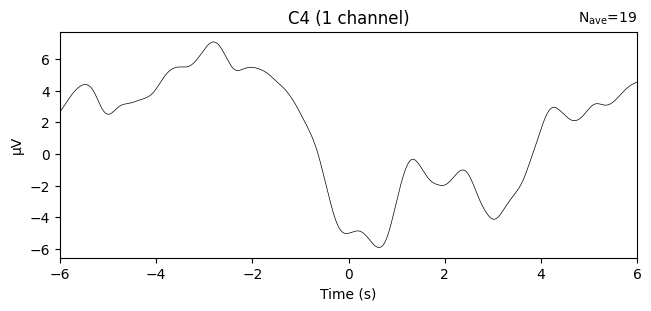

Need more than one channel to make topography for eeg. Disabling interactivity.


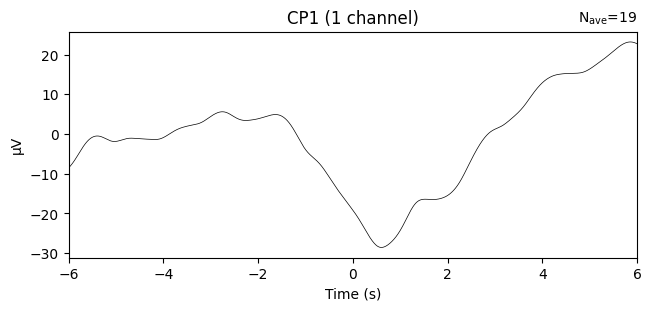

Need more than one channel to make topography for eeg. Disabling interactivity.


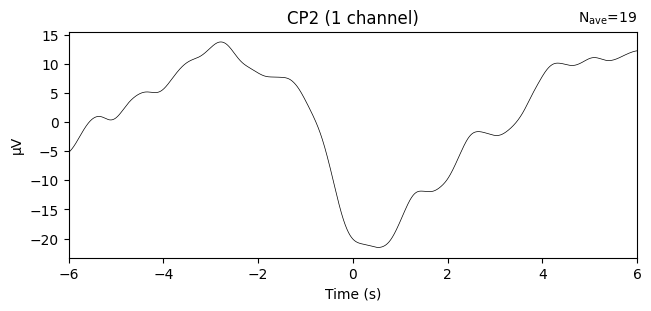

Stream 4: Calculated effective sampling rate 3860.9512 Hz is different from specified rate 100.0000 Hz.


sub-P001-Omnideck_S003
Creating RawArray with float64 data, n_channels=32, n_times=170747
    Range : 0 ... 170746 =      0.000 ...   341.492 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


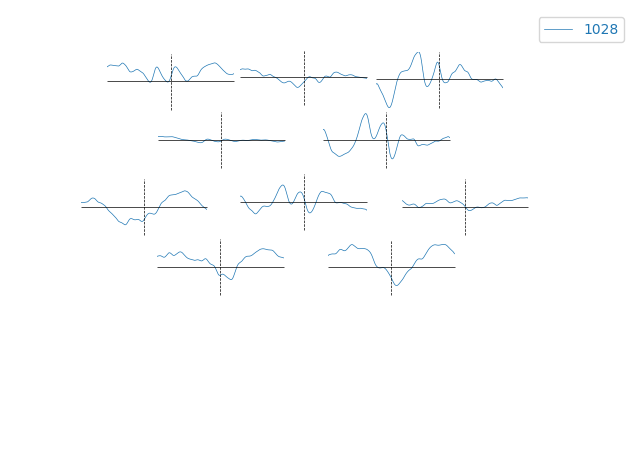

Need more than one channel to make topography for eeg. Disabling interactivity.


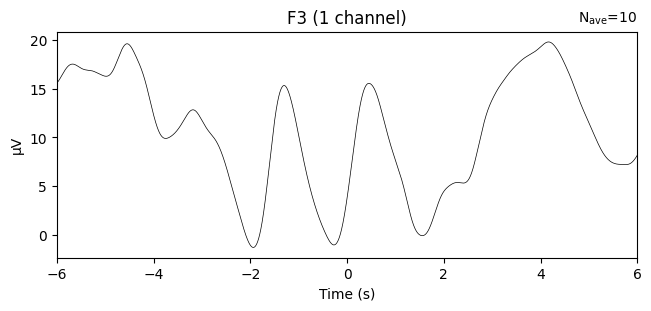

Need more than one channel to make topography for eeg. Disabling interactivity.


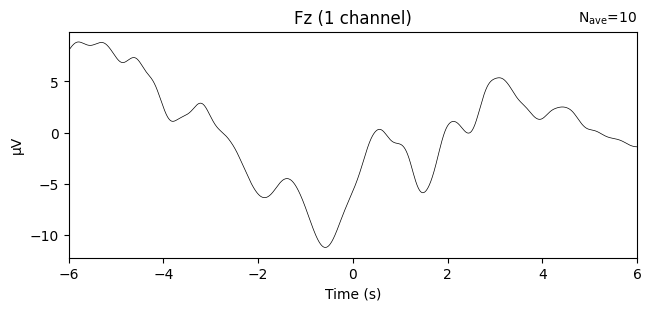

Need more than one channel to make topography for eeg. Disabling interactivity.


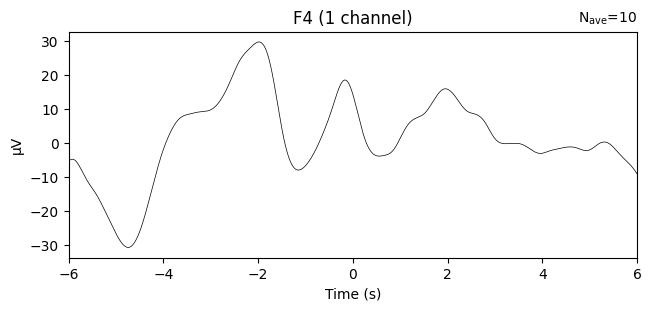

Need more than one channel to make topography for eeg. Disabling interactivity.


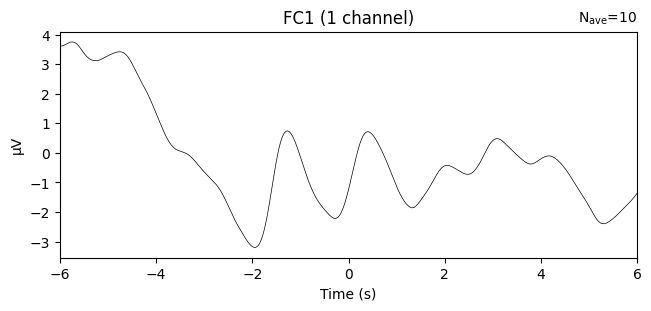

Need more than one channel to make topography for eeg. Disabling interactivity.


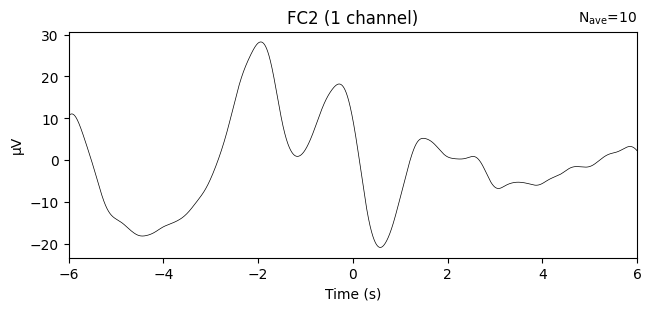

Need more than one channel to make topography for eeg. Disabling interactivity.


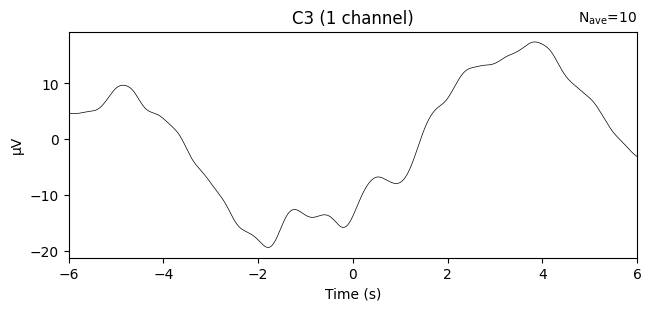

Need more than one channel to make topography for eeg. Disabling interactivity.


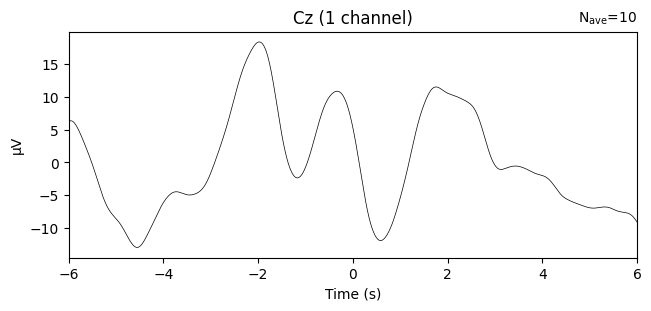

Need more than one channel to make topography for eeg. Disabling interactivity.


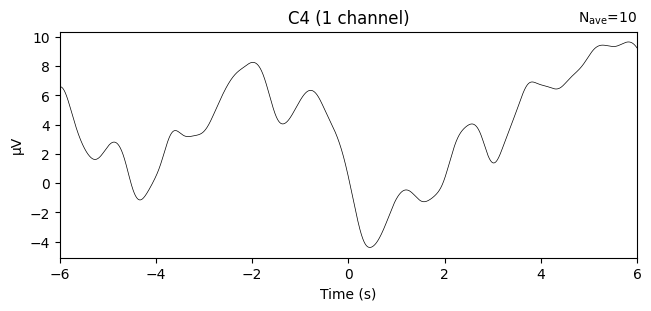

Need more than one channel to make topography for eeg. Disabling interactivity.


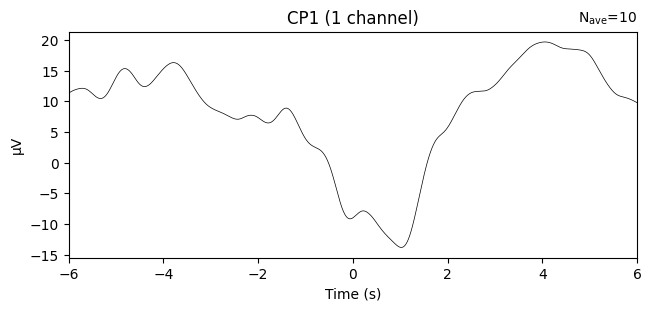

Need more than one channel to make topography for eeg. Disabling interactivity.


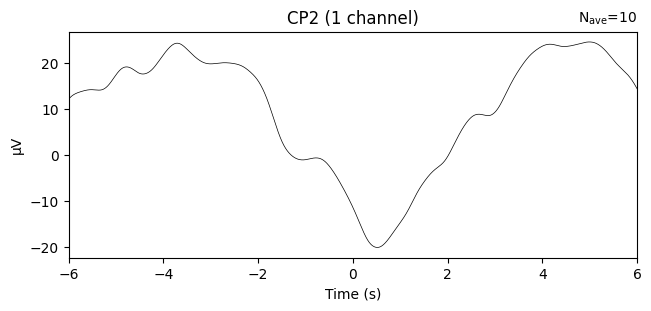

Stream 4: Calculated effective sampling rate 3880.4616 Hz is different from specified rate 100.0000 Hz.


sub-P001-Walking_S001
Creating RawArray with float64 data, n_channels=32, n_times=105163
    Range : 0 ... 105162 =      0.000 ...   210.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0

C:\Users\stadl\AppData\Local\Temp\ipykernel_1168\1560601719.py:87: RuntimeWarning: Omitted 191 annotation(s) that were outside data range.
  raw.set_annotations(annotations)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


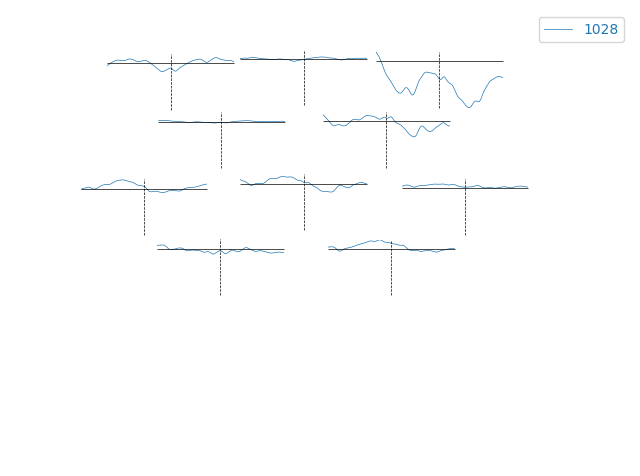

Need more than one channel to make topography for eeg. Disabling interactivity.


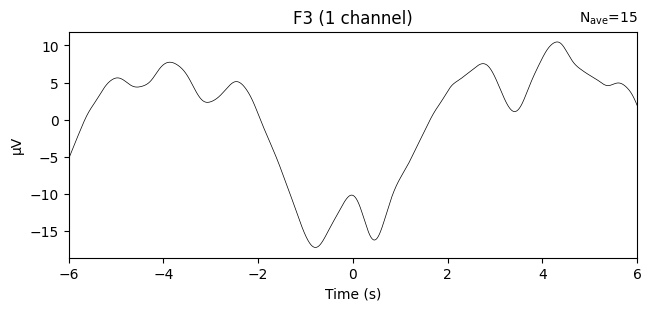

Need more than one channel to make topography for eeg. Disabling interactivity.


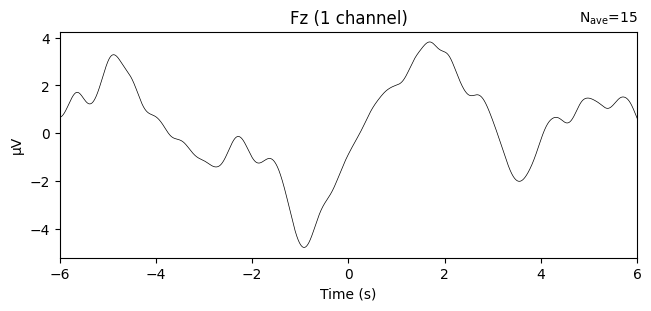

Need more than one channel to make topography for eeg. Disabling interactivity.


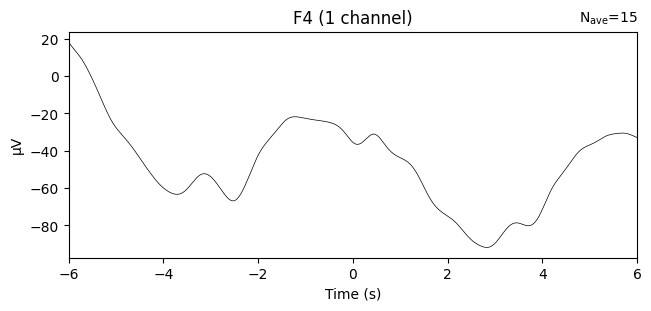

Need more than one channel to make topography for eeg. Disabling interactivity.


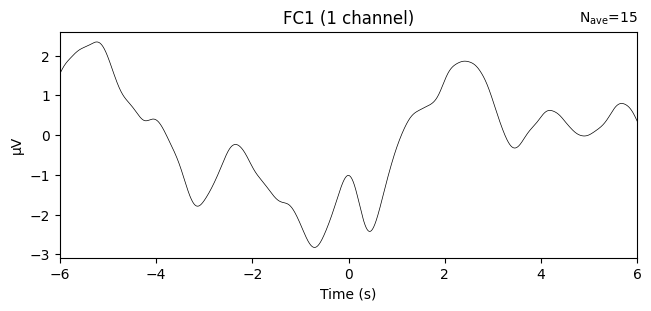

Need more than one channel to make topography for eeg. Disabling interactivity.


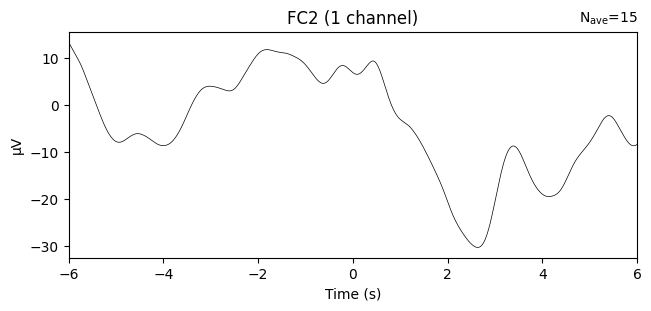

Need more than one channel to make topography for eeg. Disabling interactivity.


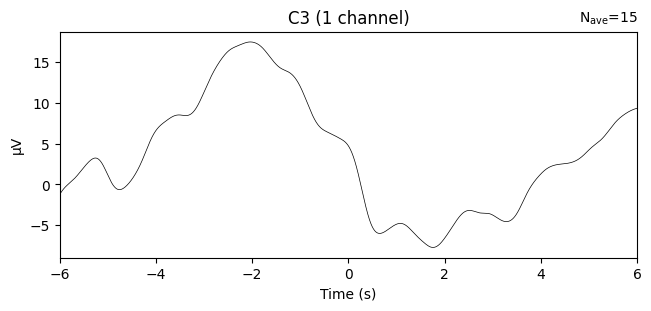

Need more than one channel to make topography for eeg. Disabling interactivity.


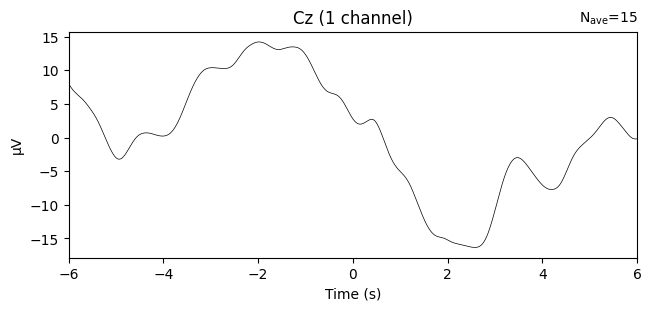

Need more than one channel to make topography for eeg. Disabling interactivity.


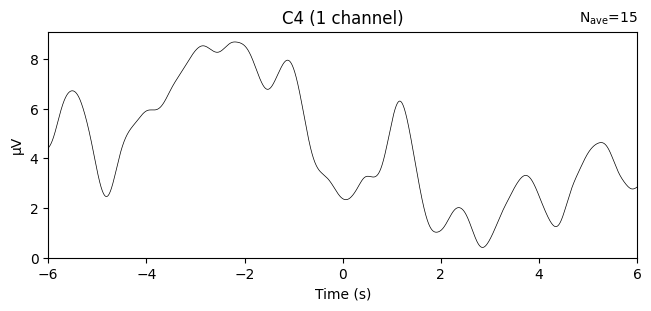

Need more than one channel to make topography for eeg. Disabling interactivity.


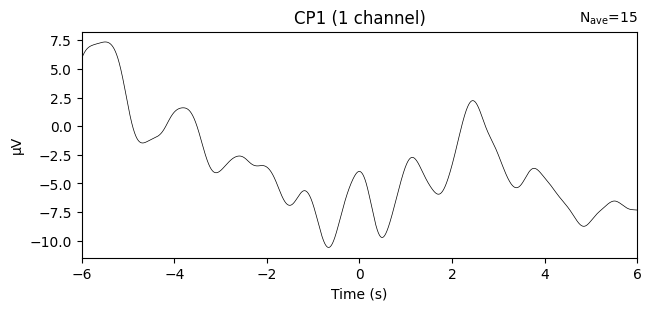

Need more than one channel to make topography for eeg. Disabling interactivity.


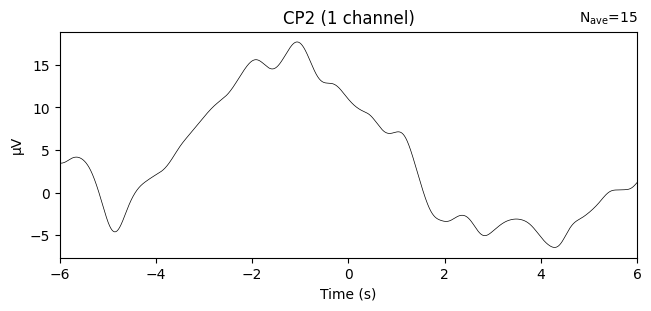

Stream 3: Calculated effective sampling rate 3883.5396 Hz is different from specified rate 100.0000 Hz.


sub-P001-Walking_S002
Creating RawArray with float64 data, n_channels=32, n_times=133241
    Range : 0 ... 133240 =      0.000 ...   266.480 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


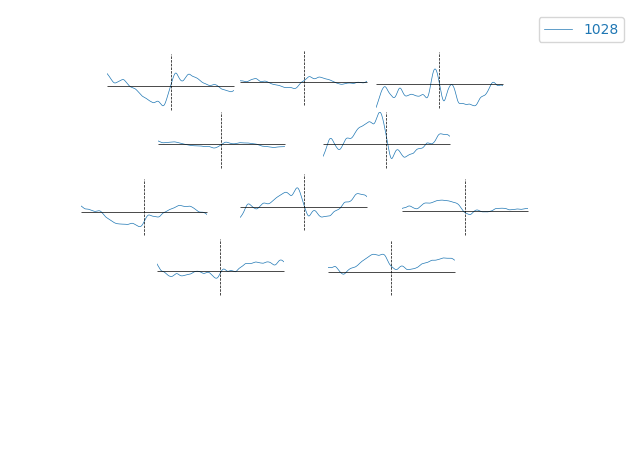

Need more than one channel to make topography for eeg. Disabling interactivity.


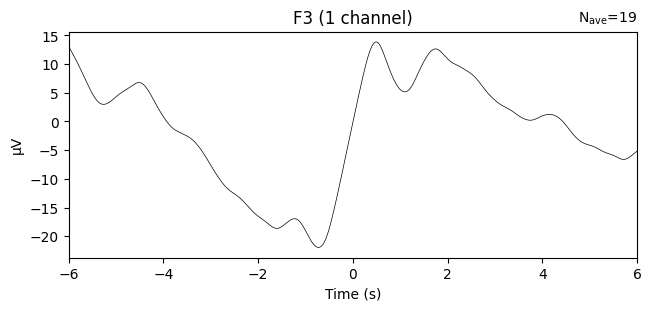

Need more than one channel to make topography for eeg. Disabling interactivity.


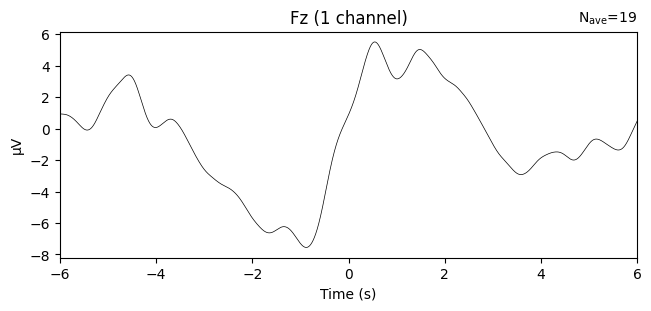

Need more than one channel to make topography for eeg. Disabling interactivity.


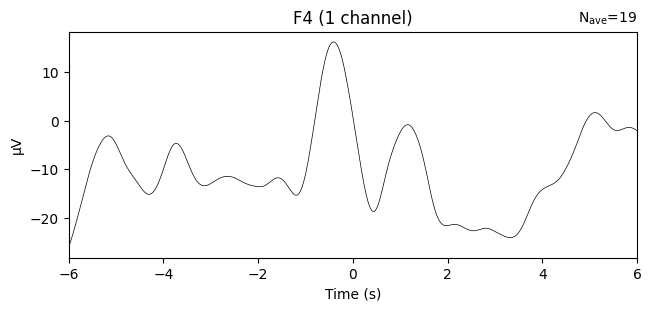

Need more than one channel to make topography for eeg. Disabling interactivity.


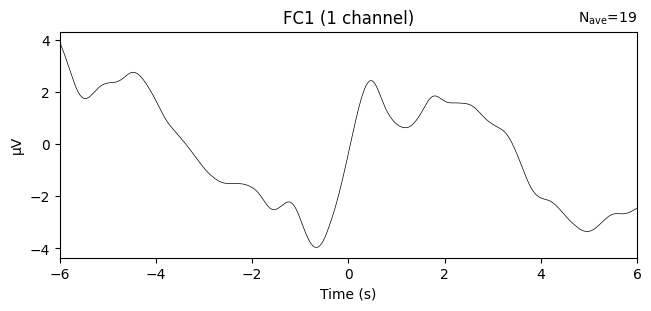

Need more than one channel to make topography for eeg. Disabling interactivity.


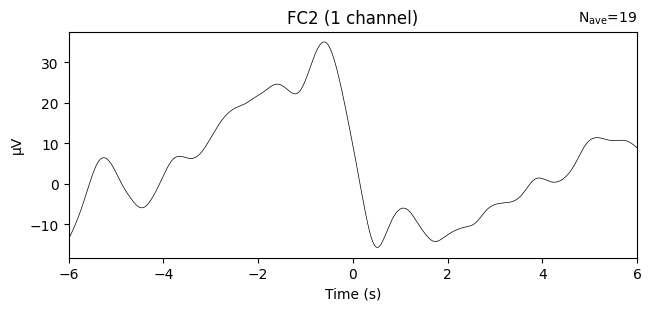

Need more than one channel to make topography for eeg. Disabling interactivity.


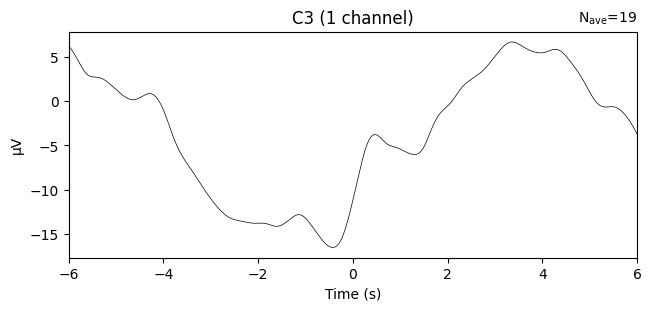

Need more than one channel to make topography for eeg. Disabling interactivity.


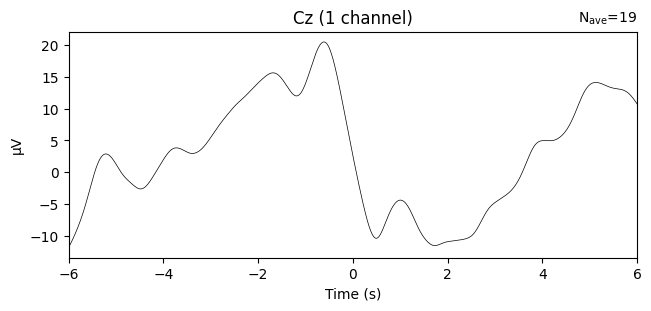

Need more than one channel to make topography for eeg. Disabling interactivity.


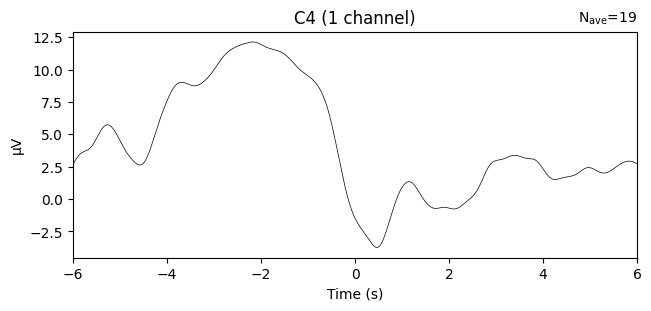

Need more than one channel to make topography for eeg. Disabling interactivity.


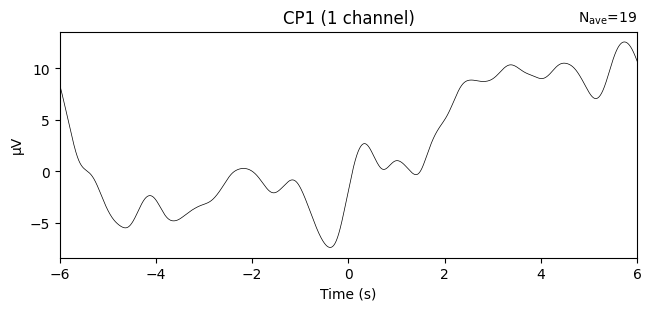

Need more than one channel to make topography for eeg. Disabling interactivity.


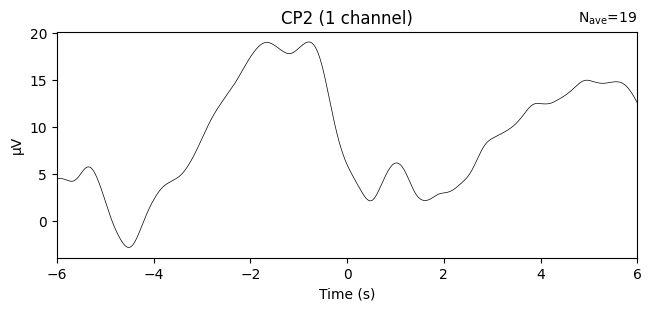

found likely XDF file corruption (no element found: line 1, column 667), ignoring corrupted XML element in footer.
Stream 3: Calculated effective sampling rate 3890.0385 Hz is different from specified rate 100.0000 Hz.


sub-P001-Walking_S003
Creating RawArray with float64 data, n_channels=32, n_times=105133
    Range : 0 ... 105132 =      0.000 ...   210.264 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



C:\Users\stadl\AppData\Local\Temp\ipykernel_1168\1560601719.py:87: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  raw.set_annotations(annotations)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('10

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


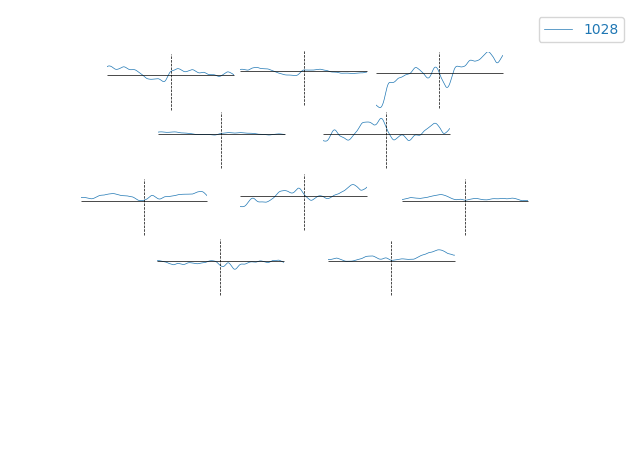

Need more than one channel to make topography for eeg. Disabling interactivity.


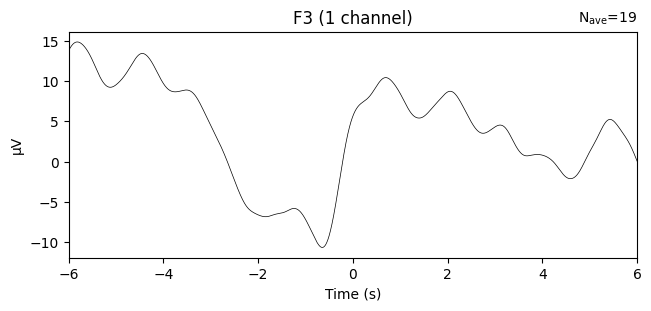

Need more than one channel to make topography for eeg. Disabling interactivity.


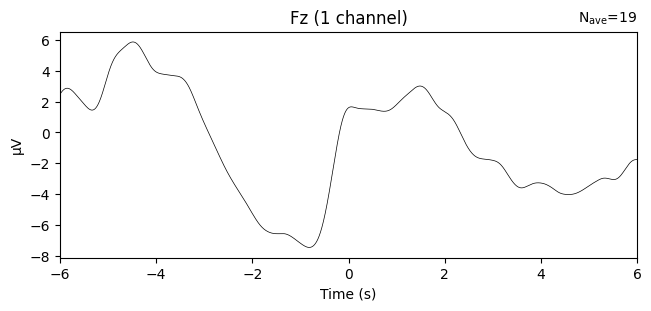

Need more than one channel to make topography for eeg. Disabling interactivity.


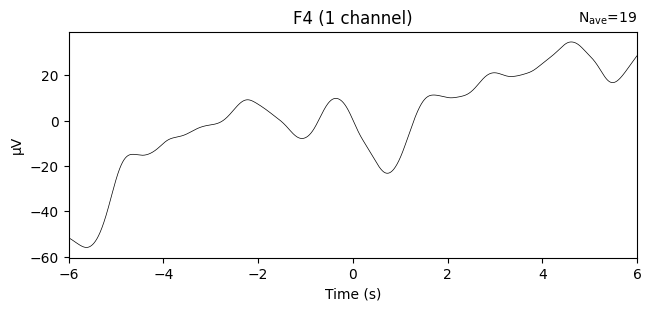

Need more than one channel to make topography for eeg. Disabling interactivity.


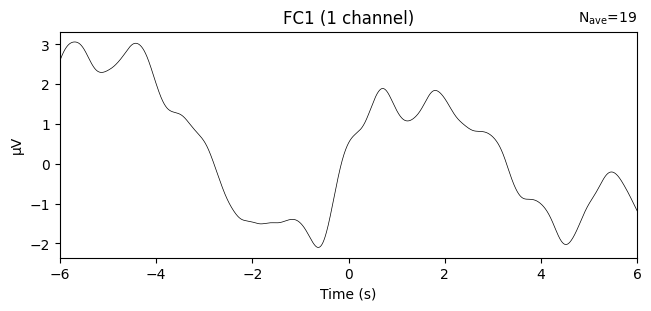

Need more than one channel to make topography for eeg. Disabling interactivity.


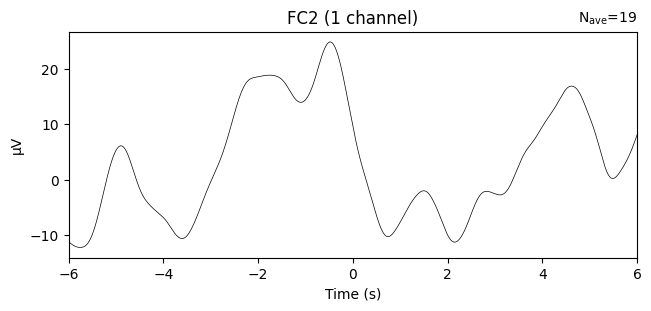

Need more than one channel to make topography for eeg. Disabling interactivity.


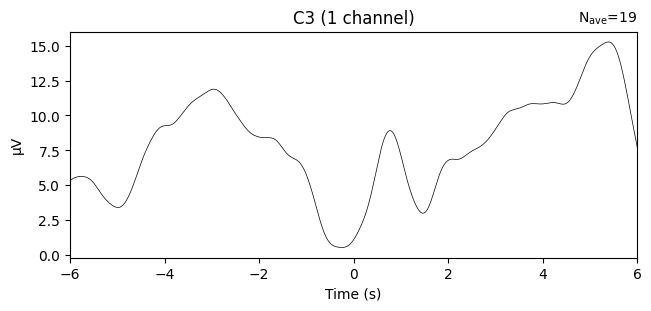

Need more than one channel to make topography for eeg. Disabling interactivity.


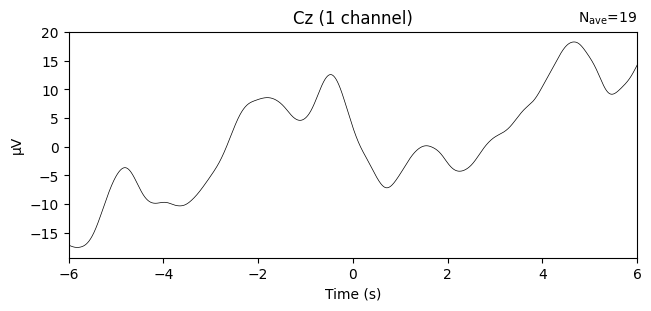

Need more than one channel to make topography for eeg. Disabling interactivity.


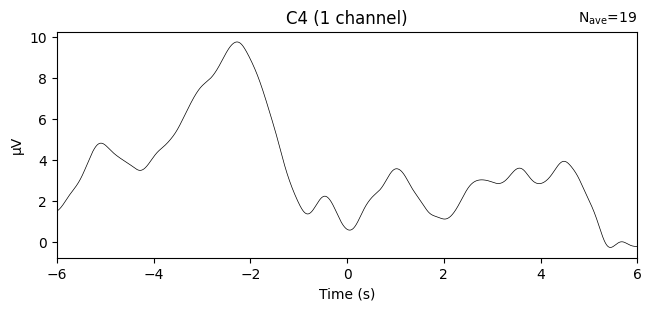

Need more than one channel to make topography for eeg. Disabling interactivity.


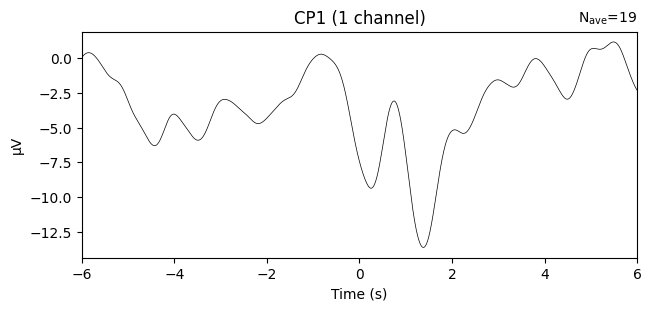

Need more than one channel to make topography for eeg. Disabling interactivity.


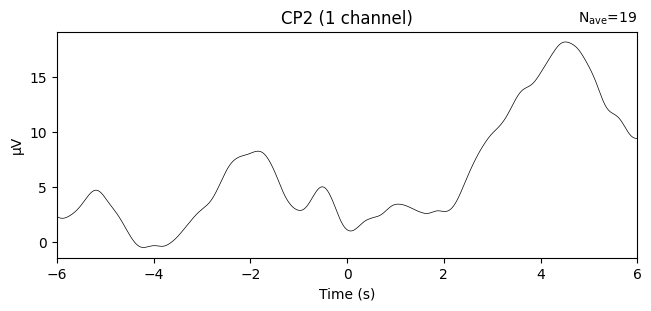

Stream 2: Calculated effective sampling rate 3844.7718 Hz is different from specified rate 100.0000 Hz.


sub-P104-Joystick_S001
Creating RawArray with float64 data, n_channels=32, n_times=246785
    Range : 0 ... 246784 =      0.000 ...   493.568 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


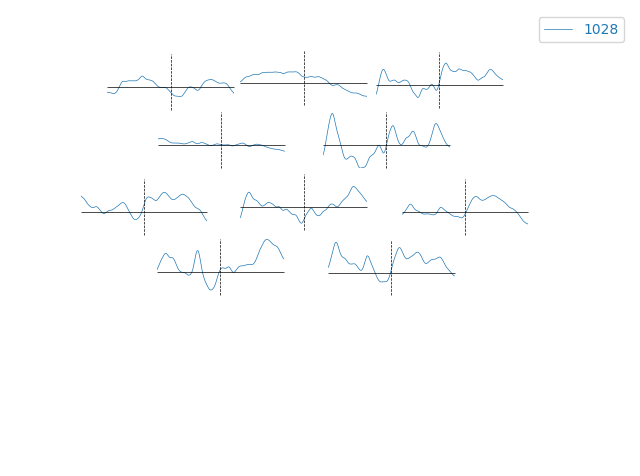

Need more than one channel to make topography for eeg. Disabling interactivity.


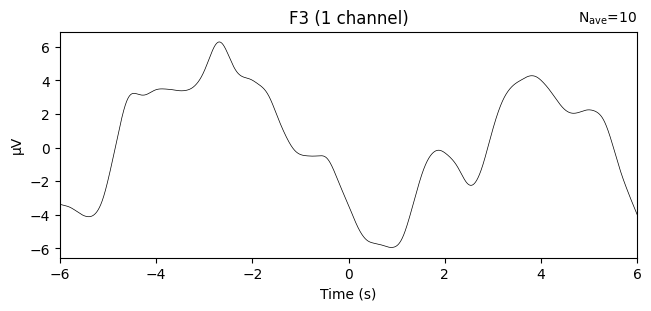

Need more than one channel to make topography for eeg. Disabling interactivity.


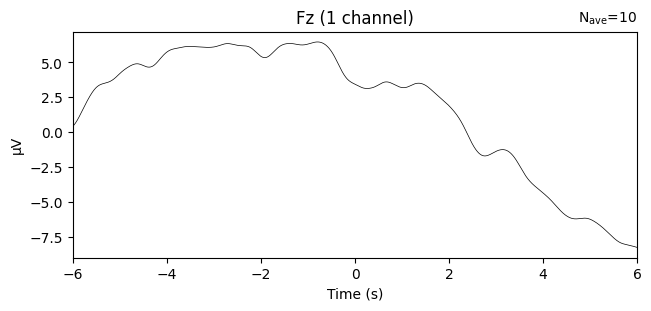

Need more than one channel to make topography for eeg. Disabling interactivity.


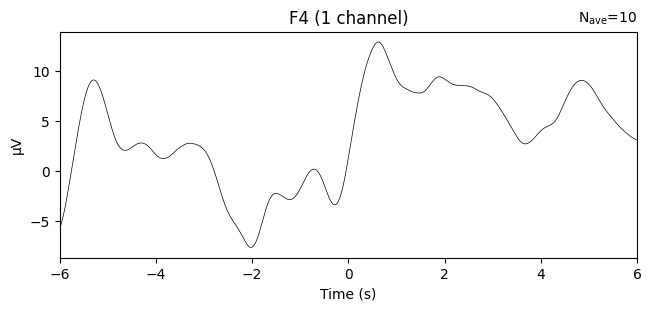

Need more than one channel to make topography for eeg. Disabling interactivity.


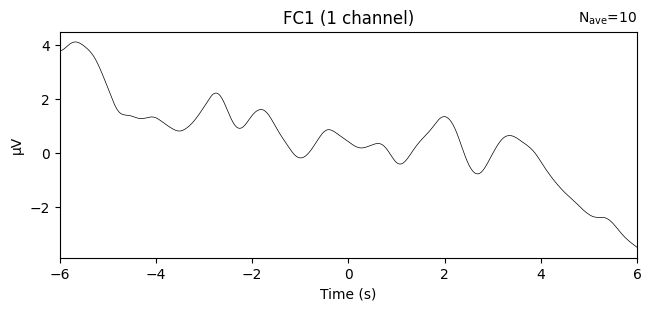

Need more than one channel to make topography for eeg. Disabling interactivity.


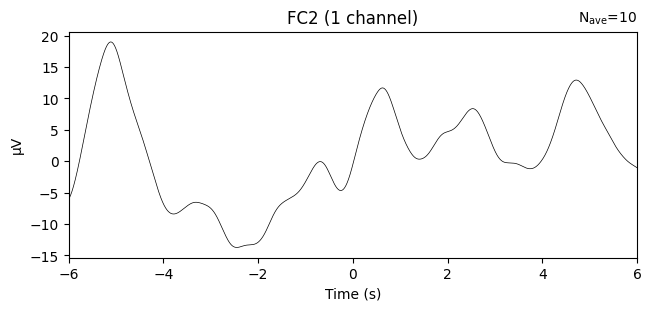

Need more than one channel to make topography for eeg. Disabling interactivity.


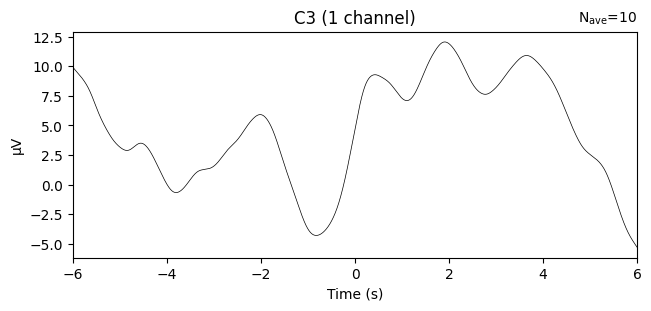

Need more than one channel to make topography for eeg. Disabling interactivity.


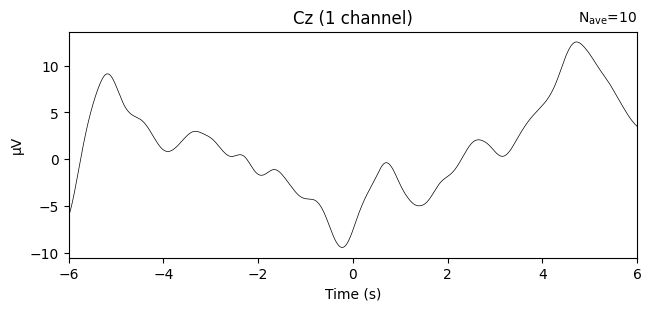

Need more than one channel to make topography for eeg. Disabling interactivity.


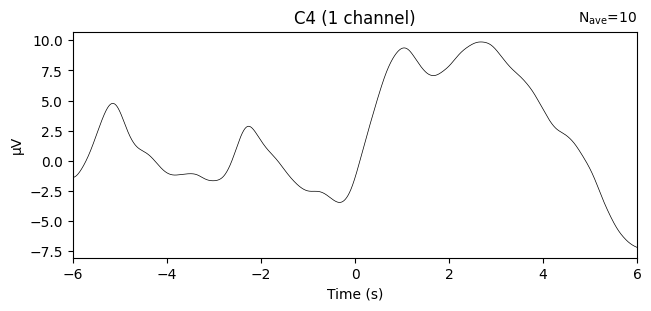

Need more than one channel to make topography for eeg. Disabling interactivity.


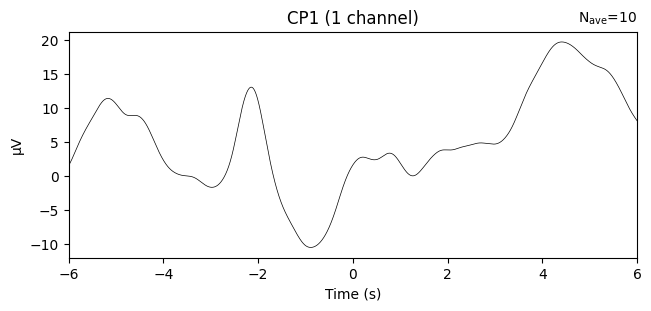

Need more than one channel to make topography for eeg. Disabling interactivity.


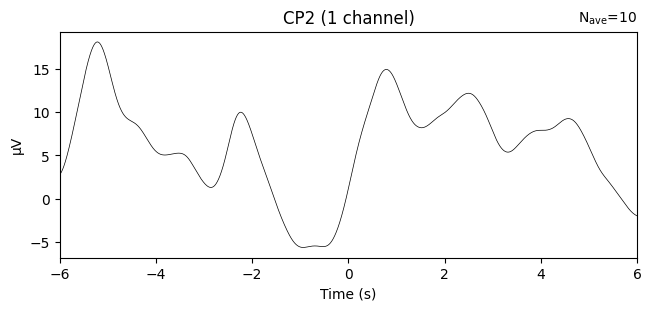

Stream 1: Calculated effective sampling rate 3859.9709 Hz is different from specified rate 100.0000 Hz.


sub-P104-Joystick_S002
Creating RawArray with float64 data, n_channels=32, n_times=191296
    Range : 0 ... 191295 =      0.000 ...   382.590 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


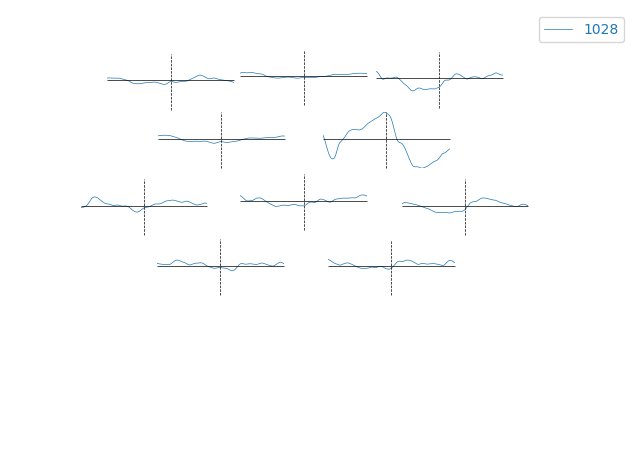

Need more than one channel to make topography for eeg. Disabling interactivity.


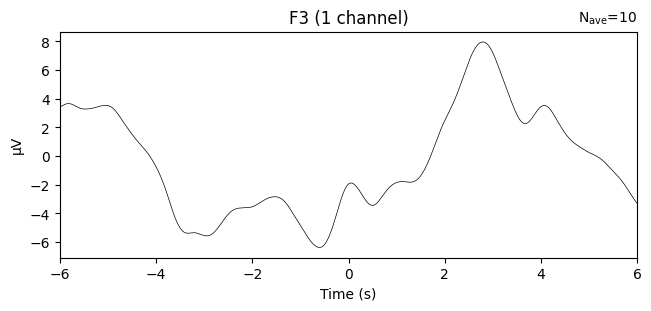

Need more than one channel to make topography for eeg. Disabling interactivity.


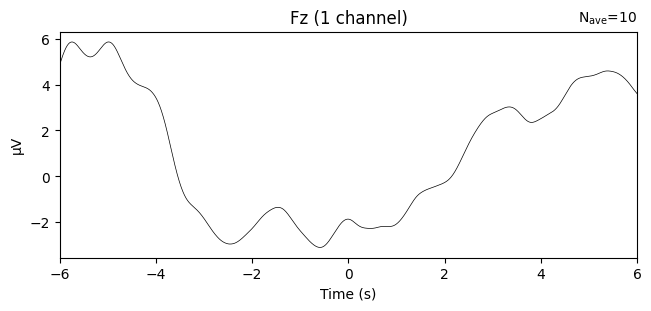

Need more than one channel to make topography for eeg. Disabling interactivity.


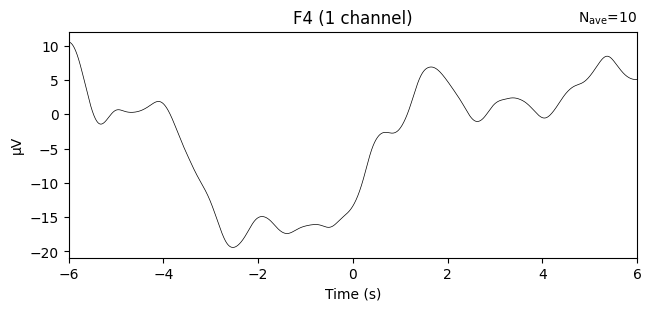

Need more than one channel to make topography for eeg. Disabling interactivity.


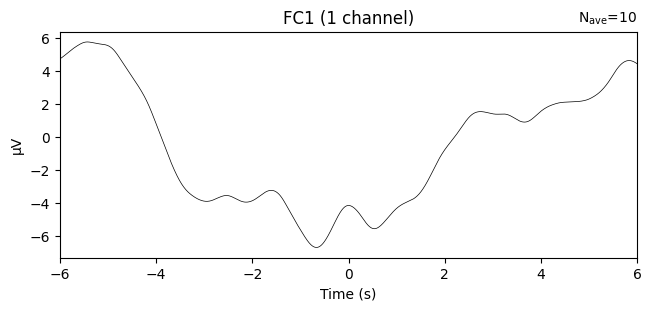

Need more than one channel to make topography for eeg. Disabling interactivity.


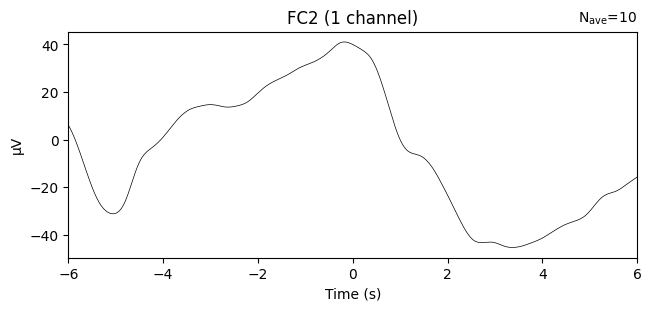

Need more than one channel to make topography for eeg. Disabling interactivity.


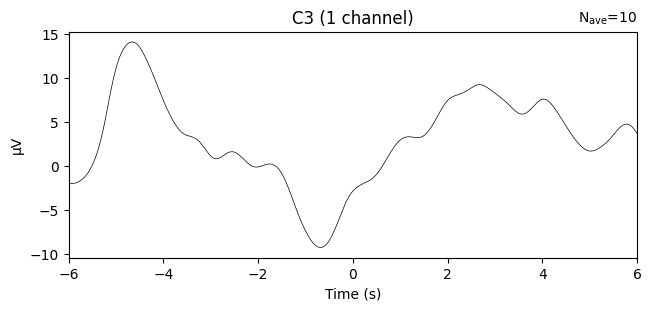

Need more than one channel to make topography for eeg. Disabling interactivity.


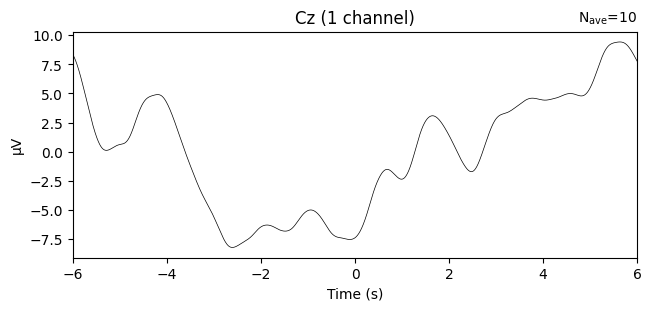

Need more than one channel to make topography for eeg. Disabling interactivity.


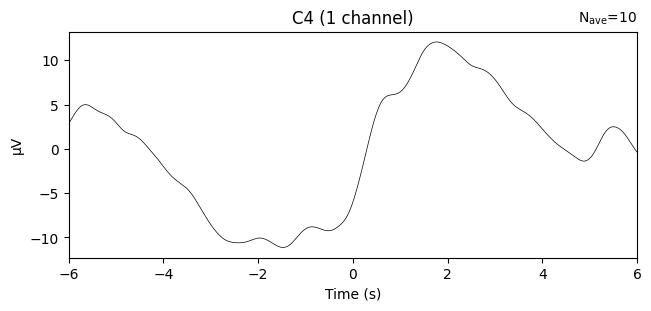

Need more than one channel to make topography for eeg. Disabling interactivity.


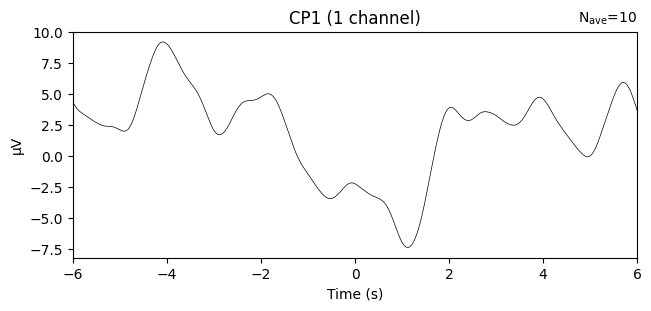

Need more than one channel to make topography for eeg. Disabling interactivity.


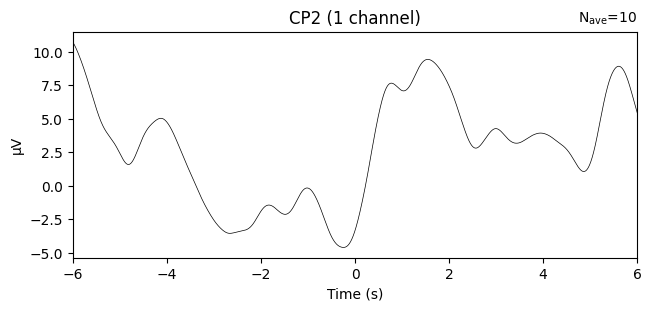

Stream 2: Calculated effective sampling rate 3872.0841 Hz is different from specified rate 100.0000 Hz.


sub-P104-Joystick_S003
Creating RawArray with float64 data, n_channels=32, n_times=211022
    Range : 0 ... 211021 =      0.000 ...   422.042 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


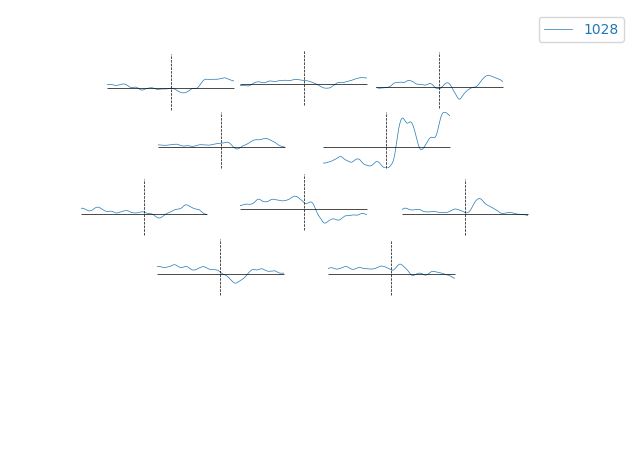

Need more than one channel to make topography for eeg. Disabling interactivity.


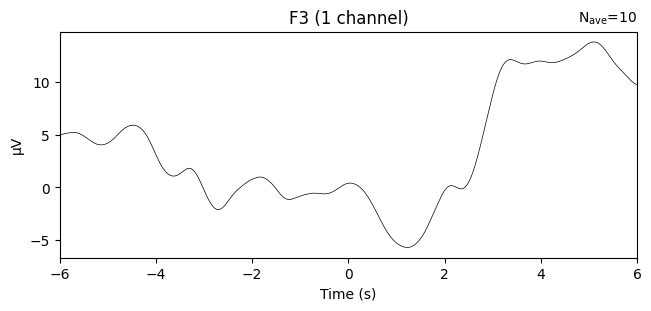

Need more than one channel to make topography for eeg. Disabling interactivity.


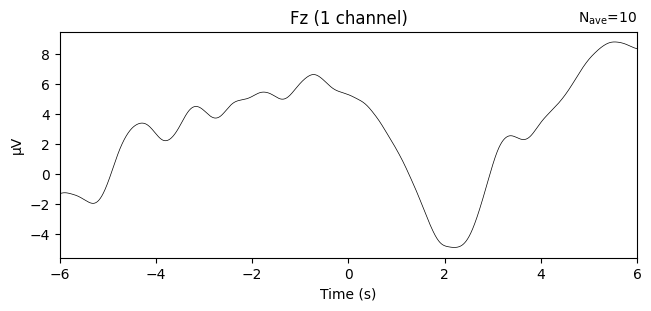

Need more than one channel to make topography for eeg. Disabling interactivity.


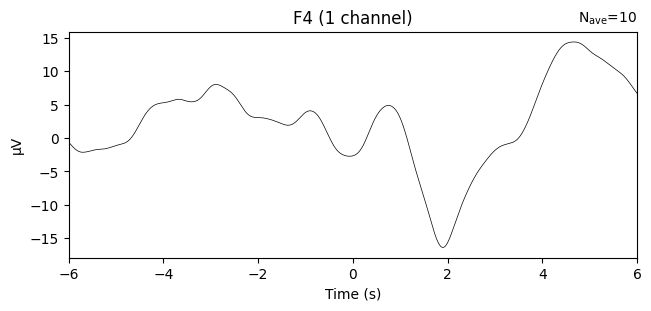

Need more than one channel to make topography for eeg. Disabling interactivity.


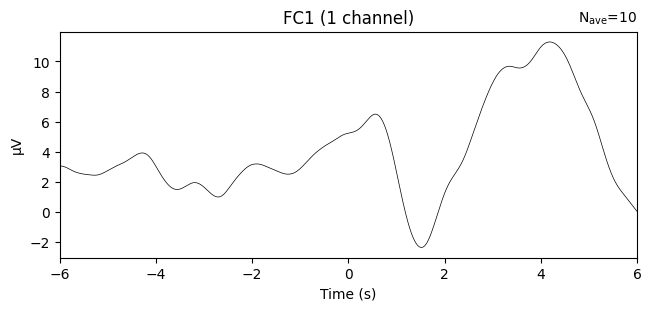

Need more than one channel to make topography for eeg. Disabling interactivity.


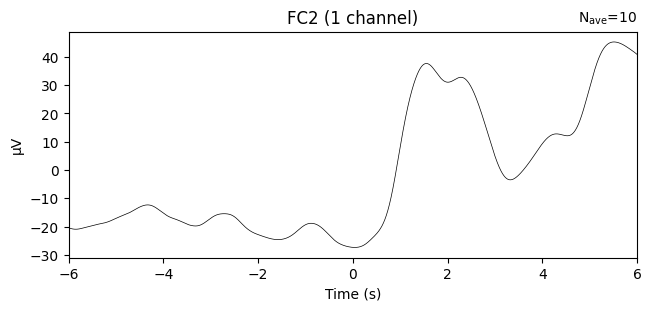

Need more than one channel to make topography for eeg. Disabling interactivity.


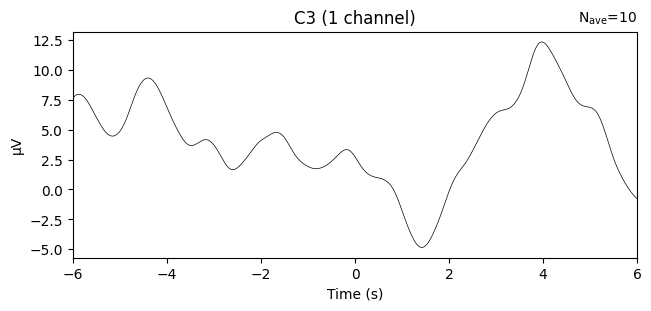

Need more than one channel to make topography for eeg. Disabling interactivity.


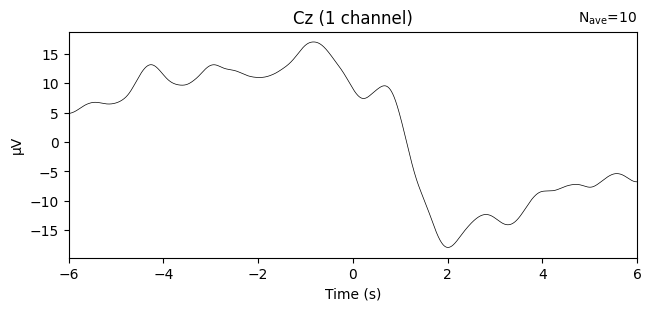

Need more than one channel to make topography for eeg. Disabling interactivity.


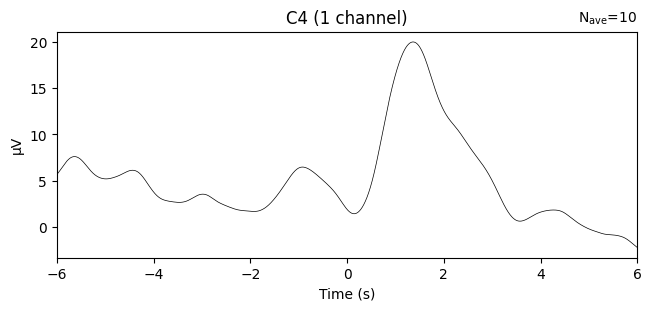

Need more than one channel to make topography for eeg. Disabling interactivity.


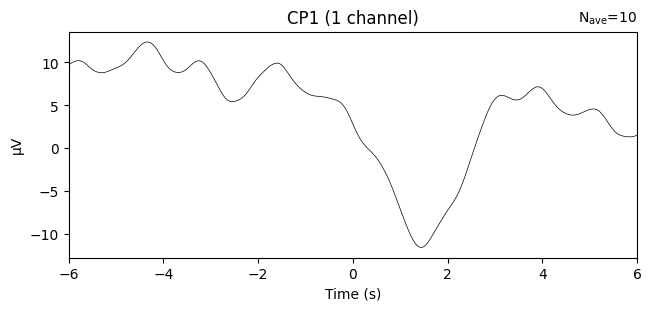

Need more than one channel to make topography for eeg. Disabling interactivity.


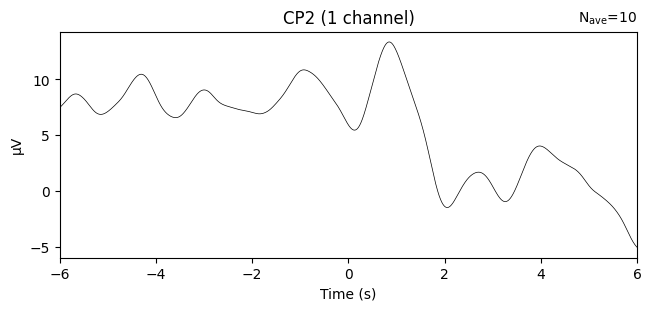

Stream 3: Calculated effective sampling rate 3887.8764 Hz is different from specified rate 100.0000 Hz.


sub-P104-Leaning_S001
Creating RawArray with float64 data, n_channels=32, n_times=281528
    Range : 0 ... 281527 =      0.000 ...   563.054 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


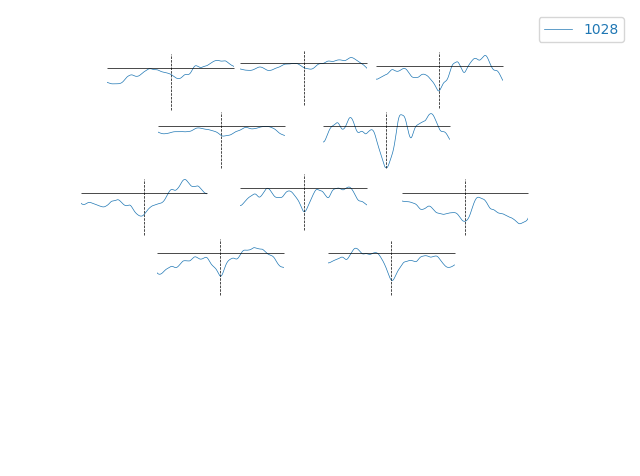

Need more than one channel to make topography for eeg. Disabling interactivity.


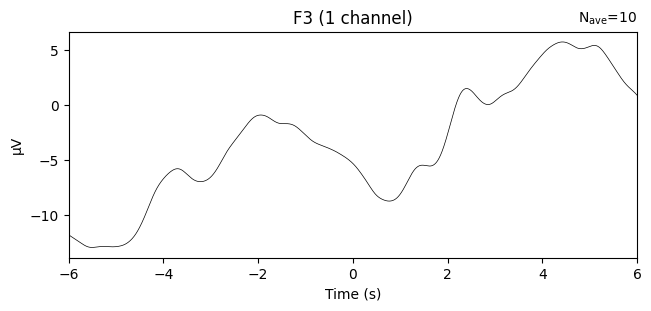

Need more than one channel to make topography for eeg. Disabling interactivity.


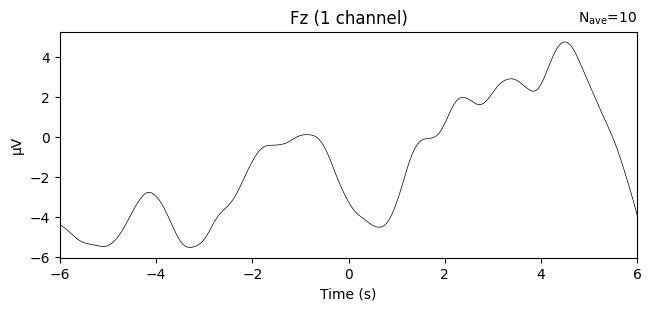

Need more than one channel to make topography for eeg. Disabling interactivity.


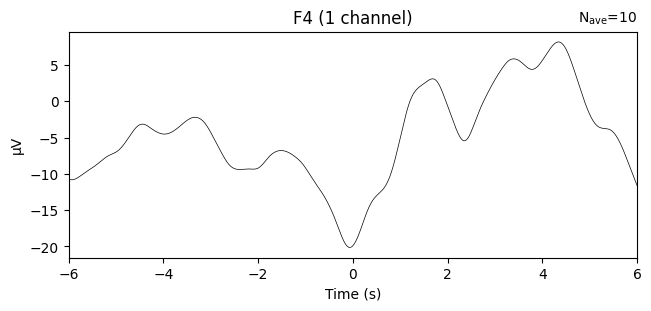

Need more than one channel to make topography for eeg. Disabling interactivity.


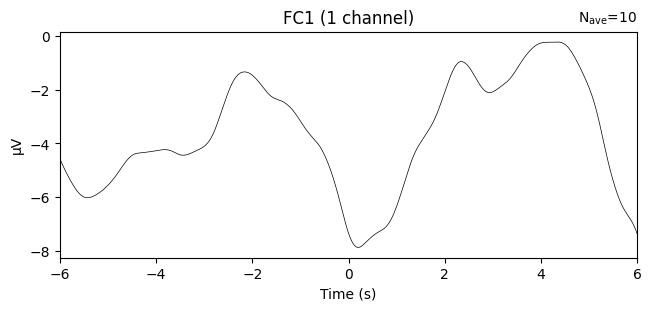

Need more than one channel to make topography for eeg. Disabling interactivity.


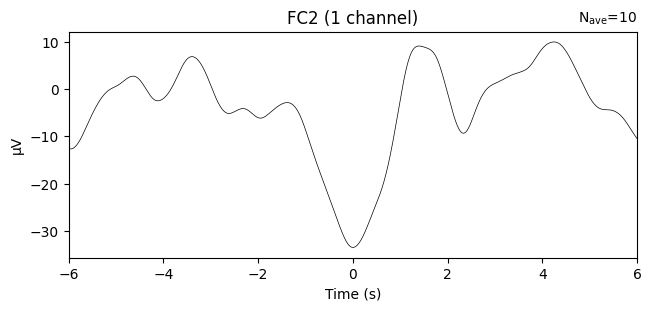

Need more than one channel to make topography for eeg. Disabling interactivity.


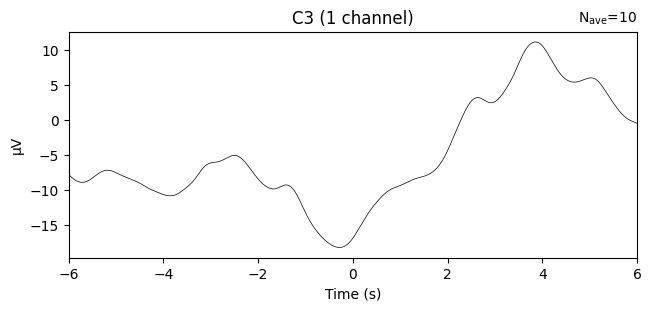

Need more than one channel to make topography for eeg. Disabling interactivity.


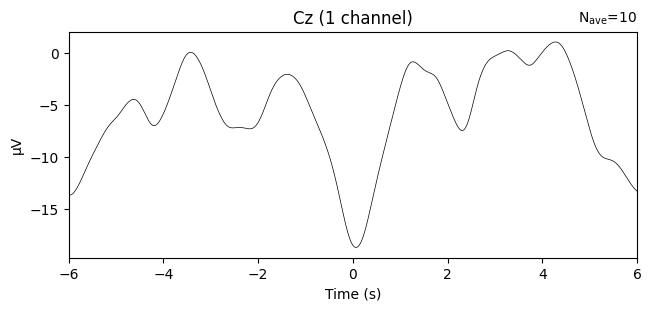

Need more than one channel to make topography for eeg. Disabling interactivity.


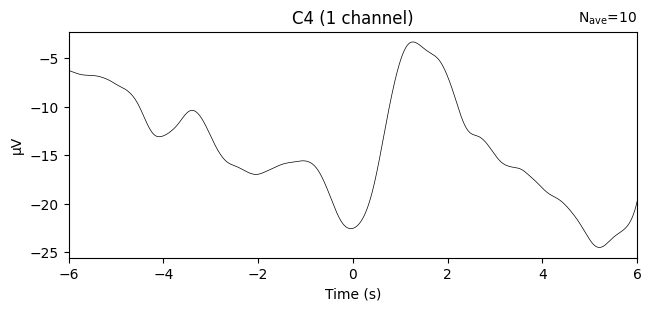

Need more than one channel to make topography for eeg. Disabling interactivity.


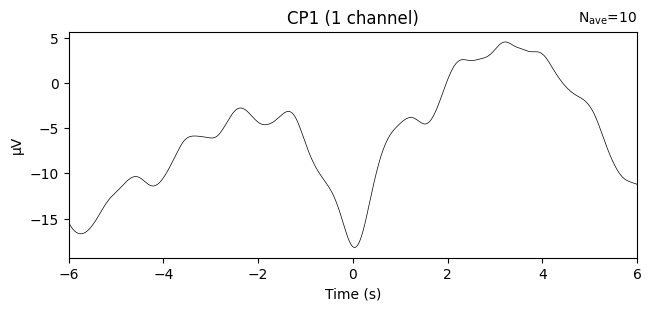

Need more than one channel to make topography for eeg. Disabling interactivity.


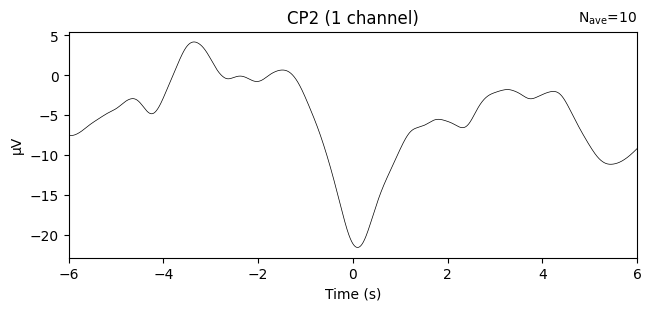

Stream 4: Calculated effective sampling rate 3879.0192 Hz is different from specified rate 100.0000 Hz.


sub-P104-Leaning_S002
Creating RawArray with float64 data, n_channels=32, n_times=230811
    Range : 0 ... 230810 =      0.000 ...   461.620 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 6001 original time points ...
0 bad epochs dropped


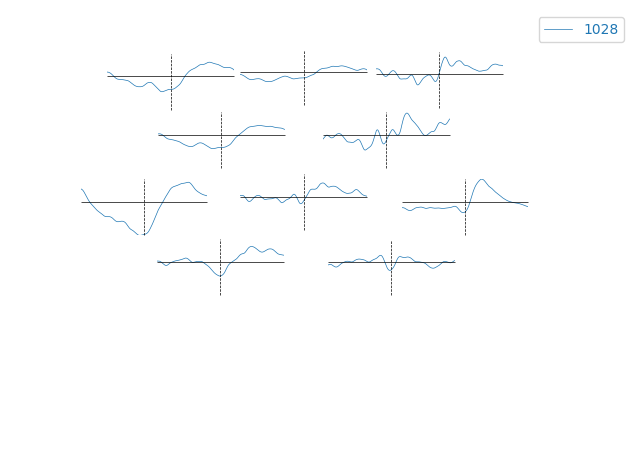

Need more than one channel to make topography for eeg. Disabling interactivity.


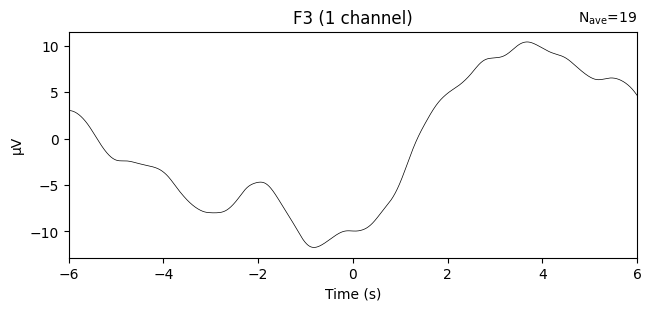

Need more than one channel to make topography for eeg. Disabling interactivity.


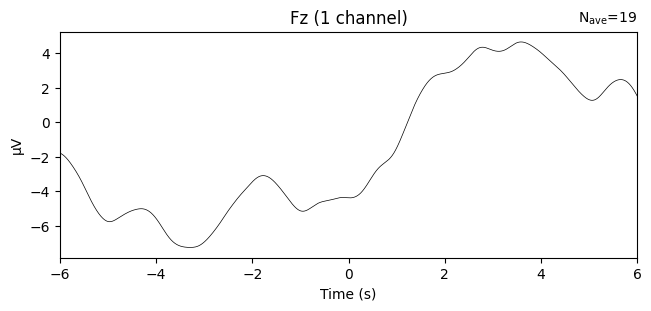

Need more than one channel to make topography for eeg. Disabling interactivity.


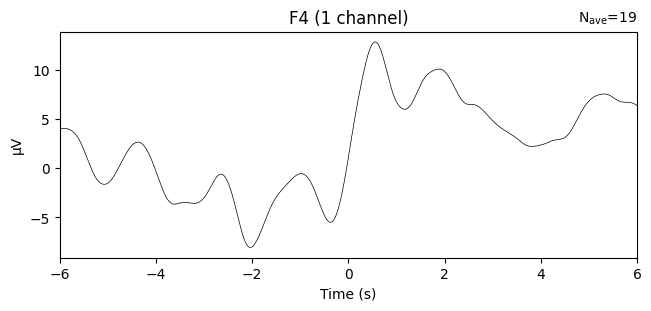

Need more than one channel to make topography for eeg. Disabling interactivity.


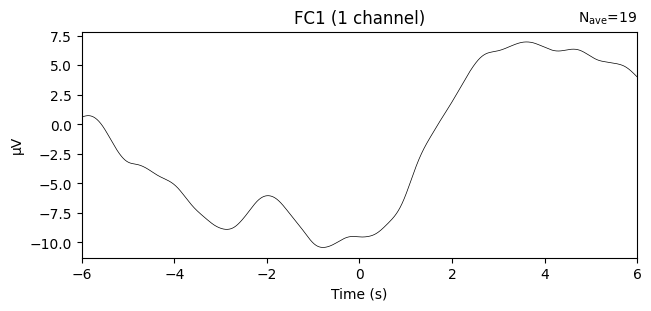

Need more than one channel to make topography for eeg. Disabling interactivity.


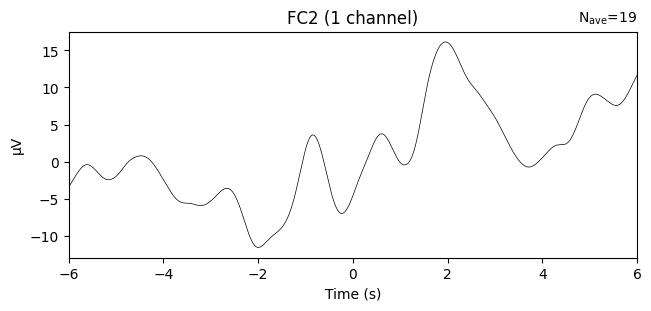

Need more than one channel to make topography for eeg. Disabling interactivity.


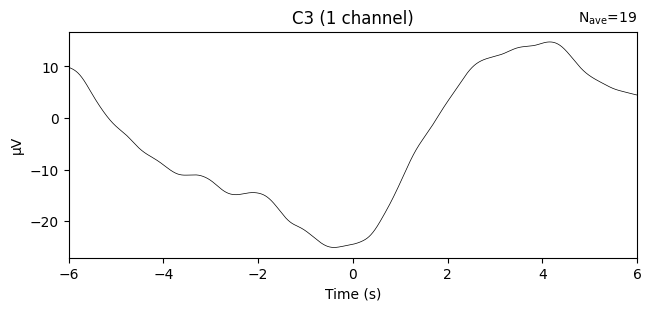

Need more than one channel to make topography for eeg. Disabling interactivity.


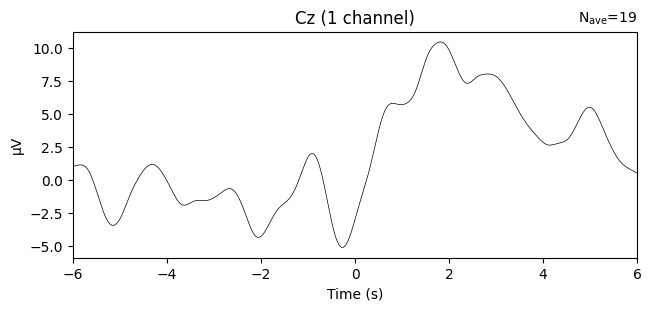

Need more than one channel to make topography for eeg. Disabling interactivity.


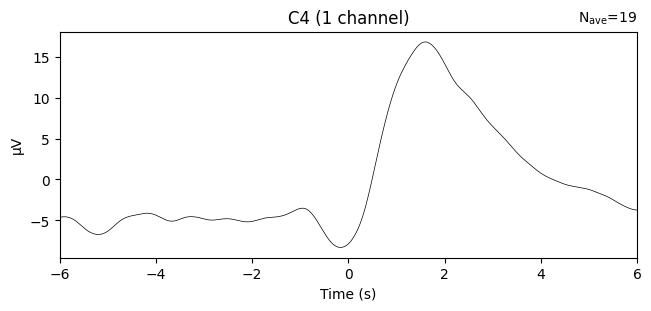

Need more than one channel to make topography for eeg. Disabling interactivity.


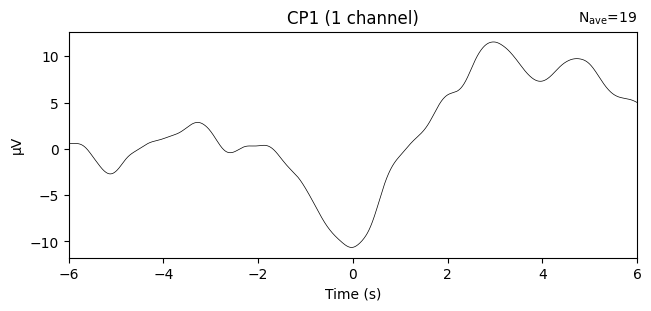

Need more than one channel to make topography for eeg. Disabling interactivity.


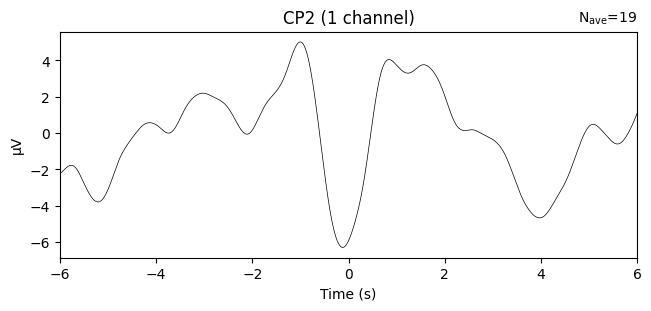

Stream 4: Calculated effective sampling rate 3881.6451 Hz is different from specified rate 100.0000 Hz.


sub-P104-Leaning_S003
Creating RawArray with float64 data, n_channels=32, n_times=216274
    Range : 0 ... 216273 =      0.000 ...   432.546 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 6001 original time points ...
0 bad epochs dropped


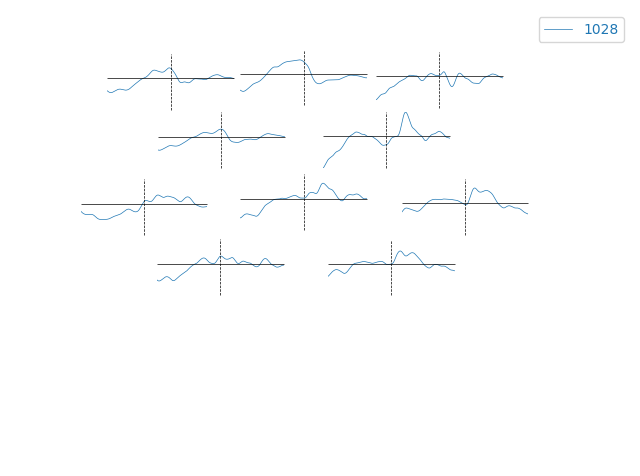

Need more than one channel to make topography for eeg. Disabling interactivity.


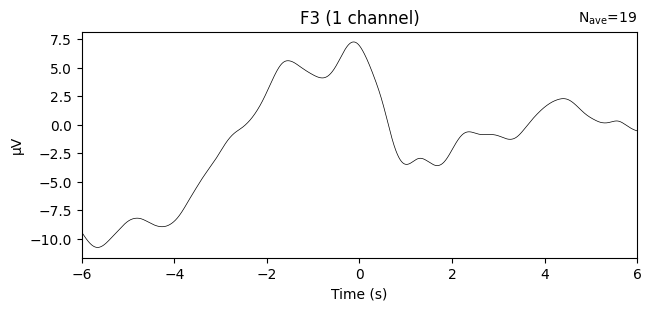

Need more than one channel to make topography for eeg. Disabling interactivity.


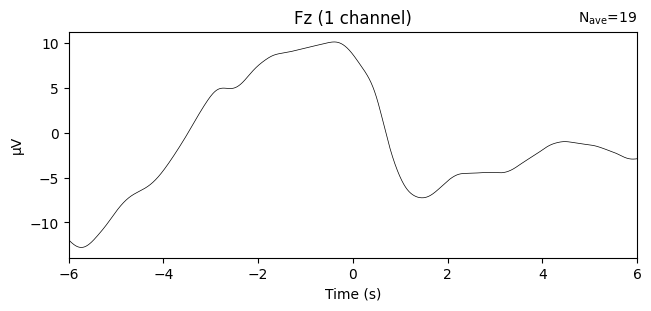

Need more than one channel to make topography for eeg. Disabling interactivity.


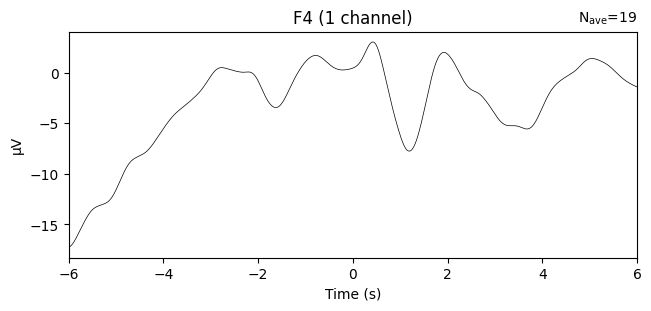

Need more than one channel to make topography for eeg. Disabling interactivity.


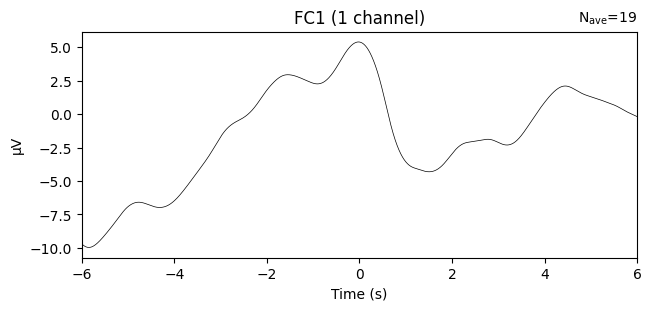

Need more than one channel to make topography for eeg. Disabling interactivity.


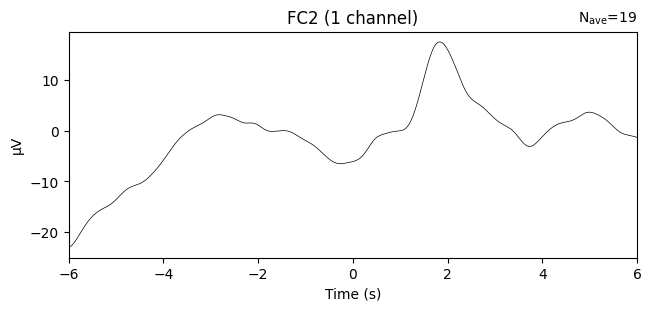

Need more than one channel to make topography for eeg. Disabling interactivity.


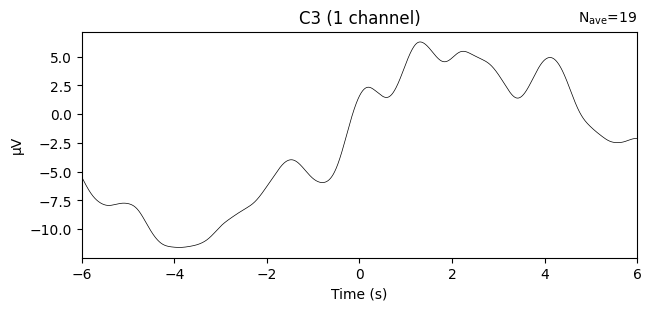

Need more than one channel to make topography for eeg. Disabling interactivity.


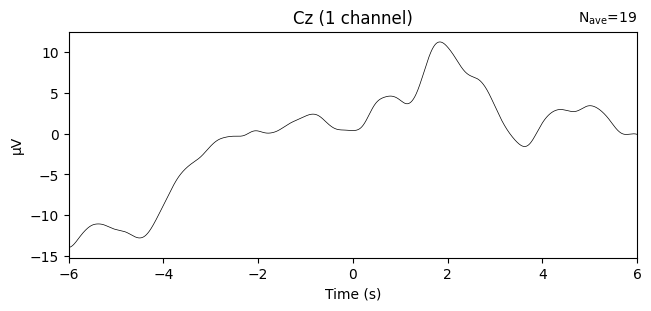

Need more than one channel to make topography for eeg. Disabling interactivity.


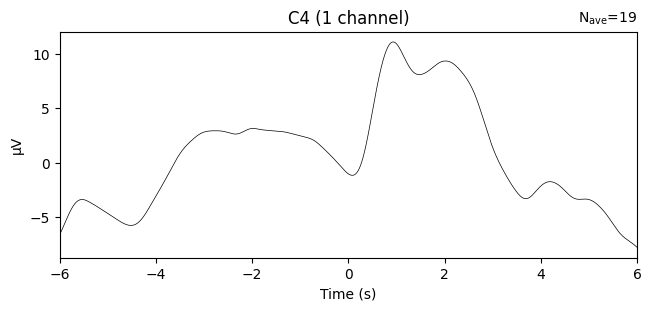

Need more than one channel to make topography for eeg. Disabling interactivity.


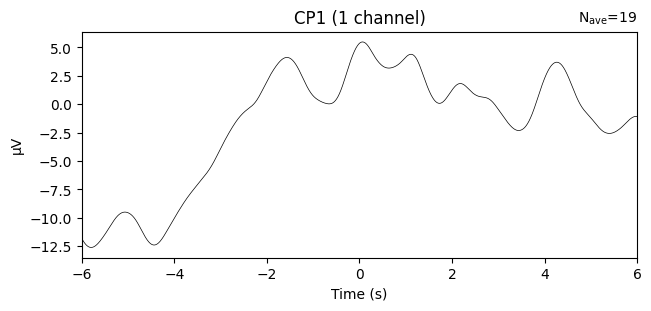

Need more than one channel to make topography for eeg. Disabling interactivity.


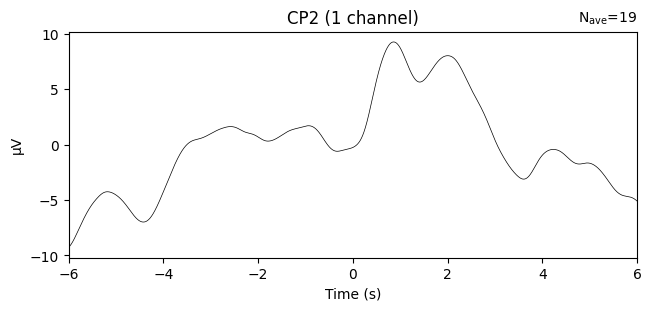

found likely XDF file corruption (unclosed token: line 1, column 1527), ignoring corrupted XML element in footer.
Stream 2: Calculated effective sampling rate 3884.8861 Hz is different from specified rate 100.0000 Hz.


sub-P104-Omnideck_S001
Creating RawArray with float64 data, n_channels=32, n_times=277018
    Range : 0 ... 277017 =      0.000 ...   554.034 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 6001 original time points ...
0 bad epochs dropped


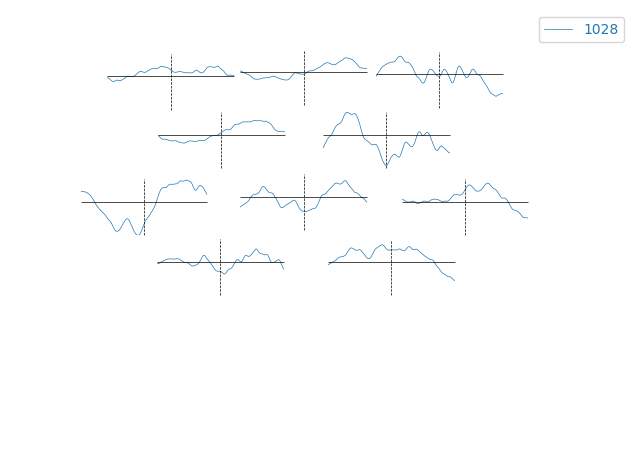

Need more than one channel to make topography for eeg. Disabling interactivity.


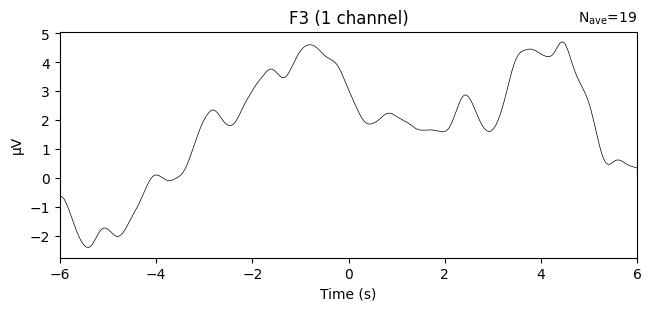

Need more than one channel to make topography for eeg. Disabling interactivity.


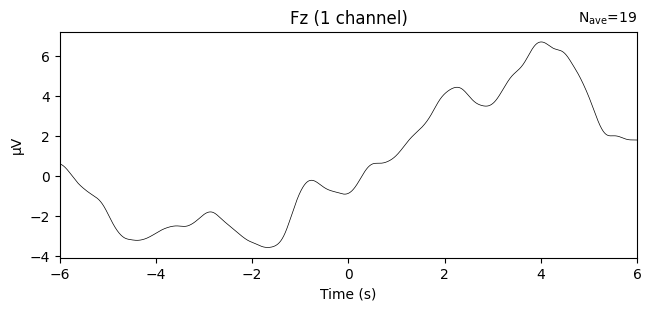

Need more than one channel to make topography for eeg. Disabling interactivity.


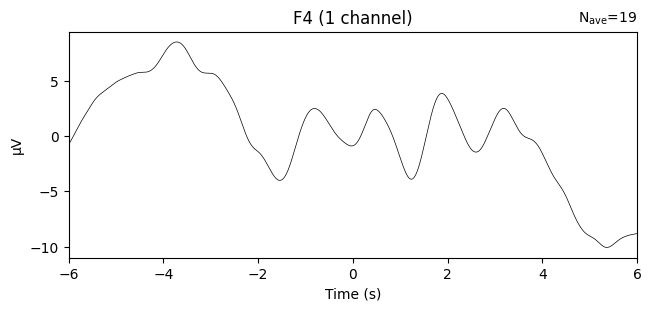

Need more than one channel to make topography for eeg. Disabling interactivity.


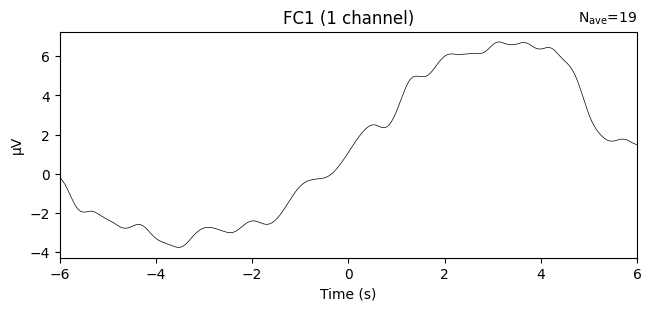

Need more than one channel to make topography for eeg. Disabling interactivity.


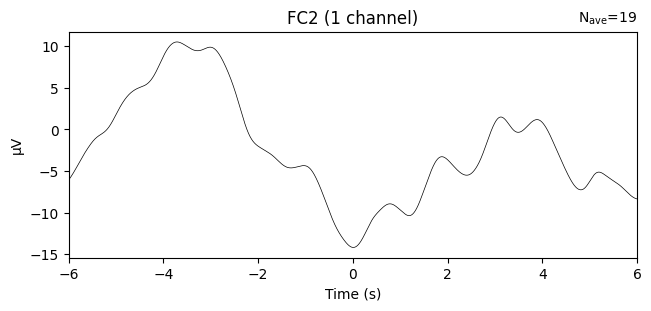

Need more than one channel to make topography for eeg. Disabling interactivity.


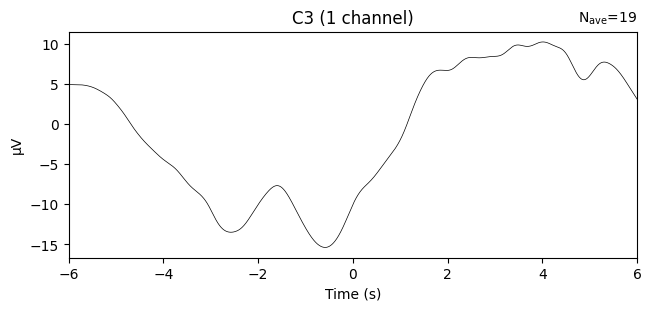

Need more than one channel to make topography for eeg. Disabling interactivity.


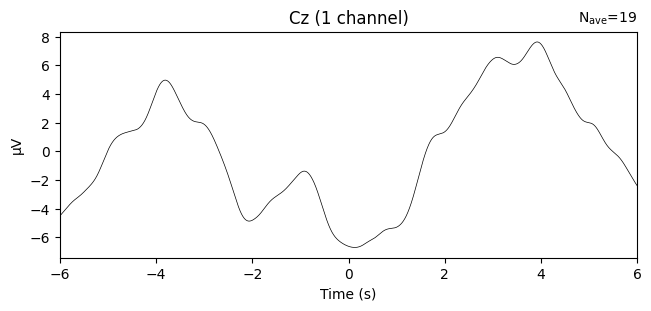

Need more than one channel to make topography for eeg. Disabling interactivity.


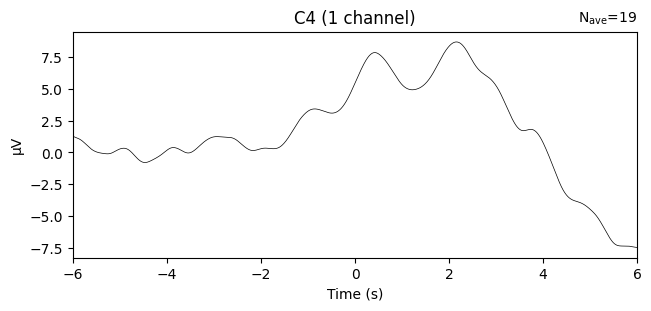

Need more than one channel to make topography for eeg. Disabling interactivity.


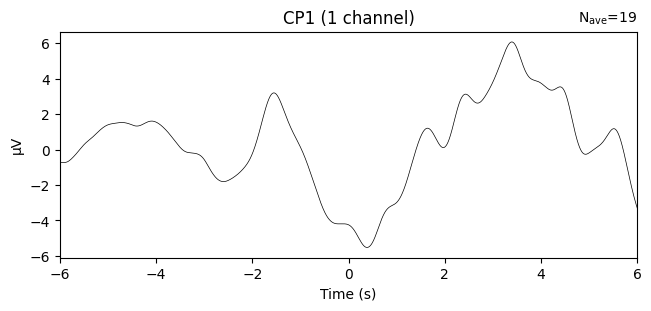

Need more than one channel to make topography for eeg. Disabling interactivity.


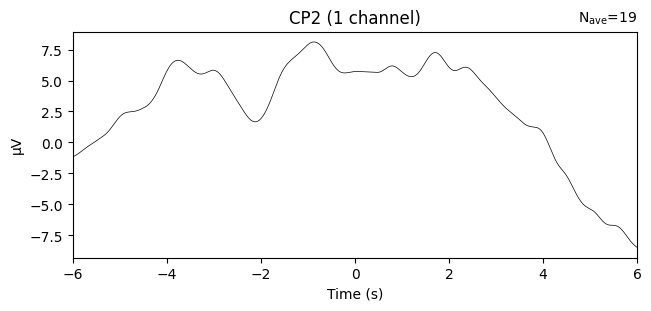

found likely XDF file corruption (unclosed token: line 1, column 3047), ignoring corrupted XML element in footer.
Stream 3: Calculated effective sampling rate 3870.9120 Hz is different from specified rate 100.0000 Hz.


sub-P104-Omnideck_S002
Creating RawArray with float64 data, n_channels=32, n_times=253538
    Range : 0 ... 253537 =      0.000 ...   507.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1008'), np.str_('1009'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 6001 original time points ...
0 bad epochs dropped


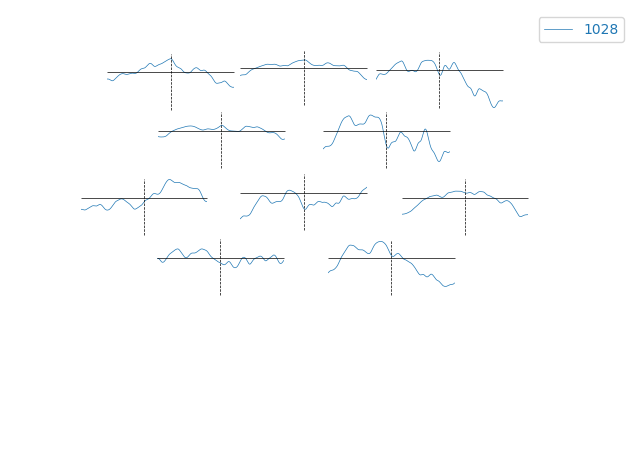

Need more than one channel to make topography for eeg. Disabling interactivity.


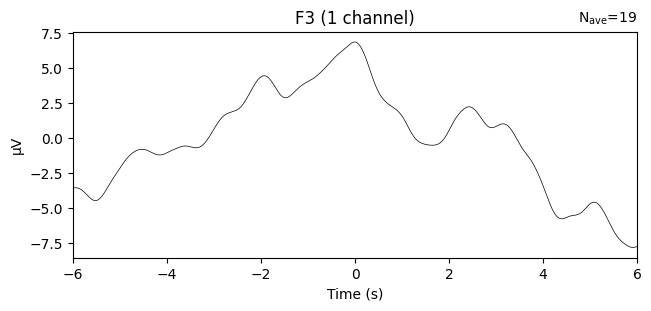

Need more than one channel to make topography for eeg. Disabling interactivity.


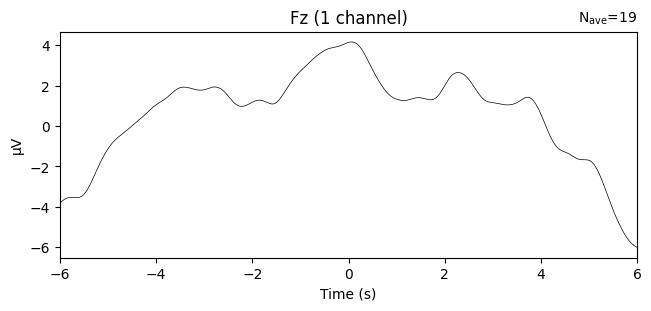

Need more than one channel to make topography for eeg. Disabling interactivity.


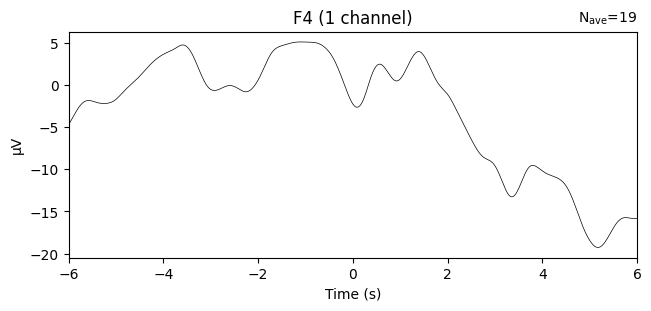

Need more than one channel to make topography for eeg. Disabling interactivity.


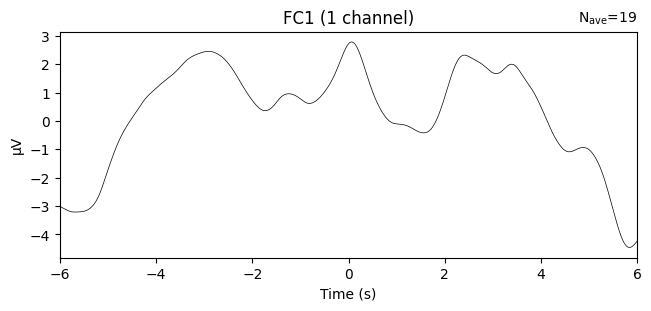

Need more than one channel to make topography for eeg. Disabling interactivity.


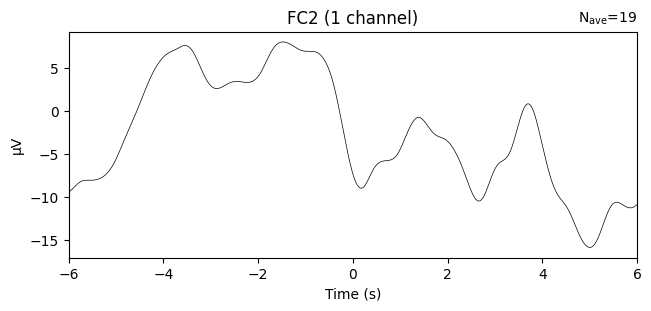

Need more than one channel to make topography for eeg. Disabling interactivity.


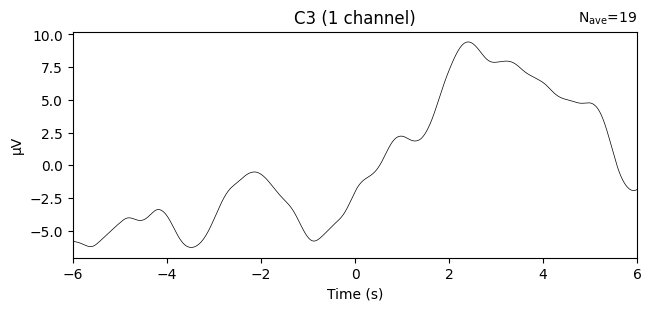

Need more than one channel to make topography for eeg. Disabling interactivity.


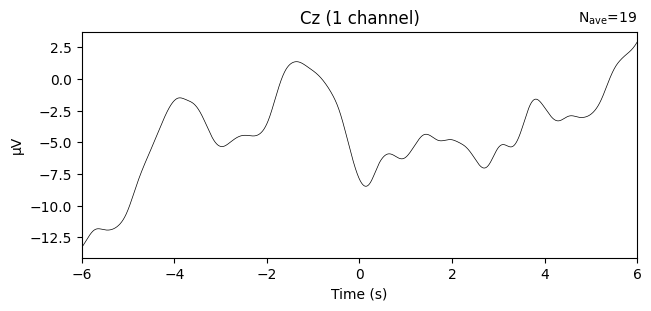

Need more than one channel to make topography for eeg. Disabling interactivity.


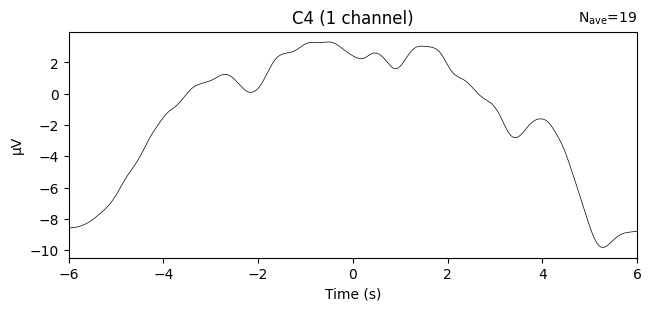

Need more than one channel to make topography for eeg. Disabling interactivity.


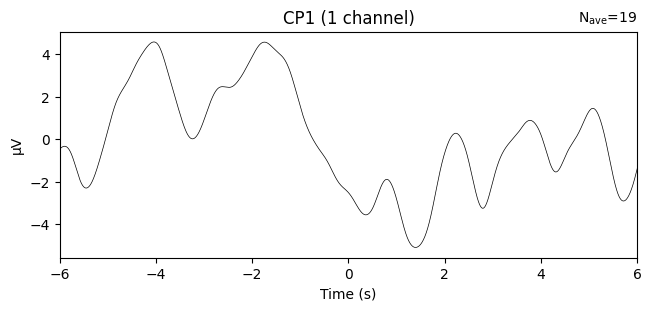

Need more than one channel to make topography for eeg. Disabling interactivity.


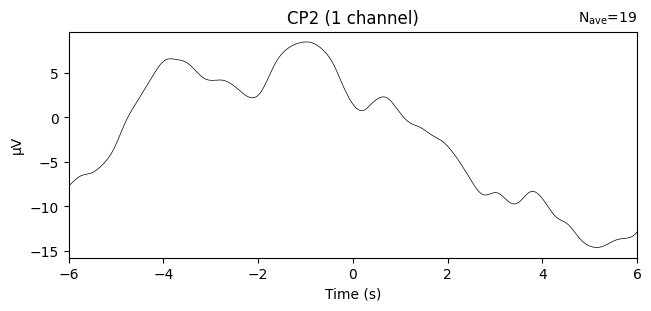

Stream 4: Calculated effective sampling rate 3871.6332 Hz is different from specified rate 100.0000 Hz.


sub-P104-Omnideck_S003
Creating RawArray with float64 data, n_channels=32, n_times=237523
    Range : 0 ... 237522 =      0.000 ...   475.044 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


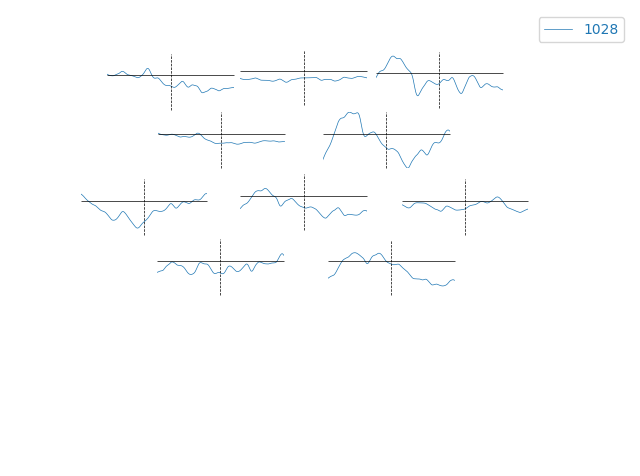

Need more than one channel to make topography for eeg. Disabling interactivity.


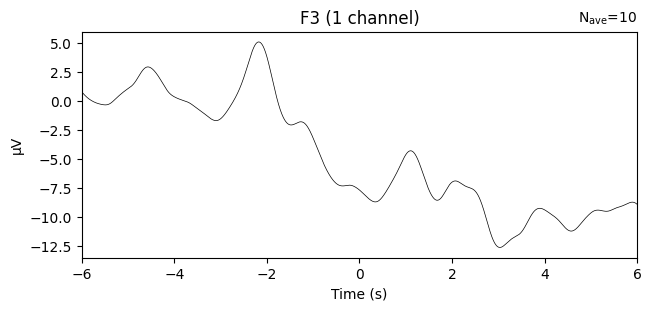

Need more than one channel to make topography for eeg. Disabling interactivity.


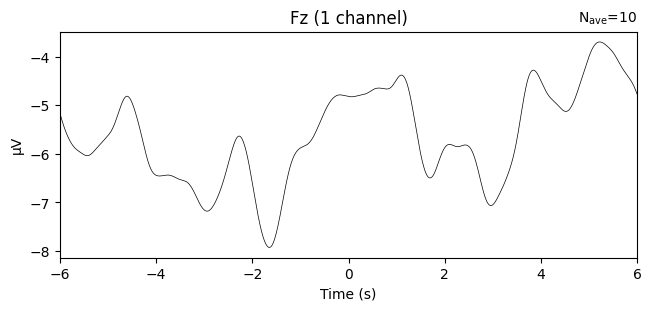

Need more than one channel to make topography for eeg. Disabling interactivity.


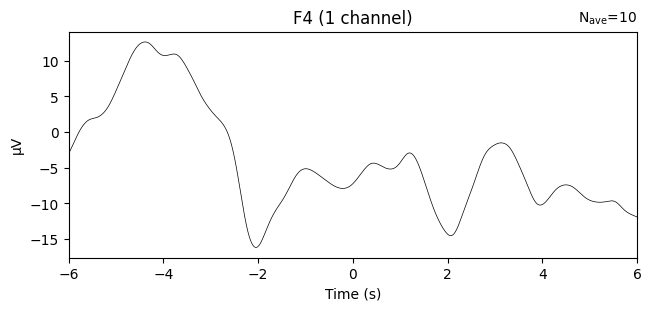

Need more than one channel to make topography for eeg. Disabling interactivity.


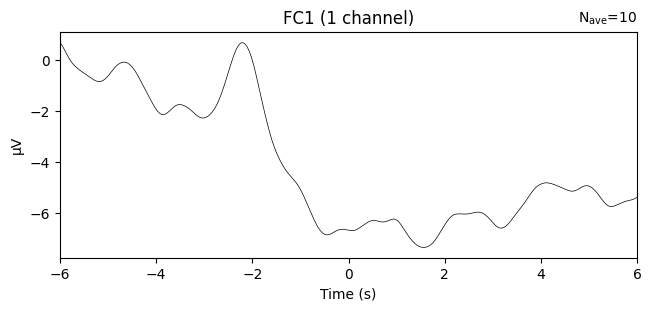

Need more than one channel to make topography for eeg. Disabling interactivity.


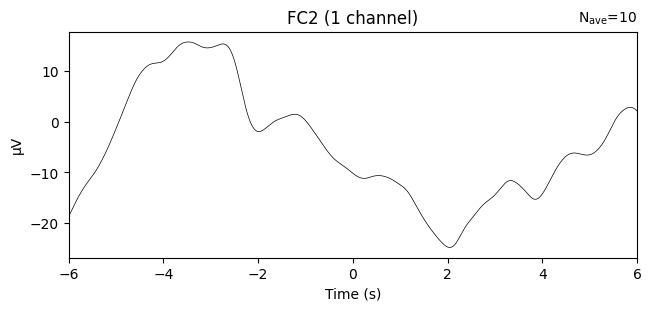

Need more than one channel to make topography for eeg. Disabling interactivity.


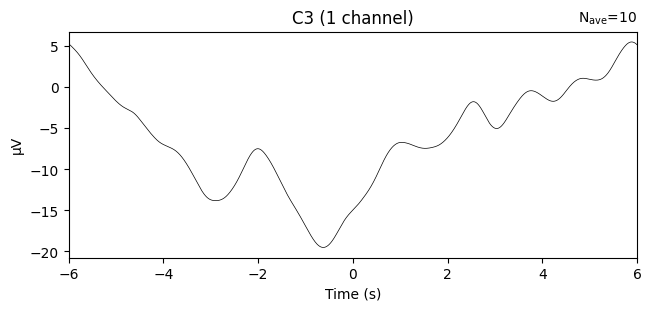

Need more than one channel to make topography for eeg. Disabling interactivity.


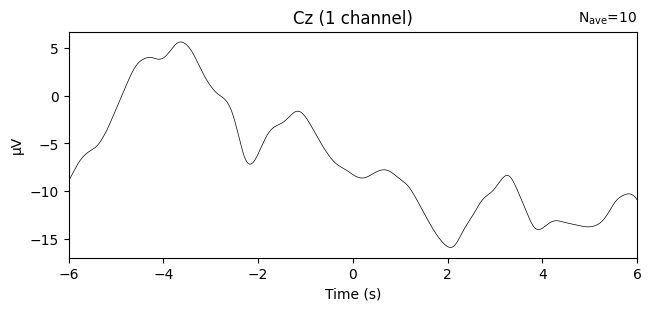

Need more than one channel to make topography for eeg. Disabling interactivity.


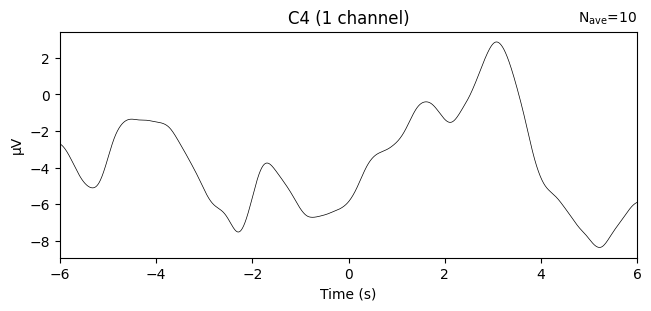

Need more than one channel to make topography for eeg. Disabling interactivity.


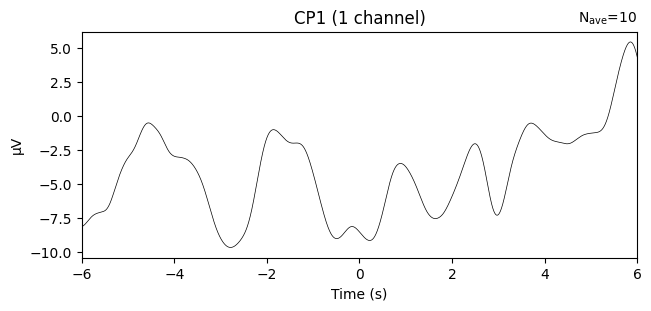

Need more than one channel to make topography for eeg. Disabling interactivity.


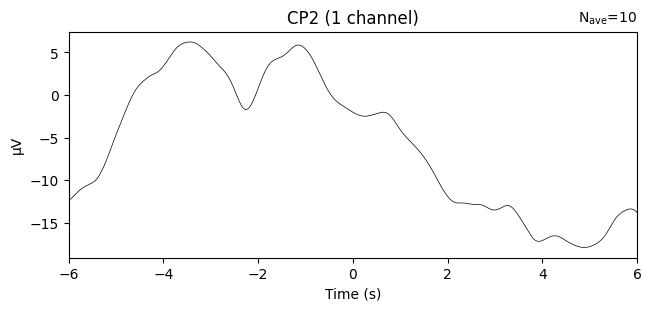

Stream 2: Calculated effective sampling rate 3892.4885 Hz is different from specified rate 100.0000 Hz.


sub-P104-Walking_S001
Creating RawArray with float64 data, n_channels=32, n_times=235007
    Range : 0 ... 235006 =      0.000 ...   470.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


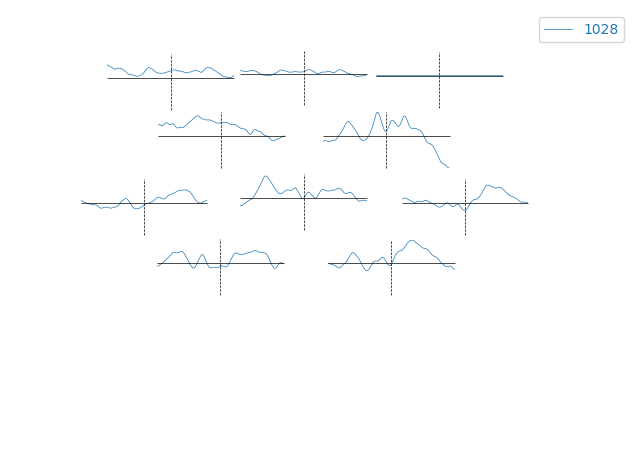

Need more than one channel to make topography for eeg. Disabling interactivity.


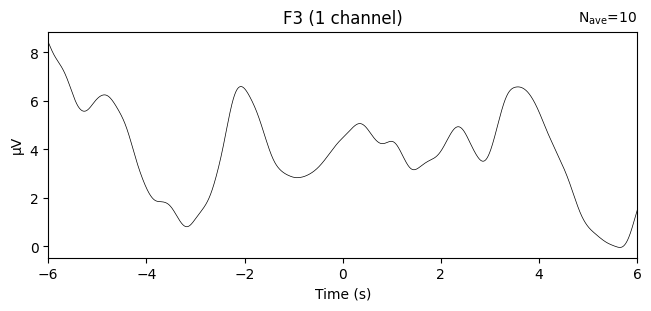

Need more than one channel to make topography for eeg. Disabling interactivity.


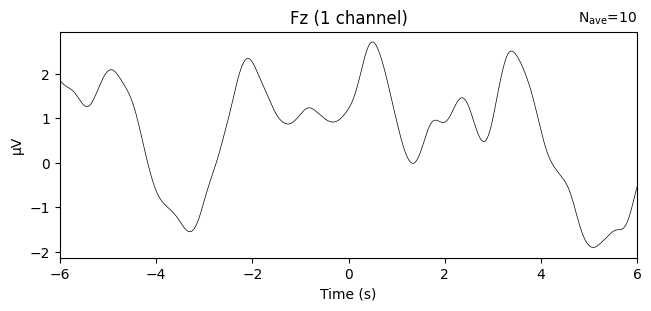

Need more than one channel to make topography for eeg. Disabling interactivity.


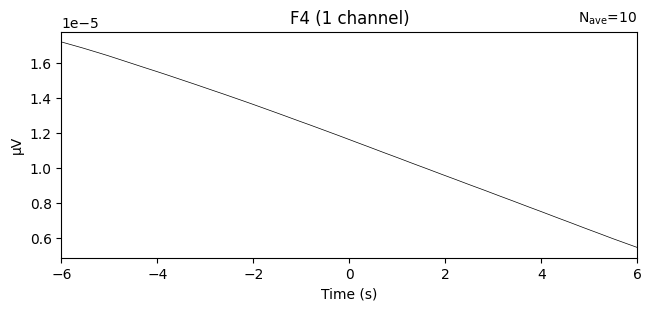

Need more than one channel to make topography for eeg. Disabling interactivity.


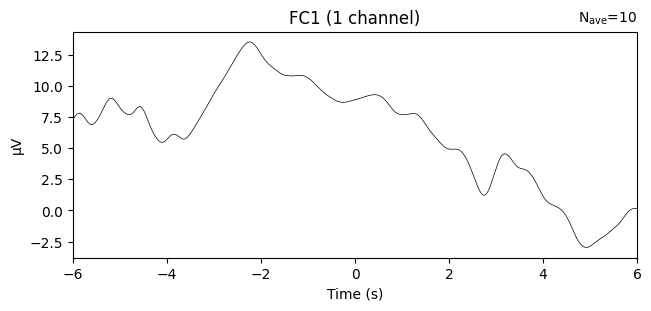

Need more than one channel to make topography for eeg. Disabling interactivity.


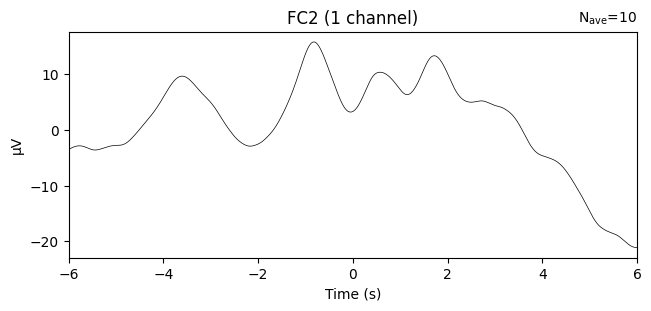

Need more than one channel to make topography for eeg. Disabling interactivity.


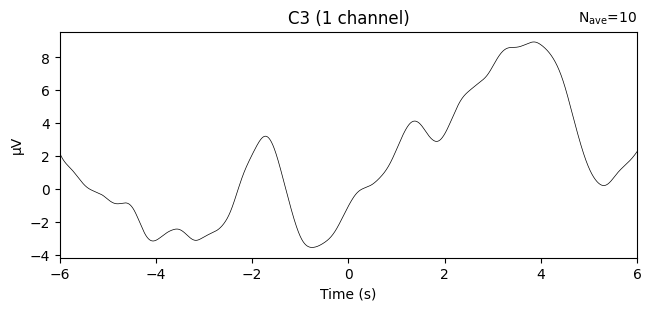

Need more than one channel to make topography for eeg. Disabling interactivity.


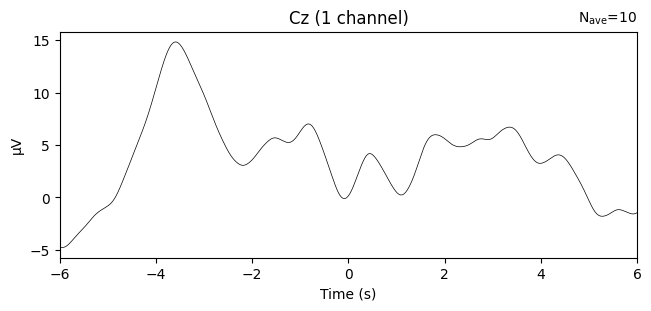

Need more than one channel to make topography for eeg. Disabling interactivity.


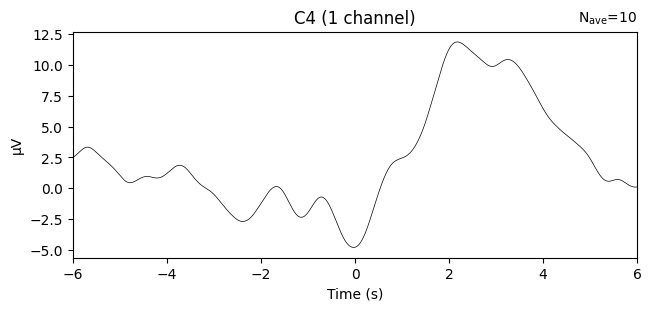

Need more than one channel to make topography for eeg. Disabling interactivity.


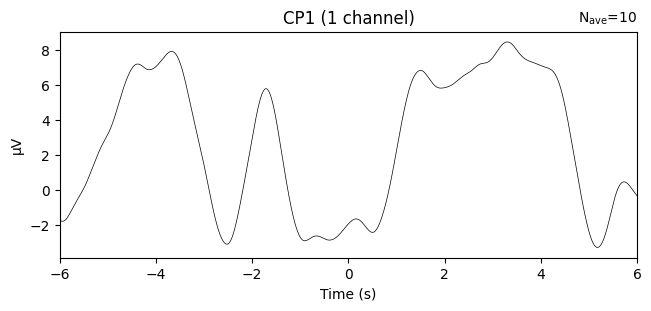

Need more than one channel to make topography for eeg. Disabling interactivity.


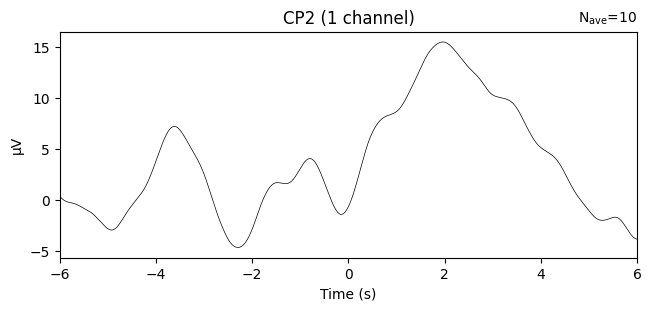

Stream 2: Calculated effective sampling rate 3884.9657 Hz is different from specified rate 100.0000 Hz.


sub-P104-Walking_S002
Creating RawArray with float64 data, n_channels=32, n_times=218270
    Range : 0 ... 218269 =      0.000 ...   436.538 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


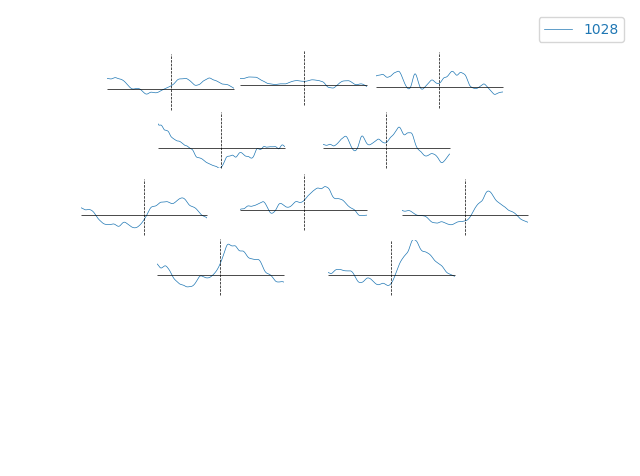

Need more than one channel to make topography for eeg. Disabling interactivity.


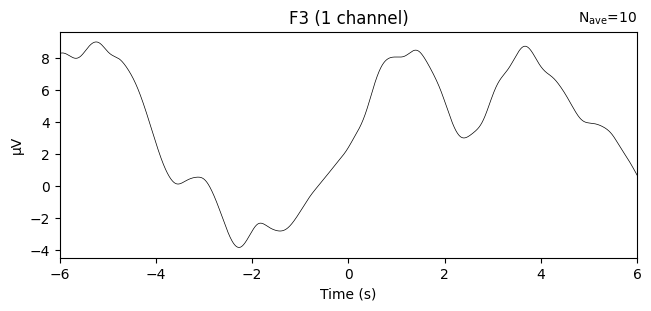

Need more than one channel to make topography for eeg. Disabling interactivity.


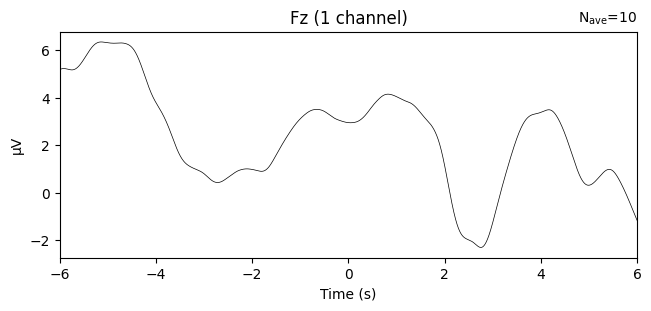

Need more than one channel to make topography for eeg. Disabling interactivity.


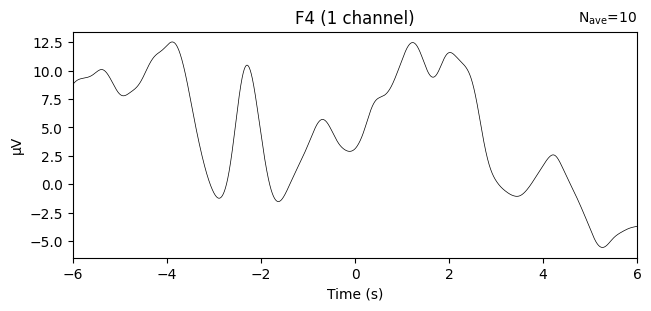

Need more than one channel to make topography for eeg. Disabling interactivity.


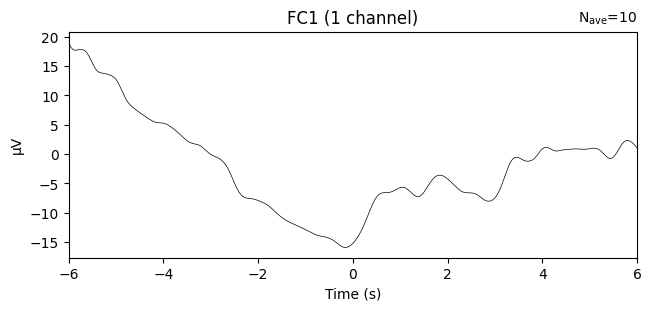

Need more than one channel to make topography for eeg. Disabling interactivity.


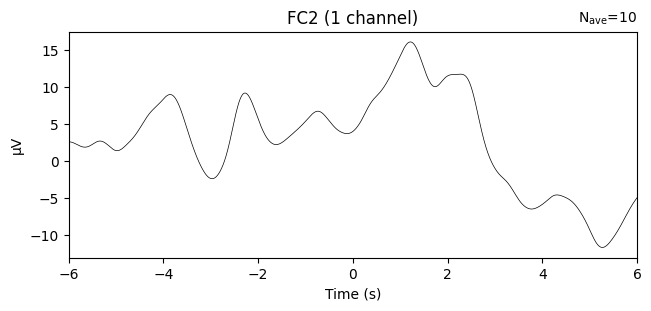

Need more than one channel to make topography for eeg. Disabling interactivity.


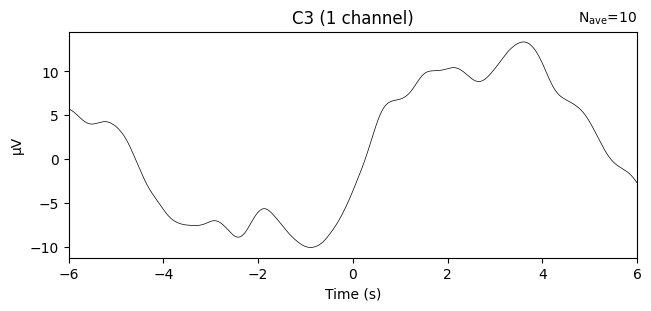

Need more than one channel to make topography for eeg. Disabling interactivity.


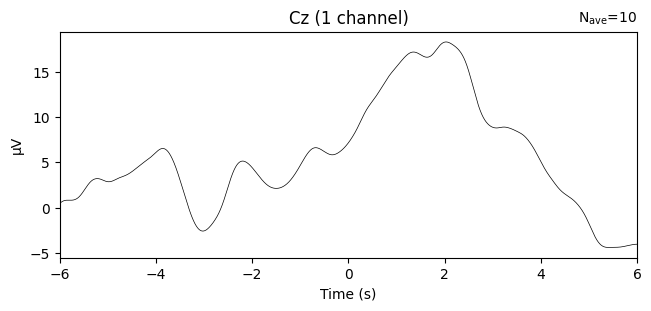

Need more than one channel to make topography for eeg. Disabling interactivity.


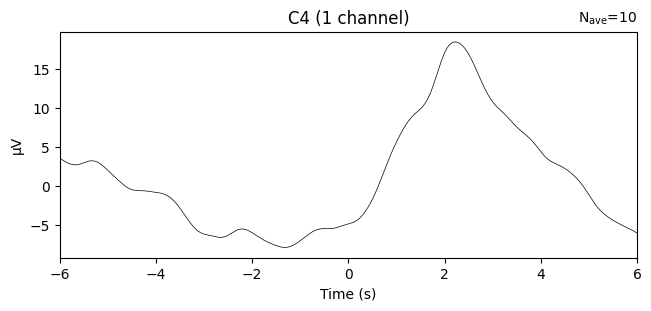

Need more than one channel to make topography for eeg. Disabling interactivity.


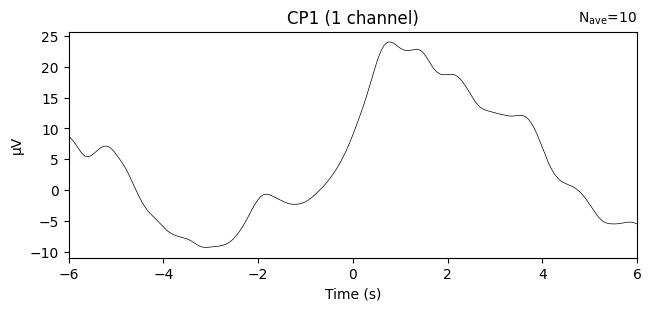

Need more than one channel to make topography for eeg. Disabling interactivity.


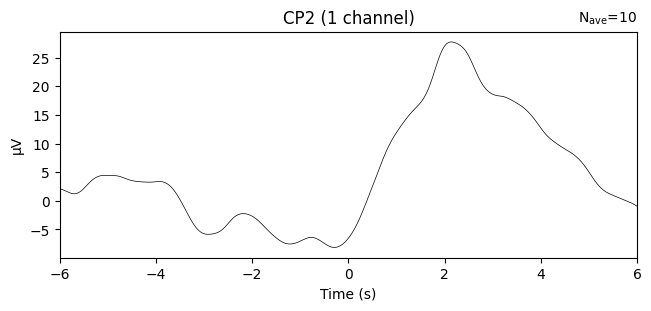

Stream 3: Calculated effective sampling rate 3889.1854 Hz is different from specified rate 100.0000 Hz.


sub-P104-Walking_S003
Creating RawArray with float64 data, n_channels=32, n_times=220036
    Range : 0 ... 220035 =      0.000 ...   440.070 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Used Annotations descriptions: [np.str_('1001'), np.str_('1002'), np.str_('1003'), np.str_('1004'), np.str_('1005'), np.str_('1006'), np.str_('1007'), np.str_('1010'), np.str_('1011'), np.str_('1012'), np.str_('1013'), np.str_('1014'), np.str_('1015'), np.str_('1016'), np.str_('1017'), np.str_('1018'), np.str_('1019'), np.str_('1020'), np.str_('1021'), np.str_('1022'), np.str_('1023'), np.str_('1024'), np.str_('1025'), np.str_('1026'), np.str_('1027'), np.str_('1028'), np.str_('1029'), np.str_('1034'), np.str_('1035')]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 6001 original time points ...
0 bad epochs dropped


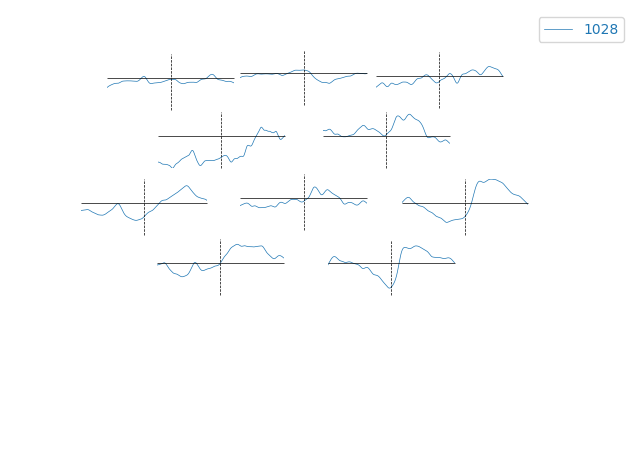

Need more than one channel to make topography for eeg. Disabling interactivity.


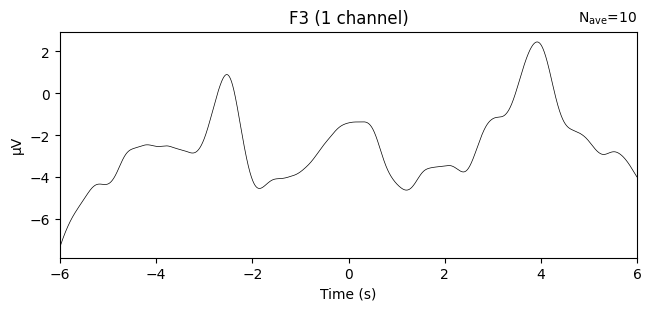

Need more than one channel to make topography for eeg. Disabling interactivity.


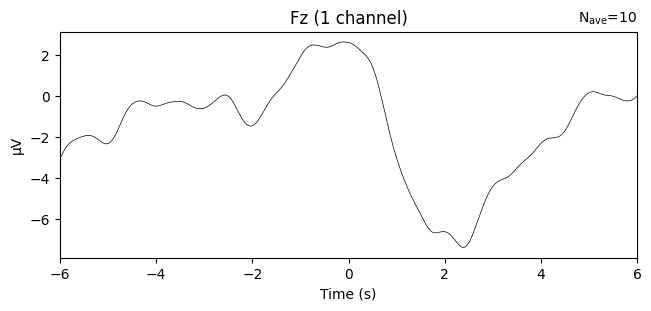

Need more than one channel to make topography for eeg. Disabling interactivity.


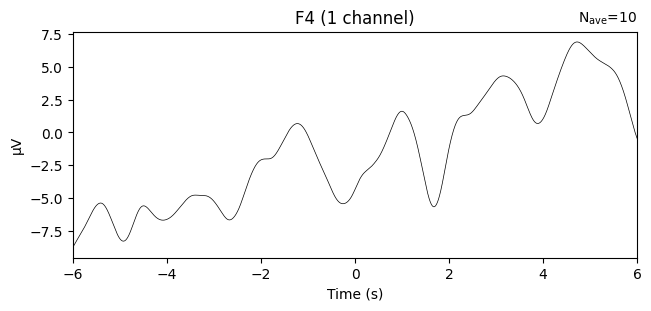

Need more than one channel to make topography for eeg. Disabling interactivity.


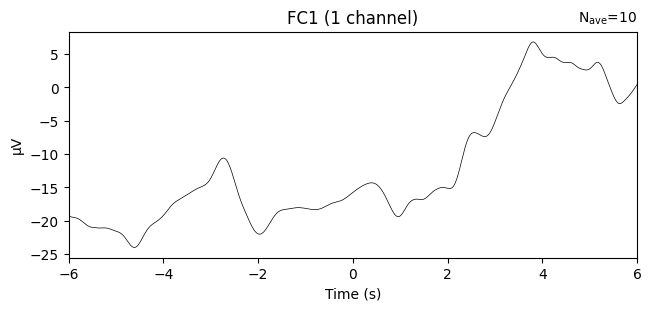

Need more than one channel to make topography for eeg. Disabling interactivity.


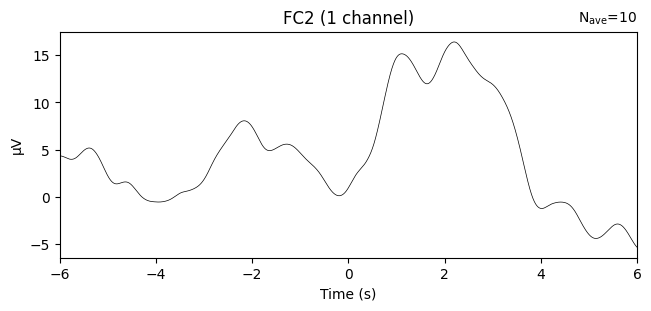

Need more than one channel to make topography for eeg. Disabling interactivity.


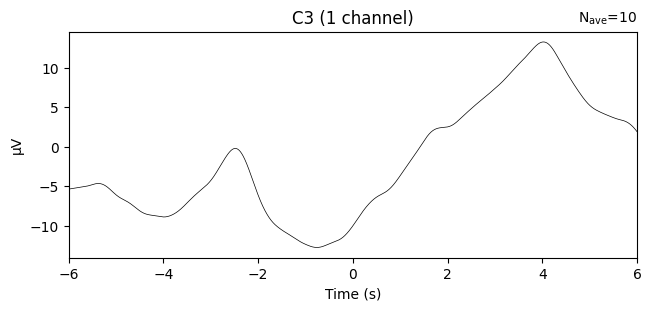

Need more than one channel to make topography for eeg. Disabling interactivity.


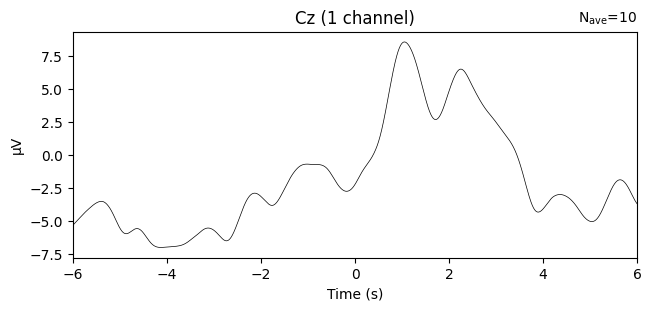

Need more than one channel to make topography for eeg. Disabling interactivity.


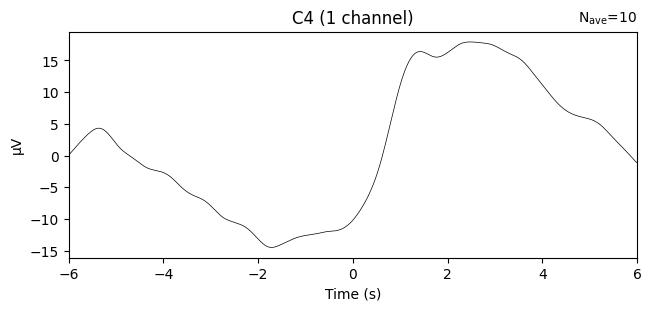

Need more than one channel to make topography for eeg. Disabling interactivity.


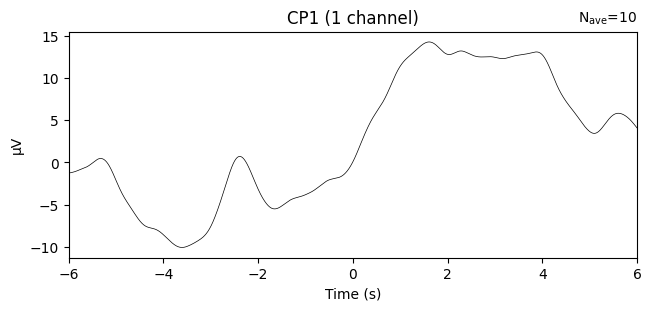

Need more than one channel to make topography for eeg. Disabling interactivity.


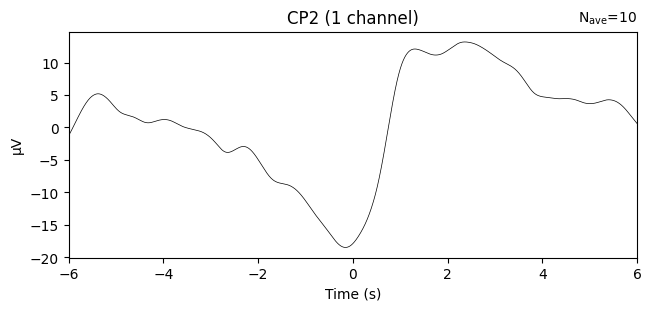

In [80]:
subjects = ['P101', 'P104']
path = 'data\\'
frontal_ch = ['F3', 'Fz', 'F4','FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1' ,'CP2']
for id_ in subjects:
    for filename in sorted(os.listdir(path+id_)):
        if filename == 'sub-P001_ses-Omnideck_S001_task-Default_run-001_eeg.xdf':
            continue
        streams, fileheader = pyxdf.load_xdf(path+id_+'\\'+filename, synchronize_clocks=False)
        match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
        print(match)
        eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])
        eeg_data = np.array(eeg_stream['time_series']).T

        eeg_timestamps = np.array(eeg_stream['time_stamps'])
        sfreq = float(eeg_stream['info']['nominal_srate'][0])

        ch_names = []
        for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
            ch_names.append(ch['label'][0])

        info = mne.create_info(
            ch_names=ch_names[:-3],
            sfreq=sfreq,
            ch_types='eeg'
        )

        raw = mne.io.RawArray(eeg_data[:-3]/10e5, info)

        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)
        marker_streams = [stream for stream in streams if stream['info']['type'][0] == 'Markers']

        # Initialize combined lists for time_series and time_stamps
        combined_time_series = []
        combined_time_stamps = []

        # Combine time_series and time_stamps from all marker streams
        for stream in marker_streams:
            combined_time_series.extend(stream['time_series'])
            combined_time_stamps.extend(stream['time_stamps'])

        # Convert to numpy arrays for sorting
        combined_time_series = np.array(combined_time_series)
        combined_time_stamps = np.array(combined_time_stamps)

        # Sort by time_stamps
        sorted_indices = np.argsort(combined_time_stamps)
        sorted_time_series = combined_time_series[sorted_indices]
        sorted_time_stamps = combined_time_stamps[sorted_indices]

        time_series = []
        time_stamps = []
        for series, stamp in zip(sorted_time_series, sorted_time_stamps):
            if len(series) == 0:
                continue
            elif series == ['']:
                continue
            else:
                time_series.append(int(series[0]))
                time_stamps.append(stamp)

        marker_stream = {
            'info': marker_streams[0]['info'],
            'time_series': np.array(time_series),
            'time_stamps': np.array(time_stamps),
        }

        event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
        event_samples = event_samples.astype(int)

        events = np.array([[sample, 0, label] for sample, label in zip(event_samples, marker_stream['time_series'])])
        annotations = mne.Annotations(onset=event_samples / sfreq,
                                      duration=[0] * len(event_samples),  # Instantaneous events
                                      description=list(marker_stream['time_series']))
        raw.set_annotations(annotations)

         # Filtering for MRCP and in general. Power Line noise (50Hz) and filter between 0.1 and 30Hz in general. MRCP is slow changes around 0.1 and 1Hz.
        raw = raw.notch_filter(50, method='fir', phase='zero')
        iir_params = dict(order=2, ftype='butter')
        raw = raw.filter(l_freq=0.01, h_freq=30, method='iir', iir_params=iir_params, phase='zero')
        raw.plot_psd()
        plt.close()

        iir_params = dict(order=2, ftype='butter')
        mrcp_data = raw.filter(l_freq=0.01, h_freq=1, method='iir', iir_params=iir_params, phase='zero')
        events_from_annot, event_dict = mne.events_from_annotations(raw)
        event_id = 1028 # beginning of trial
        selected_events = events[events[:, 2] == event_id]

        # when commbining all the marker stream each marker is present two times, so i only index every other one.
        epochs = mne.Epochs(raw, np.array(selected_events[::2]), event_id=int(event_id), tmin=-6, tmax=6, baseline=None, preload=True)
        evoked = epochs.average()

        evoked = evoked.pick(picks=frontal_ch)
        fig = evoked.plot_topo()
        fig.savefig(f'figures\\MRCP\\{match}_departing_topomap.png')
        plt.close(fig)

        for ch in frontal_ch:
            temp_evoked = evoked.copy().pick(picks=ch)
            fig = temp_evoked.plot(titles=ch)
            fig.savefig(f'figures\\MRCP\\{match}_departing_{ch}.png')
            plt.close(fig)

